In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/project/dandofi_cgan_excess.csv
/kaggle/input/project/dandofi_gan_excess.csv
/kaggle/input/project/dandofi_wcgan_excess.csv
/kaggle/input/project/dandofi_gan_primary.csv
/kaggle/input/project/specie_cgan_excess.csv
/kaggle/input/project/specie_wcgan_excess.csv
/kaggle/input/project/dandoww_cgan_excess.csv
/kaggle/input/project/dandofi_wgan_primary.csv
/kaggle/input/project/specie_gan_primary.csv
/kaggle/input/project/dandoww_gan_excess.csv
/kaggle/input/project/dandoww_gan_primary.csv
/kaggle/input/project/specie_cleaned_data.txt
/kaggle/input/project/dandoww_wgan_primary.csv
/kaggle/input/project/fi_dando_cleaned_data.txt
/kaggle/input/project/specie_gan_excess.csv
/kaggle/input/project/dandoww_wgan_excess.csv
/kaggle/input/project/dando_ww_cleaned_data.txt
/kaggle/input/project/dandoww_wcgan_primary.csv
/kaggle/input/project/specie_wcgan_primary.csv
/kaggle/input/project/specie_wgan_primary.csv
/kaggle/input/project/dandoww_cgan_primary.csv
/kaggle/input/project/specie_

In [2]:
# ! pip install sweetviz

# import sweetviz as sv
# import IPython

In [3]:
!pip install imbalanced-learn

In [4]:
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from collections import Counter
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay

In [5]:
import gc
import os
import sys

from keras import applications
from keras import backend as K
from keras import layers
from keras import models
from keras import optimizers
import tensorflow as tf

In [6]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.compat.v1.keras import backend as K
from tensorflow.python.keras.backend import set_session
from tensorflow.python.keras.models import load_model

# Loading the Data

In [7]:
df_dandoww = pd.read_csv('../input/project/dando_ww_cleaned_data.txt')
df_dandoww.head()

,LifetimePolicyReference,PolicyReference,PriorPolicyRef,EclipsePolicyID,PriorEclipsePolicyID,GroupClass,PlacingBasis,SubClassCode,SubClass,StatsMinorClassCode,...,CLR_ExCat,ClaimFrequency,ILR_Cat,ILR_ExCat,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,PLR_band,PLR_band_ex_adj,YOA_recent
0,KA142H12U000,KA142H16A000,KA142H15A000,697599,648601,D&O WW,Binder,90418,LEISURE / HOTELS / ENTERTAINMENT,DO,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,Upper Quantile,Lower quantile,Recent
1,KB429L10A000,KB429L10A000,KB429L09A000,440615,-1,D&O WW,OM,90425,SPECIALTY / FINANCE / PROFESSIONAL SERVI,DP,...,0.0,0.000000,0.0,0.0,0.190282,0.418620,0.135131,Lower quantile,Lower Middle,History
2,KC411Z09A000,KC411Z11A000,KC411Z10A000,489852,440913,D&O WW,OM,90429,UTILITIES,DT,...,0.0,64.517151,0.0,0.0,0.931700,0.908975,0.639646,Upper Middle,Upper Quantile,History
3,KC120X14A000,KC120X16A000,KC120X15A000,738958,689682,D&O WW,OM,90427,TELECOMMUNICATIONS,DQ,...,0.0,33.884811,0.0,0.0,0.560892,0.667590,0.399886,Lower Middle,Upper Middle,Recent
4,KC606A09A000,KC606A16A000,KC606A15A000,744113,699828,D&O WW,OM,90421,OIL AND GAS,DQ,...,0.0,0.000000,0.0,0.0,1.346199,1.074267,0.960395,Upper Quantile,Upper Quantile,Recent


# Dropping features

In [8]:
df_dandoww.drop(['LifetimePolicyReference', 'PolicyReference', 'PriorPolicyRef', 
               'EclipsePolicyID', 'PriorEclipsePolicyID', 'GroupClass',
               'StatsMinorClassDescription', 'InceptionDate', 'ExpiryDate', 
               'RenewalDate', 'SubClassCode'], axis=1, inplace=True)
df_dandoww.head()

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,YOA,Limit_100Pct_USD,GNWP,GGTP,GGWP,Inc,...,CLR_ExCat,ClaimFrequency,ILR_Cat,ILR_ExCat,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,PLR_band,PLR_band_ex_adj,YOA_recent
0,Binder,LEISURE / HOTELS / ENTERTAINMENT,DO,UNITED KINGDOM,2016.0,3.089000e+05,28740.266052,40309.176496,39641.754800,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,Upper Quantile,Lower quantile,Recent
1,OM,SPECIALTY / FINANCE / PROFESSIONAL SERVI,DP,UNITED KINGDOM,2010.0,1.235600e+07,54366.400000,30890.000000,67958.000000,0.0,...,0.0,0.000000,0.0,0.0,0.190282,0.418620,0.135131,Lower quantile,Lower Middle,History
2,OM,UTILITIES,DT,ITALY,2011.0,3.369512e+07,15499.754568,17268.748296,16847.559313,0.0,...,0.0,64.517151,0.0,0.0,0.931700,0.908975,0.639646,Upper Middle,Upper Quantile,History
3,OM,TELECOMMUNICATIONS,DQ,UNITED KINGDOM,2016.0,2.000000e+07,59023.495000,50000.000000,59511.500000,0.0,...,0.0,33.884811,0.0,0.0,0.560892,0.667590,0.399886,Lower Middle,Upper Middle,Recent
4,OM,OIL AND GAS,DQ,WESTERN AUSTRALIA,2016.0,6.885100e+06,7616.621683,10966.863850,8751.557351,0.0,...,0.0,0.000000,0.0,0.0,1.346199,1.074267,0.960395,Upper Quantile,Upper Quantile,Recent


In [9]:
df_dandoww.drop(['Exposure', 'LinePct'], axis=1, inplace=True)
df_dandoww.head()

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,YOA,Limit_100Pct_USD,GNWP,GGTP,GGWP,Inc,...,CLR_ExCat,ClaimFrequency,ILR_Cat,ILR_ExCat,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,PLR_band,PLR_band_ex_adj,YOA_recent
0,Binder,LEISURE / HOTELS / ENTERTAINMENT,DO,UNITED KINGDOM,2016.0,3.089000e+05,28740.266052,40309.176496,39641.754800,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,Upper Quantile,Lower quantile,Recent
1,OM,SPECIALTY / FINANCE / PROFESSIONAL SERVI,DP,UNITED KINGDOM,2010.0,1.235600e+07,54366.400000,30890.000000,67958.000000,0.0,...,0.0,0.000000,0.0,0.0,0.190282,0.418620,0.135131,Lower quantile,Lower Middle,History
2,OM,UTILITIES,DT,ITALY,2011.0,3.369512e+07,15499.754568,17268.748296,16847.559313,0.0,...,0.0,64.517151,0.0,0.0,0.931700,0.908975,0.639646,Upper Middle,Upper Quantile,History
3,OM,TELECOMMUNICATIONS,DQ,UNITED KINGDOM,2016.0,2.000000e+07,59023.495000,50000.000000,59511.500000,0.0,...,0.0,33.884811,0.0,0.0,0.560892,0.667590,0.399886,Lower Middle,Upper Middle,Recent
4,OM,OIL AND GAS,DQ,WESTERN AUSTRALIA,2016.0,6.885100e+06,7616.621683,10966.863850,8751.557351,0.0,...,0.0,0.000000,0.0,0.0,1.346199,1.074267,0.960395,Upper Quantile,Upper Quantile,Recent


In [10]:
# Since claims won’t be mature enough
df_dandoww.drop(df_dandoww[df_dandoww.YOA == 2020.0].index, inplace=True)
df_dandoww.drop(df_dandoww[df_dandoww.YOA == 2021.0].index, inplace=True)
df_dandoww.reset_index(drop=True, inplace=True)

In [11]:
df_dandoww.drop(df_dandoww[df_dandoww.PlacingBasis == 'Binder'].index, axis=0, inplace=True)
df_dandoww.drop(df_dandoww[df_dandoww.PlacingBasis == 'Other'].index, axis=0, inplace=True)
df_dandoww.reset_index(drop=True, inplace=True)

In [12]:
df_dandoww.replace(' ', '_', regex=True, inplace=True)
df_dandoww.head()

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,YOA,Limit_100Pct_USD,GNWP,GGTP,GGWP,Inc,...,CLR_ExCat,ClaimFrequency,ILR_Cat,ILR_ExCat,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,PLR_band,PLR_band_ex_adj,YOA_recent
0,OM,SPECIALTY_/_FINANCE_/_PROFESSIONAL_SERVI,DP,UNITED_KINGDOM,2010.0,1.235600e+07,54366.400000,30890.000000,67958.000000,0.0,...,0.0,0.000000,0.0,0.0,0.190282,0.418620,0.135131,Lower_quantile,Lower_Middle,History
1,OM,UTILITIES,DT,ITALY,2011.0,3.369512e+07,15499.754568,17268.748296,16847.559313,0.0,...,0.0,64.517151,0.0,0.0,0.931700,0.908975,0.639646,Upper_Middle,Upper_Quantile,History
2,OM,TELECOMMUNICATIONS,DQ,UNITED_KINGDOM,2016.0,2.000000e+07,59023.495000,50000.000000,59511.500000,0.0,...,0.0,33.884811,0.0,0.0,0.560892,0.667590,0.399886,Lower_Middle,Upper_Middle,Recent
3,OM,OIL_AND_GAS,DQ,WESTERN_AUSTRALIA,2016.0,6.885100e+06,7616.621683,10966.863850,8751.557351,0.0,...,0.0,0.000000,0.0,0.0,1.346199,1.074267,0.960395,Upper_Quantile,Upper_Quantile,Recent
4,OM,INSURANCE_BROKERS,DP,SOUTH_AFRICA,2011.0,5.755396e+05,2581.727138,3442.310182,3442.310182,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,Upper_Middle,Lower_quantile,History


# Classification

In [13]:
df_dandoww.drop(['Inc', 'Inc_Cat', 'ClaimFrequency', 'CLR_Cat', 
                'CLR_ExCat', 'Full_Inc_ExCat', 'Inc_ExCat', 
                 'ILR_Cat', 'ILR_ExCat', 'GNWP'], axis=1, inplace=True)
df_dandoww.head()

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,YOA,Limit_100Pct_USD,GGTP,GGWP,LeaderStatus,LeaderLinePct,...,BrokerFeePct,YOA_cat,Excess,Attachment,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,PLR_band,PLR_band_ex_adj,YOA_recent
0,OM,SPECIALTY_/_FINANCE_/_PROFESSIONAL_SERVI,DP,UNITED_KINGDOM,2010.0,1.235600e+07,30890.000000,67958.000000,LEAD,50.0,...,20.000000,2010,Primary,1.235600e+05,0.190282,0.418620,0.135131,Lower_quantile,Lower_Middle,History
1,OM,UTILITIES,DT,ITALY,2011.0,3.369512e+07,17268.748296,16847.559313,FOLLOW,50.0,...,8.000000,2011,Excess,5.615853e+07,0.931700,0.908975,0.639646,Upper_Middle,Upper_Quantile,History
2,OM,TELECOMMUNICATIONS,DQ,UNITED_KINGDOM,2016.0,2.000000e+07,50000.000000,59511.500000,FOLLOW,50.0,...,0.820018,2016,Excess,7.000000e+07,0.560892,0.667590,0.399886,Lower_Middle,Upper_Middle,Recent
3,OM,OIL_AND_GAS,DQ,WESTERN_AUSTRALIA,2016.0,6.885100e+06,10966.863850,8751.557351,LEAD,100.0,...,12.968385,2016,Excess,1.204892e+08,1.346199,1.074267,0.960395,Upper_Quantile,Upper_Quantile,Recent
4,OM,INSURANCE_BROKERS,DP,SOUTH_AFRICA,2011.0,5.755396e+05,3442.310182,3442.310182,LEAD,100.0,...,25.000160,2011,Excess,5.812950e+05,0.000000,0.000000,0.000000,Upper_Middle,Lower_quantile,History


In [14]:
# Making 100% share basis
df_dandoww.GGTP = df_dandoww.GGTP / df_dandoww.EffectiveLine
df_dandoww.GGWP = df_dandoww.GGWP / df_dandoww.EffectiveLine
df_dandoww.GrossGrossModelPrice = df_dandoww.GrossGrossModelPrice / df_dandoww.EffectiveLine
df_dandoww.GrossNetModelPrice = df_dandoww.GrossNetModelPrice / df_dandoww.EffectiveLine
df_dandoww.GrossGrossTechnicalPrice = df_dandoww.GrossGrossTechnicalPrice / df_dandoww.EffectiveLine
df_dandoww.GrossNetTechnicalPrice = df_dandoww.GrossNetTechnicalPrice / df_dandoww.EffectiveLine

In [15]:
# Rename the columns
df_dandoww = df_dandoww.rename(columns={'GGTP': 'Full_GGTP'})
df_dandoww = df_dandoww.rename(columns={'GGWP': 'Full_GGWP'})
df_dandoww = df_dandoww.rename(columns={'GrossGrossModelPrice': 'Full_GrossGrossModelPrice'})
df_dandoww = df_dandoww.rename(columns={'GrossNetModelPrice': 'Full_GrossNetModelPrice'})
df_dandoww = df_dandoww.rename(columns={'GrossGrossTechnicalPrice': 'Full_GrossGrossTechnicalPrice'})
df_dandoww = df_dandoww.rename(columns={'GrossNetTechnicalPrice': 'Full_GrossNetTechnicalPrice'})

In [16]:
df_dandoww.drop('EffectiveLine', axis=1, inplace=True)

In [17]:
X = df_dandoww.copy()
X.head()

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,YOA,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderStatus,LeaderLinePct,...,BrokerFeePct,YOA_cat,Excess,Attachment,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,PLR_band,PLR_band_ex_adj,YOA_recent
0,OM,SPECIALTY_/_FINANCE_/_PROFESSIONAL_SERVI,DP,UNITED_KINGDOM,2010.0,1.235600e+07,61780.000000,135916.000000,LEAD,50.0,...,20.000000,2010,Primary,1.235600e+05,0.190282,0.418620,0.135131,Lower_quantile,Lower_Middle,History
1,OM,UTILITIES,DT,ITALY,2011.0,3.369512e+07,34537.496591,33695.118626,FOLLOW,50.0,...,8.000000,2011,Excess,5.615853e+07,0.931700,0.908975,0.639646,Upper_Middle,Upper_Quantile,History
2,OM,TELECOMMUNICATIONS,DQ,UNITED_KINGDOM,2016.0,2.000000e+07,100000.000000,119023.000000,FOLLOW,50.0,...,0.820018,2016,Excess,7.000000e+07,0.560892,0.667590,0.399886,Lower_Middle,Upper_Middle,Recent
3,OM,OIL_AND_GAS,DQ,WESTERN_AUSTRALIA,2016.0,6.885100e+06,10966.863850,8751.557351,LEAD,100.0,...,12.968385,2016,Excess,1.204892e+08,1.346199,1.074267,0.960395,Upper_Quantile,Upper_Quantile,Recent
4,OM,INSURANCE_BROKERS,DP,SOUTH_AFRICA,2011.0,5.755396e+05,3442.310182,3442.310182,LEAD,100.0,...,25.000160,2011,Excess,5.812950e+05,0.000000,0.000000,0.000000,Upper_Middle,Lower_quantile,History


In [18]:
df_dandoww.drop(['YOA', 'YOA_cat', 'YOA_recent'], axis=1, inplace=True)
X = X.drop(['YOA', 'YOA_cat', 'YOA_recent'], axis=1).copy()

In [19]:
X['Class'] = X['ClaimCount'] / X['ClaimCount']
X['Class'] = X['Class'].fillna(0)
X.head()

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderStatus,LeaderLinePct,BrokerUltimateName,...,PricingStrength2,BrokerFeePct,Excess,Attachment,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,PLR_band,PLR_band_ex_adj,Class
0,OM,SPECIALTY_/_FINANCE_/_PROFESSIONAL_SERVI,DP,UNITED_KINGDOM,1.235600e+07,61780.000000,135916.000000,LEAD,50.0,AON,...,1.20000,20.000000,Primary,1.235600e+05,0.190282,0.418620,0.135131,Lower_quantile,Lower_Middle,0.0
1,OM,UTILITIES,DT,ITALY,3.369512e+07,34537.496591,33695.118626,FOLLOW,50.0,AON,...,-0.02439,8.000000,Excess,5.615853e+07,0.931700,0.908975,0.639646,Upper_Middle,Upper_Quantile,1.0
2,OM,TELECOMMUNICATIONS,DQ,UNITED_KINGDOM,2.000000e+07,100000.000000,119023.000000,FOLLOW,50.0,MARSH,...,0.19023,0.820018,Excess,7.000000e+07,0.560892,0.667590,0.399886,Lower_Middle,Upper_Middle,1.0
3,OM,OIL_AND_GAS,DQ,WESTERN_AUSTRALIA,6.885100e+06,10966.863850,8751.557351,LEAD,100.0,AON,...,-0.20200,12.968385,Excess,1.204892e+08,1.346199,1.074267,0.960395,Upper_Quantile,Upper_Quantile,0.0
4,OM,INSURANCE_BROKERS,DP,SOUTH_AFRICA,5.755396e+05,3442.310182,3442.310182,LEAD,100.0,SAFEONLINE,...,0.00000,25.000160,Excess,5.812950e+05,0.000000,0.000000,0.000000,Upper_Middle,Lower_quantile,0.0


In [20]:
df_dandoww.drop('ClaimCount', axis=1, inplace=True)
X.drop('ClaimCount', axis=1, inplace=True)

In [21]:
# Divide into primary and excess business
X_p = X.copy()
X_p.drop(X_p[X_p.Excess == 'Excess'].index, axis=0, inplace=True)
X_p.drop(['Excess', 'XS_100Pct_USD'], axis=1, inplace=True)
X_p.reset_index(drop=True, inplace=True)
X_p.head()

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderStatus,LeaderLinePct,BrokerUltimateName,...,PricingStrength,PricingStrength2,BrokerFeePct,Attachment,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,PLR_band,PLR_band_ex_adj,Class
0,OM,SPECIALTY_/_FINANCE_/_PROFESSIONAL_SERVI,DP,UNITED_KINGDOM,12356000.0,61780.0,135916.0,LEAD,50.0,AON,...,2.200000,1.200000,20.000000,123560.0,0.190282,0.418620,0.135131,Lower_quantile,Lower_Middle,0.0
1,OM,SPECIALTY_/_FINANCE_/_PROFESSIONAL_SERVI,DP,UNITED_KINGDOM,12356000.0,30890.0,44481.6,LEAD,100.0,AON,...,1.440000,0.440000,20.000000,0.0,0.234722,0.338000,0.163896,Lower_quantile,Lower_Middle,0.0
2,OM,PROPERTY_/_REAL_ESTATE,DN,USA_VIRGIN_ISLANDS,1000000.0,5000.0,5700.0,LEAD,100.0,R_K_HARRISON,...,1.140000,0.140000,25.000000,5000.0,0.810877,0.924400,0.604558,Upper_Middle,Upper_Quantile,0.0
3,OM,SPECIALTY_/_FINANCE_/_PROFESSIONAL_SERVI,DP,DISTRICT_OF_COLUMBIA,10000000.0,99422.0,208787.0,FOLLOW,25.0,WILLIS,...,2.100008,1.100008,35.700369,250000.0,0.072178,0.151574,0.051535,Lower_quantile,Lower_quantile,0.0
4,OM,PROPERTY_/_REAL_ESTATE,DN,USA_VIRGIN_ISLANDS,5000000.0,15000.0,15000.0,LEAD,100.0,R_K_HARRISON,...,1.000000,0.000000,25.000000,25000.0,0.558400,0.558400,0.398139,Upper_Quantile,Upper_Middle,0.0


In [22]:
# Divide into primary and excess business
X_e = X.copy()
X_e.drop(X_e[X_e.Excess == 'Primary'].index, axis=0, inplace=True)
X_e.drop('Excess', axis=1, inplace=True)
X_e.reset_index(drop=True, inplace=True)
X_e.head()

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderStatus,LeaderLinePct,BrokerUltimateName,...,PricingStrength,PricingStrength2,BrokerFeePct,Attachment,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,PLR_band,PLR_band_ex_adj,Class
0,OM,UTILITIES,DT,ITALY,3.369512e+07,34537.496591,33695.118626,FOLLOW,50.0,AON,...,0.97561,-0.02439,8.000000,5.615853e+07,0.931700,0.908975,0.639646,Upper_Middle,Upper_Quantile,1.0
1,OM,TELECOMMUNICATIONS,DQ,UNITED_KINGDOM,2.000000e+07,100000.000000,119023.000000,FOLLOW,50.0,MARSH,...,1.19023,0.19023,0.820018,7.000000e+07,0.560892,0.667590,0.399886,Lower_Middle,Upper_Middle,1.0
2,OM,OIL_AND_GAS,DQ,WESTERN_AUSTRALIA,6.885100e+06,10966.863850,8751.557351,LEAD,100.0,AON,...,0.79800,-0.20200,12.968385,1.204892e+08,1.346199,1.074267,0.960395,Upper_Quantile,Upper_Quantile,0.0
3,OM,INSURANCE_BROKERS,DP,SOUTH_AFRICA,5.755396e+05,3442.310182,3442.310182,LEAD,100.0,SAFEONLINE,...,1.00000,0.00000,25.000160,5.812950e+05,0.000000,0.000000,0.000000,Upper_Middle,Lower_quantile,0.0
4,OM,RETAILERS,DT,NETHERLANDS,1.000000e+08,100000.000000,100000.000000,FOLLOW,25.0,WILLIS,...,1.00000,0.00000,0.017750,2.500000e+08,0.655330,0.655330,0.512468,Upper_Quantile,Upper_Middle,1.0


In [23]:
# Data scaling
# Scale only columns that have values greater than 1
to_scale = [col for col in X.columns[X.dtypes != 'object'] if X[col].max() > 1]
mms = MinMaxScaler()
scaled = mms.fit_transform(X[to_scale])
scaled = pd.DataFrame(scaled, columns=to_scale)

X_scaled = X.copy()
# Replace original columns with scaled ones
for col in scaled:
    X_scaled[col] = scaled[col]
    
X_scaled.head()

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderStatus,LeaderLinePct,BrokerUltimateName,...,PricingStrength2,BrokerFeePct,Excess,Attachment,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,PLR_band,PLR_band_ex_adj,Class
0,OM,SPECIALTY_/_FINANCE_/_PROFESSIONAL_SERVI,DP,UNITED_KINGDOM,0.034013,0.005813,0.060191,LEAD,0.489796,AON,...,0.319047,0.405422,Primary,0.000107,0.027651,0.079799,0.044962,Lower_quantile,Lower_Middle,0.0
1,OM,UTILITIES,DT,ITALY,0.093308,0.003247,0.014891,FOLLOW,0.489796,AON,...,0.135857,0.195571,Excess,0.048622,0.135392,0.173272,0.212832,Upper_Middle,Upper_Quantile,1.0
2,OM,TELECOMMUNICATIONS,DQ,UNITED_KINGDOM,0.055253,0.009413,0.052705,FOLLOW,0.489796,MARSH,...,0.167968,0.070010,Excess,0.060606,0.081507,0.127258,0.133056,Lower_Middle,Upper_Middle,1.0
3,OM,OIL_AND_GAS,DQ,WESTERN_AUSTRALIA,0.018812,0.001027,0.003838,LEAD,1.000000,AON,...,0.109283,0.282456,Excess,0.104320,0.195626,0.204780,0.319555,Upper_Quantile,Upper_Quantile,0.0
4,OM,INSURANCE_BROKERS,DP,SOUTH_AFRICA,0.001279,0.000319,0.001485,LEAD,1.000000,SAFEONLINE,...,0.139506,0.492863,Excess,0.000503,0.000000,0.000000,0.000000,Upper_Middle,Lower_quantile,0.0


In [24]:
# Divide into primary and excess business
X_p_scaled = X_scaled.copy()
X_p_scaled.drop(X_p_scaled[X_p_scaled.Excess == 'Excess'].index, axis=0, inplace=True)
X_p_scaled.drop('Excess', axis=1, inplace=True)
X_p_scaled.reset_index(drop=True, inplace=True)
# X_p_scaled.head()

X_e_scaled = X_scaled.copy()
X_e_scaled.drop(X_e_scaled[X_e_scaled.Excess == 'Primary'].index, axis=0, inplace=True)
X_e_scaled.drop('Excess', axis=1, inplace=True)
X_e_scaled.reset_index(drop=True, inplace=True)
# X_e_scaled.head()

### One-hot encoding

In [25]:
X_encoded = pd.get_dummies(X_scaled, columns = ['PlacingBasis', 'SubClass', 'StatsMinorClassCode', 
                                        'Territory', 'LeaderStatus', 'BrokerUltimateName', 
                                         'Excess', 'PLR_band', 'PLR_band_ex_adj'])
X_encoded_p = pd.get_dummies(X_p_scaled, columns = ['PlacingBasis', 'SubClass', 'StatsMinorClassCode', 
                                        'Territory', 'LeaderStatus', 'BrokerUltimateName', 'PLR_band', 
                                             'PLR_band_ex_adj'])
X_encoded_e = pd.get_dummies(X_e_scaled, columns = ['PlacingBasis', 'SubClass', 'StatsMinorClassCode', 
                                        'Territory', 'LeaderStatus', 'BrokerUltimateName', 'PLR_band', 
                                            'PLR_band_ex_adj'])

In [26]:
y = X_scaled['Class'].copy()
y_p = X_p_scaled['Class'].copy()
y_e = X_e_scaled['Class'].copy()

In [27]:
X_encoded.drop('Class', axis=1, inplace=True)
X_encoded_p.drop('Class', axis=1, inplace=True)
X_encoded_e.drop('Class', axis=1, inplace=True)

### EDA

In [28]:
X.describe()

,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,Full_GrossNetModelPrice,...,Full_GrossNetTechnicalPrice,Full_GNWP,PricingStrength,PricingStrength2,BrokerFeePct,Attachment,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,Class
count,2.312000e+03,2.312000e+03,2.312000e+03,2312.000000,2.312000e+03,2.312000e+03,2312.000000,2312.000000,2.312000e+03,2.312000e+03,...,2.312000e+03,2.312000e+03,2312.000000,2312.000000,2312.000000,2.312000e+03,2312.000000,2312.000000,2312.000000,2312.000000
mean,3.110862e+07,9.050021e+04,1.002539e+05,46.957484,9.013486e+07,4.284182e+05,0.632449,0.000770,5.570432e+04,4.849428e+04,...,7.946682e+04,8.797467e+04,1.176477,0.177903,13.835335,9.056327e+07,0.605495,0.666239,0.427714,0.264706
std,3.758087e+07,2.557989e+05,1.547752e+05,29.860070,9.915548e+07,2.685686e+06,0.126623,0.184744,1.329095e+05,1.165918e+05,...,2.239313e+05,1.371980e+05,0.325926,0.346758,9.707539,9.943760e+07,0.489332,0.483054,0.334834,0.441272
min,1.151079e+05,5.766817e+01,9.180483e+01,2.000000,0.000000e+00,0.000000e+00,0.108900,-0.520000,0.000000e+00,0.000000e+00,...,5.032000e+01,7.225000e+01,0.200000,-0.932416,-3.183421,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1.000000e+07,2.500000e+04,2.776950e+04,25.000000,1.500000e+07,0.000000e+00,0.552450,-0.025000,1.029110e+04,8.763749e+03,...,2.154577e+04,2.384256e+04,1.000000,0.000000,3.546541,1.505000e+07,0.263778,0.329887,0.188443,0.000000
50%,1.853400e+07,5.000000e+04,5.574600e+04,37.500000,6.178000e+07,0.000000e+00,0.650650,0.000000,2.847600e+04,2.384974e+04,...,4.222664e+04,4.725000e+04,1.095222,0.095222,14.000000,6.178000e+07,0.512566,0.601257,0.365013,0.000000
75%,3.706800e+07,1.000000e+05,1.121085e+05,60.000000,1.318627e+08,6.178000e+04,0.713000,0.000000,6.569326e+04,5.681965e+04,...,8.826199e+04,9.741571e+04,1.270000,0.270000,22.500000,1.350000e+08,0.838245,0.909204,0.590073,1.000000
max,3.600000e+08,1.061759e+07,2.256645e+06,100.000000,1.155000e+09,9.000000e+07,1.973000,3.678200,4.938025e+06,4.308426e+06,...,9.263848e+06,1.805316e+06,5.000000,5.751280,54.000000,1.155000e+09,6.881506,5.245959,3.005410,1.000000


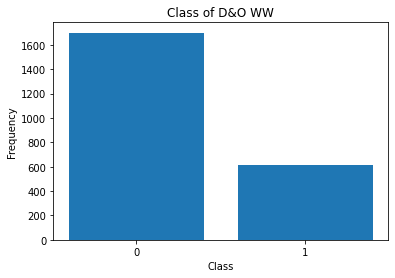

In [29]:
plt.bar(dict(Counter(y)).keys(), dict(Counter(y)).values())
plt.xticks(np.arange(2))
plt.title('Class of D&O WW')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [30]:
# report = sv.analyze(X_scaled, 'Class')
# report.show_html(filepath='D&O WW.html',
#                  open_browser=True,
#                  layout='vertical',
#                  scale=None)

In [31]:
# X[["Excess", "Class"]].groupby(['Excess'], as_index=False).mean().sort_values(
#     by='Class', ascending=False)

In [32]:
# X[["Territory", "Class"]].groupby(['Territory'], as_index=False).mean().sort_values(
#     by='Class', ascending=False)

In [33]:
# X_e_scaled[["BrokerUltimateName", "Class"]].groupby(['BrokerUltimateName'], as_index=False).mean().sort_values(
#     by='Class', ascending=False)

#### Primary Business

In [34]:
X_p.describe()

,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,Full_GrossNetModelPrice,Full_GrossGrossTechnicalPrice,Full_GrossNetTechnicalPrice,Full_GNWP,PricingStrength,PricingStrength2,BrokerFeePct,Attachment,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,Class
count,4.130000e+02,413.000000,413.000000,413.000000,4.130000e+02,413.000000,413.000000,4.130000e+02,4.130000e+02,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,4.130000e+02,413.000000,413.000000,413.000000,413.000000
mean,7.189573e+06,46499.510326,56244.378492,84.898927,1.924876e+05,0.590010,0.007002,2.112025e+04,1.863077e+04,46499.510431,41054.536766,49057.991250,1.279570,0.281228,16.139067,1.924876e+05,0.350936,0.419098,0.247922,0.154964
std,7.658674e+06,81028.580253,92990.144348,24.812277,7.961009e+05,0.127296,0.117727,1.035261e+05,9.544356e+04,81028.580309,73669.497285,82886.661613,0.417565,0.437256,8.911660,7.961009e+05,0.352192,0.392882,0.249359,0.362309
min,1.151079e+05,100.000000,100.000000,7.200000,0.000000e+00,0.112400,-0.520000,0.000000e+00,0.000000e+00,100.000000,79.750000,79.750000,0.200000,-0.922372,-3.183421,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1.000000e+06,5000.000000,6000.000000,50.000000,5.000000e+03,0.514500,0.000000,9.909500e+02,7.927600e+02,5000.000000,3767.120000,4500.000000,1.000000,0.000000,7.519541,5.000000e+03,0.121332,0.161000,0.084725,0.000000
50%,5.000000e+06,15000.000000,17914.571403,100.000000,1.235600e+04,0.606400,0.000000,4.037943e+03,3.218830e+03,15000.000000,12000.000000,14249.786080,1.166667,0.166667,20.000000,1.235600e+04,0.240556,0.334767,0.174608,0.000000
75%,1.000000e+07,50000.000000,59087.670000,100.000000,7.342088e+04,0.692800,0.000000,1.328888e+04,1.063110e+04,50000.000000,41660.130000,51277.143027,1.357143,0.357143,22.500000,7.342088e+04,0.483765,0.584900,0.337778,0.000000
max,5.000000e+07,728036.459803,748961.419726,100.000000,1.000000e+07,0.847000,1.450000,2.005028e+06,1.854260e+06,728036.453084,701667.698584,721834.669546,5.000000,4.807087,35.700369,1.000000e+07,3.615289,4.057159,2.668394,1.000000


In [35]:
X_p.skew()

Limit_100Pct_USD                  2.526542
Full_GGTP                         3.938418
Full_GGWP                         3.167235
LeaderLinePct                    -1.197239
Ded_100Pct_USD                    9.680248
PLR                              -0.705172
RARC                              5.998330
Full_GrossGrossModelPrice        17.290971
Full_GrossNetModelPrice          17.476407
Full_GrossGrossTechnicalPrice     3.938418
Full_GrossNetTechnicalPrice       4.005032
Full_GNWP                         3.349376
PricingStrength                   3.682711
PricingStrength2                  4.387074
BrokerFeePct                     -0.824568
Attachment                        9.680248
ModelToActualRto                  2.998487
ModelToTechnicalRto               2.844603
PLR_ex_adj                        3.171049
Class                             1.913921
dtype: float64

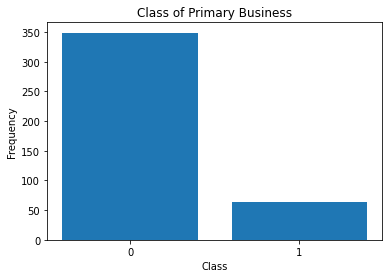

In [36]:
plt.bar(dict(Counter(y_p)).keys(), dict(Counter(y_p)).values())
plt.xticks(np.arange(2))
plt.title('Class of Primary Business')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


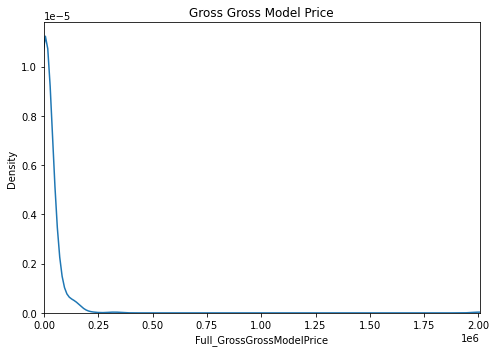

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


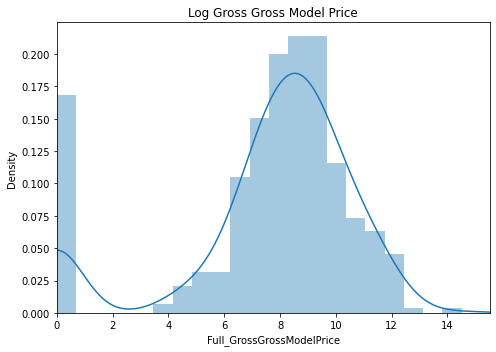

In [37]:
# Looking at the skewness of Full_GrossGrossModelPrice
plt.figure(figsize=(7,5))
sns.distplot(X_p.Full_GrossGrossModelPrice, hist=False)
plt.title(f"Gross Gross Model Price")
plt.xlim(0, X_p.Full_GrossGrossModelPrice.max()+1)
plt.tight_layout()
plt.show()

# Log-transform
plt.figure(figsize=(7,5))
sns.distplot(np.log1p(X_p.Full_GrossGrossModelPrice))
plt.title(f"Log Gross Gross Model Price")
plt.xlim(0, np.log1p(X_p.Full_GrossGrossModelPrice).max()+1)
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


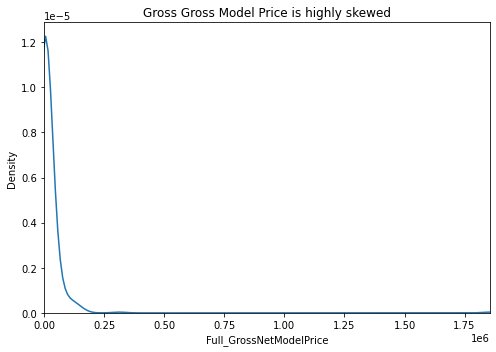

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


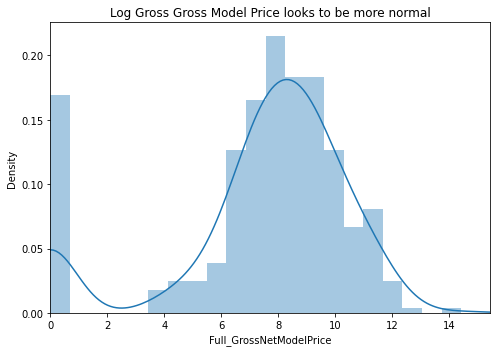

In [38]:
# Looking at the skewness of Full_GrossNetModelPrice
plt.figure(figsize=(7,5))
sns.distplot(X_p.Full_GrossNetModelPrice, hist=False)
plt.title(f"Gross Gross Model Price is highly skewed")
# plt.ylabel("Count of readings")
# plt.xlabel(f"Measured consumption")
plt.xlim(0, X_p.Full_GrossNetModelPrice.max()+1)
plt.tight_layout()
plt.show()

# Log transform
plt.figure(figsize=(7,5))
sns.distplot(np.log1p(X_p.Full_GrossNetModelPrice))
plt.title(f"Log Gross Gross Model Price looks to be more normal")
# plt.ylabel("Count of readings")
# plt.xlabel(f"Measured consumption")
plt.xlim(0, np.log1p(X_p.Full_GrossNetModelPrice).max()+1)
plt.tight_layout()
plt.show()

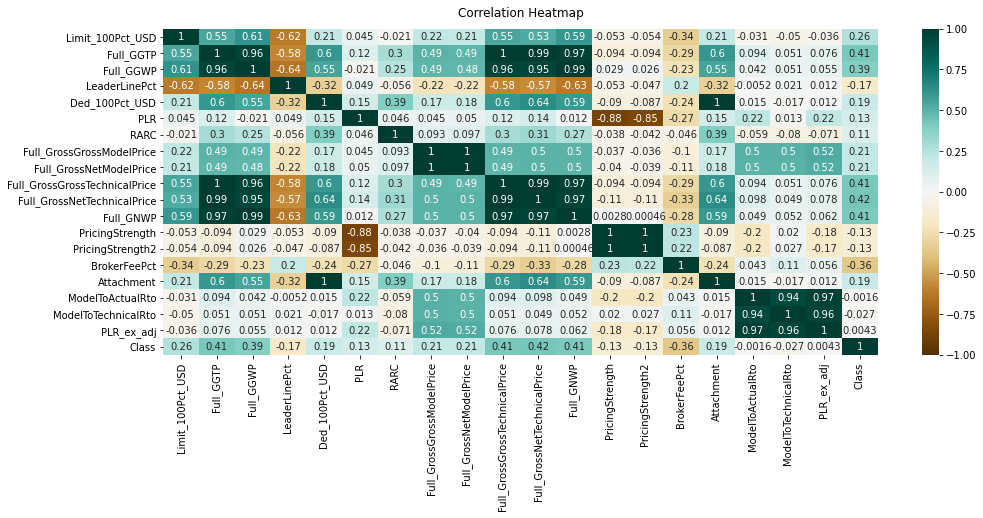

In [39]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(X_p.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [40]:
# report_p = sv.analyze(X_p_scaled, 'Class')
# report_p.show_html(filepath='D&O WW Primary.html',
#                  open_browser=True,
#                  layout='vertical',
#                  scale=None)

#### Excess Business

In [41]:
X_e.describe()

,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,Full_GrossNetModelPrice,...,Full_GrossNetTechnicalPrice,Full_GNWP,PricingStrength,PricingStrength2,BrokerFeePct,Attachment,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,Class
count,1.899000e+03,1.899000e+03,1.899000e+03,1899.000000,1.899000e+03,1.899000e+03,1899.000000,1899.000000,1.899000e+03,1.899000e+03,...,1.899000e+03,1.899000e+03,1899.000000,1899.000000,1899.000000,1.899000e+03,1899.000000,1899.000000,1899.000000,1899.000000
mean,3.631060e+07,1.000696e+05,1.098253e+05,38.705870,1.097376e+08,4.797291e+05,0.641679,-0.000585,6.322576e+04,5.498908e+04,...,8.782084e+04,9.643839e+04,1.154056,0.155431,13.334312,1.102174e+08,0.660858,0.719988,0.466816,0.288573
std,3.943781e+07,2.788065e+05,1.636394e+05,23.887892,9.909031e+07,2.937704e+06,0.124610,0.196312,1.373514e+05,1.197411e+05,...,2.439010e+05,1.450057e+05,0.297790,0.319491,9.802891,9.937650e+07,0.497450,0.484178,0.338303,0.453218
min,5.755396e+05,5.766817e+01,9.180483e+01,2.000000,6.178000e+03,0.000000e+00,0.108900,-0.500000,0.000000e+00,0.000000e+00,...,5.032000e+01,7.225000e+01,0.200000,-0.932416,-0.022213,1.235600e+04,0.000000,0.000000,0.000000,0.000000
25%,1.235600e+07,3.101311e+04,3.508012e+04,21.575000,3.671044e+07,0.000000e+00,0.560200,-0.050000,1.642333e+04,1.368473e+04,...,2.666487e+04,2.970317e+04,1.000000,0.000000,3.480000,3.706800e+07,0.322586,0.375683,0.231106,0.000000
50%,2.440290e+07,5.560200e+04,6.203400e+04,33.340000,8.633094e+07,0.000000e+00,0.652900,0.000000,3.499837e+04,3.062145e+04,...,4.801555e+04,5.560200e+04,1.083000,0.083000,12.121200,8.633094e+07,0.572440,0.673577,0.415199,0.000000
75%,4.942400e+07,1.000000e+05,1.177715e+05,50.000000,1.500000e+08,5.615853e+04,0.715000,0.000000,7.306185e+04,6.501923e+04,...,9.258343e+04,1.036323e+05,1.250000,0.250000,22.500025,1.503314e+08,0.884817,0.952340,0.626915,1.000000
max,3.600000e+08,1.061759e+07,2.256645e+06,100.000000,1.155000e+09,9.000000e+07,1.973000,3.678200,4.938025e+06,4.308426e+06,...,9.263848e+06,1.805316e+06,5.000000,5.751280,54.000000,1.155000e+09,6.881506,5.245959,3.005410,1.000000


In [42]:
X_e.skew()

Limit_100Pct_USD                  2.918178
Full_GGTP                        29.139681
Full_GGWP                         5.674290
LeaderLinePct                     1.291340
XS_100Pct_USD                     2.518204
Ded_100Pct_USD                   19.207519
PLR                               0.501534
RARC                             10.969271
Full_GrossGrossModelPrice        24.267506
Full_GrossNetModelPrice          24.296141
Full_GrossGrossTechnicalPrice    29.139681
Full_GrossNetTechnicalPrice      28.867044
Full_GNWP                         5.449705
PricingStrength                   4.411844
PricingStrength2                  6.380952
BrokerFeePct                      0.078684
Attachment                        2.508733
ModelToActualRto                  2.694797
ModelToTechnicalRto               2.012760
PLR_ex_adj                        1.916755
Class                             0.933987
dtype: float64

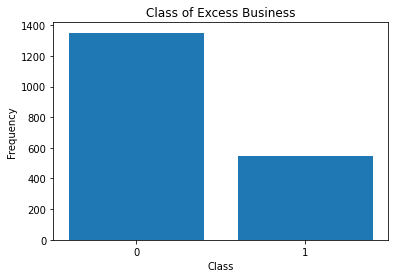

In [43]:
plt.bar(dict(Counter(y_e)).keys(), dict(Counter(y_e)).values())
plt.xticks(np.arange(2))
plt.title('Class of Excess Business')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


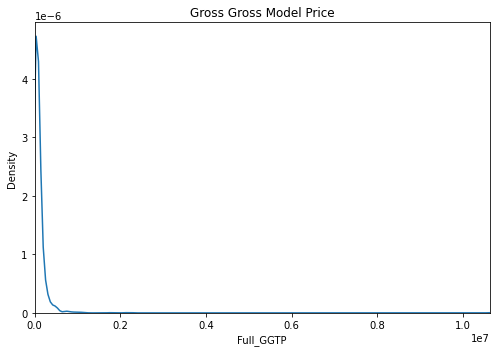

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


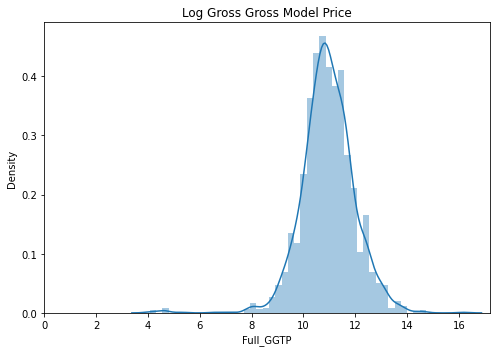

In [44]:
# Looking at the skewness of Full_GGTP
plt.figure(figsize=(7,5))
sns.distplot(X_e.Full_GGTP, hist=False)
plt.title(f"Gross Gross Model Price")
plt.xlim(0, X_e.Full_GGTP.max()+1)
plt.tight_layout()
plt.show()

# Log transform
plt.figure(figsize=(7,5))
sns.distplot(np.log1p(X_e.Full_GGTP))
plt.title(f"Log Gross Gross Model Price")
plt.xlim(0, np.log1p(X_e.Full_GGTP).max()+1)
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


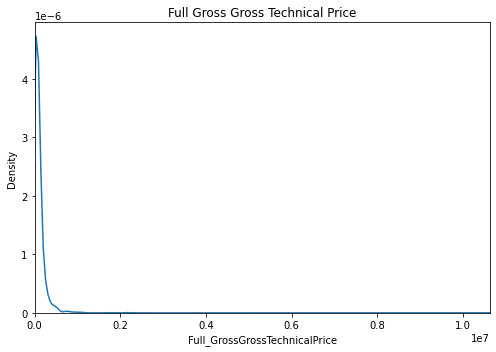

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


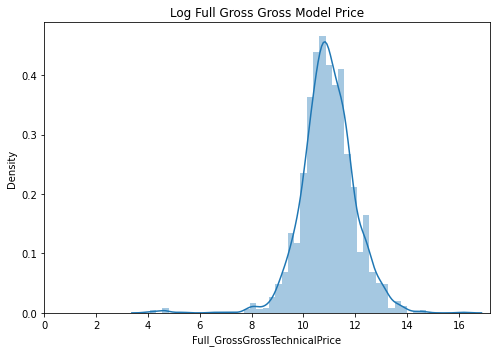

In [45]:
# Looking at the skewness of Full_GGTP
plt.figure(figsize=(7,5))
sns.distplot(X_e.Full_GrossGrossTechnicalPrice, hist=False)
plt.title(f"Full Gross Gross Technical Price")
plt.xlim(0, X_e.Full_GrossGrossTechnicalPrice.max()+1)
plt.tight_layout()
plt.show()

# Log transform
plt.figure(figsize=(7,5))
sns.distplot(np.log1p(X_e.Full_GrossGrossTechnicalPrice))
plt.title(f"Log Full Gross Gross Model Price")
plt.xlim(0, np.log1p(X_e.Full_GrossGrossTechnicalPrice).max()+1)
plt.tight_layout()
plt.show()

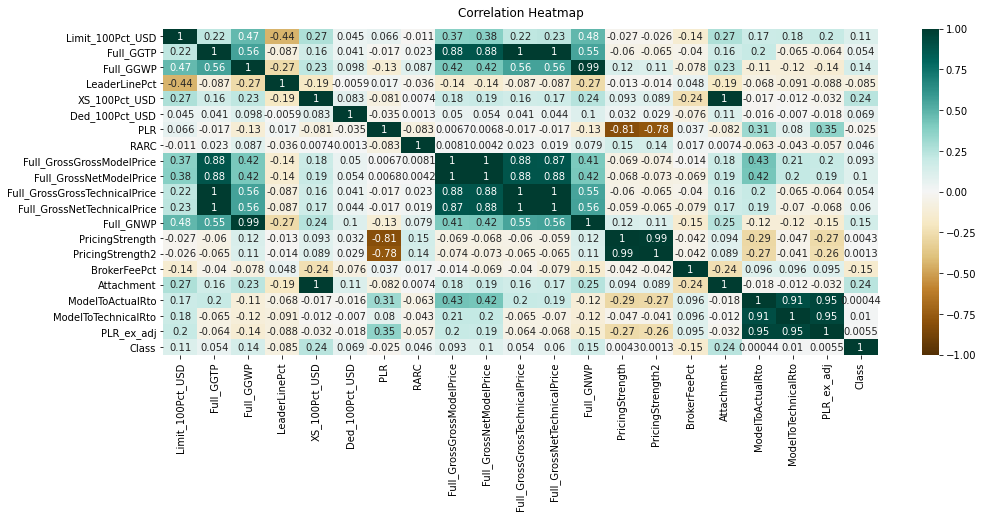

In [46]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(X_e.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [47]:
# report_e = sv.analyze(X_e_scaled, 'Class')
# report_e.show_html(filepath='D&O WW Excess.html',
#                  open_browser=True,
#                  layout='vertical',
#                  scale=None)

### Changing the data into log-transform

In [48]:
# Primary business
X_p['Full_GrossGrossModelPrice'] = np.log1p(X_p.Full_GrossGrossModelPrice)
X_p['Full_GrossNetModelPrice'] = np.log1p(X_p.Full_GrossNetModelPrice)

# Excess business
X_e['Full_GrossGrossModelPrice'] = np.log1p(X_e.Full_GrossGrossModelPrice)
X_e['Full_GrossNetModelPrice'] = np.log1p(X_e.Full_GrossNetModelPrice)
X_e['Full_GrossGrossTechnicalPrice'] = np.log1p(X_e.Full_GrossGrossTechnicalPrice)
X_e['Full_GrossNetTechnicalPrice'] = np.log1p(X_e.Full_GrossNetTechnicalPrice)
X_e['Ded_100Pct_USD'] = np.log1p(X_e.Ded_100Pct_USD)
X_e['Full_GGTP'] = np.log1p(X_e.Full_GGTP)
X_e['RARC'] = np.log1p(X_e.RARC)

In [49]:
# Dropping highly correlated features
correlated_features = set()
correlation_matrix = X_p.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
print(correlated_features)
X_p.drop(labels=correlated_features, axis=1, inplace=True)
X_p.head()

{'ModelToTechnicalRto', 'Full_GrossNetModelPrice', 'Full_GNWP', 'PLR_ex_adj', 'PricingStrength2', 'Attachment', 'Full_GGWP', 'Full_GrossNetTechnicalPrice', 'Full_GrossGrossTechnicalPrice'}


,PlacingBasis,SubClass,StatsMinorClassCode,Territory,Limit_100Pct_USD,Full_GGTP,LeaderStatus,LeaderLinePct,BrokerUltimateName,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,PLR_band,PLR_band_ex_adj,Class
0,OM,SPECIALTY_/_FINANCE_/_PROFESSIONAL_SERVI,DP,UNITED_KINGDOM,12356000.0,61780.0,LEAD,50.0,AON,123560.0,0.3228,0.00,10.160582,2.200000,20.000000,0.190282,Lower_quantile,Lower_Middle,0.0
1,OM,SPECIALTY_/_FINANCE_/_PROFESSIONAL_SERVI,DP,UNITED_KINGDOM,12356000.0,30890.0,LEAD,100.0,AON,0.0,0.4849,0.00,9.253574,1.440000,20.000000,0.234722,Lower_quantile,Lower_Middle,0.0
2,OM,PROPERTY_/_REAL_ESTATE,DN,USA_VIRGIN_ISLANDS,1000000.0,5000.0,LEAD,100.0,R_K_HARRISON,5000.0,0.6540,-0.05,8.438799,1.140000,25.000000,0.810877,Upper_Middle,Upper_Quantile,0.0
3,OM,SPECIALTY_/_FINANCE_/_PROFESSIONAL_SERVI,DP,DISTRICT_OF_COLUMBIA,10000000.0,99422.0,FOLLOW,25.0,WILLIS,250000.0,0.3400,0.00,9.620516,2.100008,35.700369,0.072178,Lower_quantile,Lower_quantile,0.0
4,OM,PROPERTY_/_REAL_ESTATE,DN,USA_VIRGIN_ISLANDS,5000000.0,15000.0,LEAD,100.0,R_K_HARRISON,25000.0,0.7130,0.00,9.033245,1.000000,25.000000,0.558400,Upper_Quantile,Upper_Middle,0.0


In [50]:
print(correlated_features)

{'ModelToTechnicalRto', 'Full_GrossNetModelPrice', 'Full_GNWP', 'PLR_ex_adj', 'PricingStrength2', 'Attachment', 'Full_GGWP', 'Full_GrossNetTechnicalPrice', 'Full_GrossGrossTechnicalPrice'}


In [51]:
correlated_features = set()
correlation_matrix = X_e.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
print(correlated_features)
X_e.drop(labels=correlated_features, axis=1, inplace=True)
X_e.head()

{'ModelToTechnicalRto', 'Full_GrossNetModelPrice', 'Full_GNWP', 'PricingStrength2', 'Attachment', 'PLR_ex_adj', 'Full_GrossNetTechnicalPrice', 'Full_GrossGrossTechnicalPrice'}


,PlacingBasis,SubClass,StatsMinorClassCode,Territory,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderStatus,LeaderLinePct,BrokerUltimateName,...,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,PLR_band,PLR_band_ex_adj,Class
0,OM,UTILITIES,DT,ITALY,3.369512e+07,10.449830,33695.118626,FOLLOW,50.0,AON,...,0.000000,0.7037,-0.061875,10.354396,0.97561,8.000000,0.931700,Upper_Middle,Upper_Quantile,1.0
1,OM,TELECOMMUNICATIONS,DQ,UNITED_KINGDOM,2.000000e+07,11.512935,119023.000000,FOLLOW,50.0,MARSH,...,0.000000,0.5990,-0.051293,11.108859,1.19023,0.820018,0.560892,Lower_Middle,Upper_Middle,1.0
2,OM,OIL_AND_GAS,DQ,WESTERN_AUSTRALIA,6.885100e+06,9.302725,8751.557351,LEAD,100.0,AON,...,0.000000,0.8940,-0.051293,9.374357,0.79800,12.968385,1.346199,Upper_Quantile,Upper_Quantile,0.0
3,OM,INSURANCE_BROKERS,DP,SOUTH_AFRICA,5.755396e+05,8.144189,3442.310182,LEAD,100.0,SAFEONLINE,...,8.658067,0.6865,0.000000,0.000000,1.00000,25.000160,0.000000,Upper_Middle,Lower_quantile,0.0
4,OM,RETAILERS,DT,NETHERLANDS,1.000000e+08,11.512935,100000.000000,FOLLOW,25.0,WILLIS,...,0.000000,0.7820,0.000000,11.090324,1.00000,0.017750,0.655330,Upper_Quantile,Upper_Middle,1.0


In [52]:
# Data scaling
# Scale only columns that have values greater than 1
to_scale = [col for col in X_p.columns[X_p.dtypes != 'object'] if X_p[col].max() > 1]
mms = MinMaxScaler()
scaled = mms.fit_transform(X_p[to_scale])
scaled = pd.DataFrame(scaled, columns=to_scale)

X_p_scaled = X_p.copy()
# Replace original columns with scaled ones
for col in scaled:
    X_p_scaled[col] = scaled[col]
    
X_p_scaled.head()

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,Limit_100Pct_USD,Full_GGTP,LeaderStatus,LeaderLinePct,BrokerUltimateName,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,PLR_band,PLR_band_ex_adj,Class
0,OM,SPECIALTY_/_FINANCE_/_PROFESSIONAL_SERVI,DP,UNITED_KINGDOM,0.245383,0.084733,LEAD,0.461207,AON,0.012356,0.3228,0.263959,0.700190,0.416667,0.596223,0.052633,Lower_quantile,Lower_Middle,0.0
1,OM,SPECIALTY_/_FINANCE_/_PROFESSIONAL_SERVI,DP,UNITED_KINGDOM,0.245383,0.042298,LEAD,1.000000,AON,0.000000,0.4849,0.263959,0.637686,0.258333,0.596223,0.064925,Lower_quantile,Lower_Middle,0.0
2,OM,PROPERTY_/_REAL_ESTATE,DN,USA_VIRGIN_ISLANDS,0.017739,0.006731,LEAD,1.000000,R_K_HARRISON,0.000500,0.6540,0.238579,0.581538,0.195833,0.724812,0.224291,Upper_Middle,Upper_Quantile,0.0
3,OM,SPECIALTY_/_FINANCE_/_PROFESSIONAL_SERVI,DP,DISTRICT_OF_COLUMBIA,0.198154,0.136443,FOLLOW,0.191810,WILLIS,0.025000,0.3400,0.263959,0.662973,0.395835,1.000000,0.019965,Lower_quantile,Lower_quantile,0.0
4,OM,PROPERTY_/_REAL_ESTATE,DN,USA_VIRGIN_ISLANDS,0.097923,0.020469,LEAD,1.000000,R_K_HARRISON,0.002500,0.7130,0.263959,0.622503,0.166667,0.724812,0.154455,Upper_Quantile,Upper_Middle,0.0


In [53]:
# Data scaling
# Scale only columns that have values greater than 1
to_scale = [col for col in X_e.columns[X_e.dtypes != 'object'] if X_e[col].max() > 1]
mms = MinMaxScaler()
scaled = mms.fit_transform(X_e[to_scale])
scaled = pd.DataFrame(scaled, columns=to_scale)

X_e_scaled = X_e.copy()
# Replace original columns with scaled ones
for col in scaled:
    X_e_scaled[col] = scaled[col]
    
X_e_scaled.head()

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderStatus,LeaderLinePct,BrokerUltimateName,...,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,PLR_band,PLR_band_ex_adj,Class
0,OM,UTILITIES,DT,ITALY,0.092146,0.526835,0.014891,FOLLOW,0.489796,AON,...,0.000000,0.319082,0.282314,0.671819,0.161585,0.148498,0.135392,Upper_Middle,Upper_Quantile,1.0
1,OM,TELECOMMUNICATIONS,DQ,UNITED_KINGDOM,0.054043,0.614651,0.052705,FOLLOW,0.489796,MARSH,...,0.000000,0.262915,0.287047,0.720771,0.206298,0.015590,0.081507,Lower_Middle,Upper_Middle,1.0
2,OM,OIL_AND_GAS,DQ,WESTERN_AUSTRALIA,0.017555,0.432081,0.003838,LEAD,1.000000,AON,...,0.000000,0.421168,0.287047,0.608232,0.124583,0.240468,0.195626,Upper_Quantile,Upper_Quantile,0.0
3,OM,INSURANCE_BROKERS,DP,SOUTH_AFRICA,0.000000,0.336383,0.001485,LEAD,1.000000,SAFEONLINE,...,0.472723,0.309855,0.309986,0.000000,0.166667,0.463187,0.000000,Upper_Middle,Lower_quantile,0.0
4,OM,RETAILERS,DT,NETHERLANDS,0.276621,0.614651,0.044275,FOLLOW,0.234694,WILLIS,...,0.000000,0.361086,0.309986,0.719568,0.166667,0.000740,0.095231,Upper_Quantile,Upper_Middle,1.0


In [54]:
X_encoded_p = pd.get_dummies(X_p_scaled, columns = ['PlacingBasis', 'SubClass', 'StatsMinorClassCode', 
                                        'Territory', 'LeaderStatus', 'BrokerUltimateName', 'PLR_band', 
                                             'PLR_band_ex_adj'])
X_encoded_e = pd.get_dummies(X_e_scaled, columns = ['PlacingBasis', 'SubClass', 'StatsMinorClassCode', 
                                        'Territory', 'LeaderStatus', 'BrokerUltimateName', 'PLR_band', 
                                            'PLR_band_ex_adj'])
X_encoded_p.drop('Class', axis=1, inplace=True)
X_encoded_e.drop('Class', axis=1, inplace=True)

In [55]:
len(X_encoded_p.columns)

139

### XGBoost

#### Primary business

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded_p, y_p, test_size=0.2, 
                                                    stratify = y_p, random_state=42)
# dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_encoded.columns)
# dtest = xgb.DMatrix(X_test, y_test, feature_names=X_encoded.columns)

In [57]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [4, 5, 6]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_train, y_train, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test, y_test)])

In [58]:
# print(optimal_params.best_params_)

In [59]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0.1,
                          learning_rate=0.05,
                          max_depth=4,
                          reg_lambda=10,
                          scale_pos_weight=6,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5)
clf_xgb.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.48757
[1]	validation_0-aucpr:0.70051
[2]	validation_0-aucpr:0.73257
[3]	validation_0-aucpr:0.70633
[4]	validation_0-aucpr:0.75927
[5]	validation_0-aucpr:0.77488
[6]	validation_0-aucpr:0.75631
[7]	validation_0-aucpr:0.75616
[8]	validation_0-aucpr:0.73634


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-aucpr:0.73149
[10]	validation_0-aucpr:0.73148
[11]	validation_0-aucpr:0.73473
[12]	validation_0-aucpr:0.73510
[13]	validation_0-aucpr:0.75065
[14]	validation_0-aucpr:0.75613
[15]	validation_0-aucpr:0.75355


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=6, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [60]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.774884
Best iteration: 5


Top 10 most important features
Feature: PricingStrength 
 Score: 0.03221
Feature: Territory_USA_VIRGIN_ISLANDS 
 Score: 0.03372
Feature: Territory_UNITED_KINGDOM 
 Score: 0.03497
Feature: Full_GGTP 
 Score: 0.03510
Feature: SubClass_SUPPORT_SERVICES 
 Score: 0.03586
Feature: Full_GrossGrossModelPrice 
 Score: 0.04192
Feature: BrokerUltimateName_JOHN_HOLMAN_&_SONS_LTD 
 Score: 0.04325
Feature: SubClass_RETAILERS 
 Score: 0.06974
Feature: Limit_100Pct_USD 
 Score: 0.07401
Feature: BrokerFeePct 
 Score: 0.08859


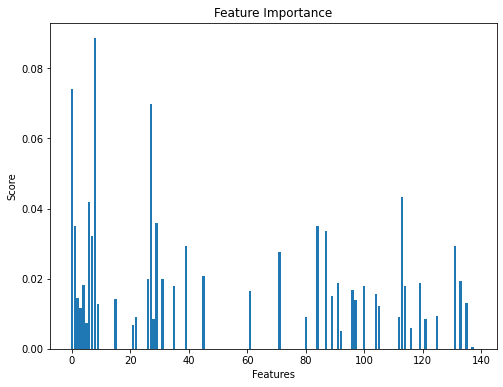

In [61]:
# Feature of importance
importance = clf_xgb.feature_importances_

# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))

feature = np.argsort(importance)[-10:]
score = importance[np.argsort(importance)[-10:]]

fs = zip(feature,score)
imp = tuple(fs)

print('Top 10 most important features')
for i in range(len(imp)):
    print('Feature:', X_train.columns[imp[i][0]], '\n Score: %.5f' % imp[i][1])

# plot feature importance
plt.figure(figsize=(8,6))
plt.bar([x for x in range(len(importance))], importance)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Score')
plt.show()

In [62]:
# Dropping unimportant features
drop_cols = X_train.columns[np.where(importance == 0)]
X_encoded_p.drop(drop_cols, axis=1, inplace=True)

In [63]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 83.13%
ROC AUC: 0.8060439560439561
              precision    recall  f1-score   support

         0.0       0.95      0.84      0.89        70
         1.0       0.48      0.77      0.59        13

    accuracy                           0.83        83
   macro avg       0.71      0.81      0.74        83
weighted avg       0.88      0.83      0.85        83



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.9296703296703297
Precision-Recall AUC: 0.7749936166863094


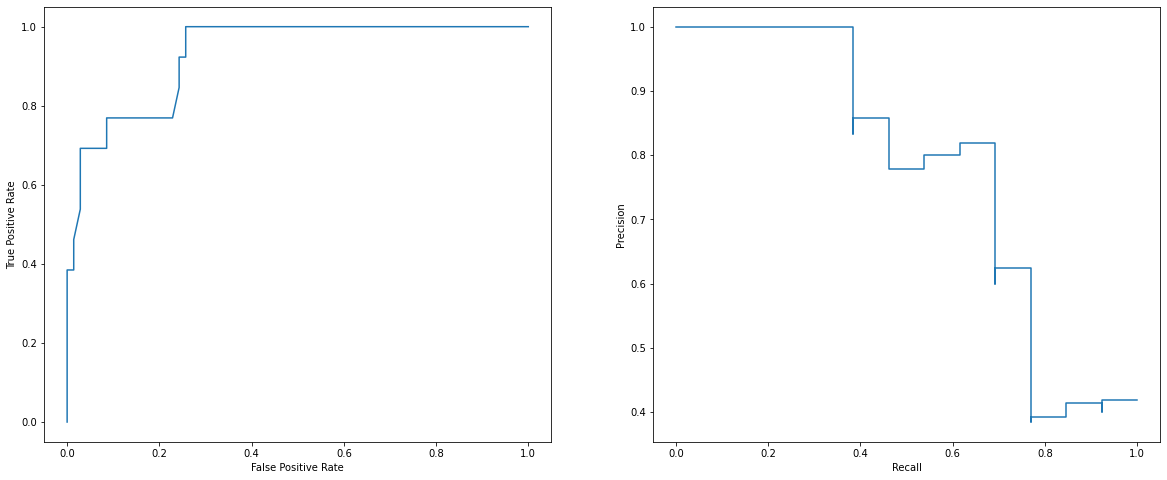

In [64]:
y_prob = clf_xgb.predict_proba(X_test)
probabilities = y_prob[:,1]

fpr_p, tpr_p, _ = roc_curve(y_test, probabilities)
roc_display_p = RocCurveDisplay(fpr=fpr_p, tpr=tpr_p)
roc_auc_p = auc(fpr_p, tpr_p)

prec_p, recall_p, _ = precision_recall_curve(y_test, probabilities)
pr_auc_p = auc(recall_p, prec_p)
pr_display_p = PrecisionRecallDisplay(precision=prec_p, recall=recall_p)

print('ROC AUC:', roc_auc_p)
print('Precision-Recall AUC:', pr_auc_p)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_p.plot(ax=ax1)
pr_display_p.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


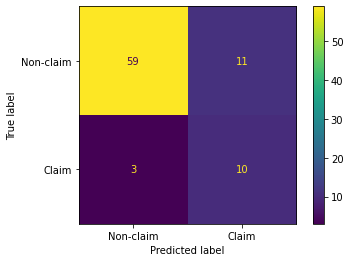

In [65]:
plot_confusion_matrix(clf_xgb, X_test, y_test, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:09:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'BrokerFeePct': 1, 'StatsMinorClassCode_FY': 1, 'PricingStrength': 1, 'SubClass_PROPERTY_/_REAL_ESTATE': 1, 'Limit_100Pct_USD': 2, 'Ded_100Pct_USD': 1, 'Full_GGTP': 1, 'Territory_NEVADA': 1, 'PLR_band_Lower_Middle': 1, 'BrokerUltimateName_LOCKTON': 1, 'PLR': 1}
gain:  {'BrokerFeePct': 114.031143, 'StatsMinorClassCode_FY': 12.9543304, 'PricingStrength': 11.515152, 'SubClass_PROPERTY_/_REAL_ESTATE': 8.45111847, 'Limit_100Pct_USD': 6.32436037, 'Ded_100Pct_USD': 2.47063732, 'Full_GGTP': 34.1252785, 'Territory_NEVADA': 14.5447693, 'PLR_band_Lower_Middle': 15.7469635, 'BrokerUltimateName_LOCKTON': 3.35209036, 'PLR': 1.6695652}
cover:  {'BrokerFeePct': 146.25, 'StatsMinorClassCode_FY': 67.5, 'PricingStrength': 62.75, 'SubClass_PROPERTY

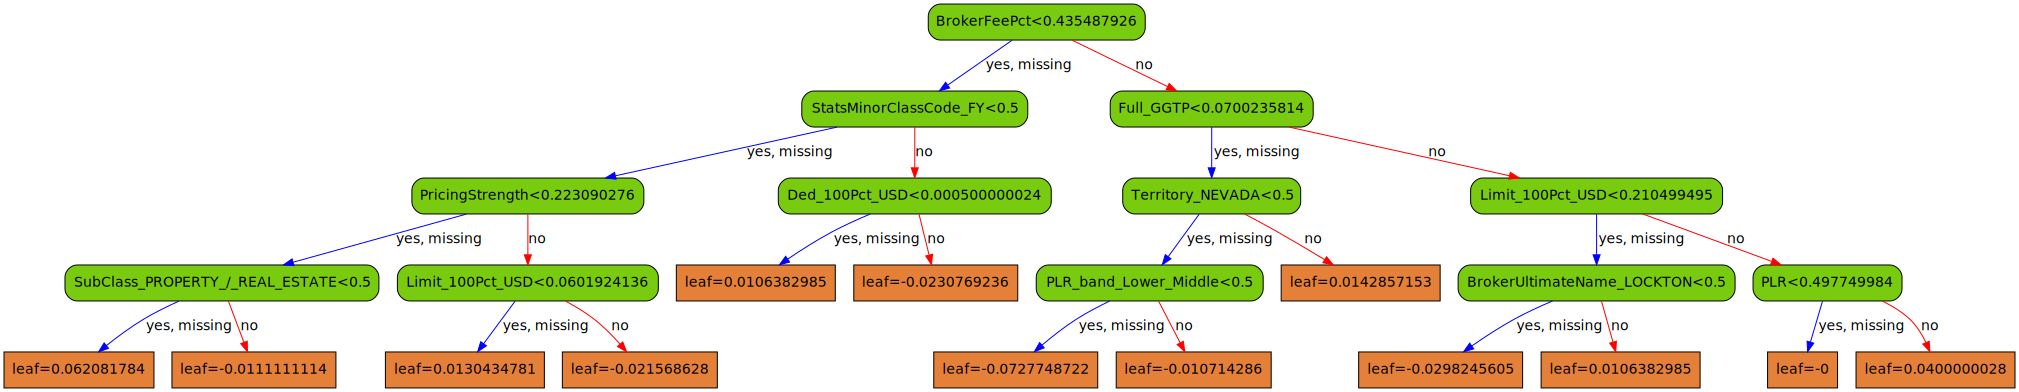

In [66]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0.1,
                          learning_rate=0.05,
                          max_depth=4,
                          reg_lambda=10,
                          scale_pos_weight=6,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_train, y_train)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


#### Excess business

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded_e, y_e, test_size=0.2, 
                                                    stratify = y_e, random_state=42)
# dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_encoded.columns)
# dtest = xgb.DMatrix(X_test, y_test, feature_names=X_encoded.columns)

In [68]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_train, y_train, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test, y_test)])

In [69]:
# print(optimal_params.best_params_)

In [70]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=1,
                          learning_rate=0.1,
                          max_depth=6,
                          reg_lambda=1,
                          scale_pos_weight=3,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5
                           )
clf_xgb.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.37276
[1]	validation_0-aucpr:0.46948
[2]	validation_0-aucpr:0.45699
[3]	validation_0-aucpr:0.45780


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[4]	validation_0-aucpr:0.45728
[5]	validation_0-aucpr:0.48928
[6]	validation_0-aucpr:0.50653
[7]	validation_0-aucpr:0.51934
[8]	validation_0-aucpr:0.51921
[9]	validation_0-aucpr:0.52686
[10]	validation_0-aucpr:0.54107
[11]	validation_0-aucpr:0.54703
[12]	validation_0-aucpr:0.54770
[13]	validation_0-aucpr:0.54850
[14]	validation_0-aucpr:0.56256
[15]	validation_0-aucpr:0.56125
[16]	validation_0-aucpr:0.56351
[17]	validation_0-aucpr:0.56861
[18]	validation_0-aucpr:0.57007
[19]	validation_0-aucpr:0.57408
[20]	validation_0-aucpr:0.56504
[21]	validation_0-aucpr:0.56890
[22]	validation_0-aucpr:0.57293
[23]	validation_0-aucpr:0.56850
[24]	validation_0-aucpr:0.56078
[25]	validation_0-aucpr:0.56640
[26]	validation_0-aucpr:0.56666
[27]	validation_0-aucpr:0.56490
[28]	validation_0-aucpr:0.56245
[29]	validation_0-aucpr:0.56629


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [71]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.574076
Best iteration: 19


Top 10 most important features
Feature: SubClass_PHARMACEUTICALS_/_BIO-TECHNOLOGY 
 Score: 0.01961
Feature: SubClass_MINING 
 Score: 0.01965
Feature: Territory_SPAIN 
 Score: 0.02003
Feature: Territory_JAPAN 
 Score: 0.02024
Feature: SubClass_OIL_AND_GAS 
 Score: 0.02030
Feature: Full_GGWP 
 Score: 0.02079
Feature: BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO. 
 Score: 0.02172
Feature: BrokerUltimateName_WILLIS 
 Score: 0.02183
Feature: SubClass_ELECTRONIC_HARDWARE 
 Score: 0.02952
Feature: Territory_SOUTH_KOREA 
 Score: 0.03325


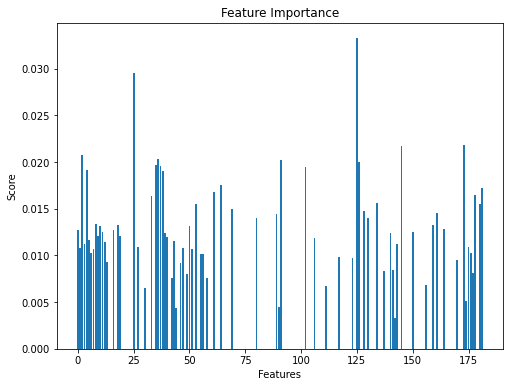

In [72]:
# Feature of importance
importance = clf_xgb.feature_importances_

# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))

feature = np.argsort(importance)[-10:]
score = importance[np.argsort(importance)[-10:]]

fs = zip(feature,score)
imp = tuple(fs)

print('Top 10 most important features')
for i in range(len(imp)):
    print('Feature:', X_train.columns[imp[i][0]], '\n Score: %.5f' % imp[i][1])

# plot feature importance
plt.figure(figsize=(8,6))
plt.bar([x for x in range(len(importance))], importance)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Score')
plt.show()

In [73]:
# Dropping unimportant features
drop_cols = X_train.columns[np.where(importance == 0)]
X_encoded_e.drop(drop_cols, axis=1, inplace=True)

In [74]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 65.53%
ROC AUC: 0.6577441077441077
              precision    recall  f1-score   support

         0.0       0.83      0.65      0.73       270
         1.0       0.44      0.66      0.53       110

    accuracy                           0.66       380
   macro avg       0.63      0.66      0.63       380
weighted avg       0.71      0.66      0.67       380



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.7433670033670032
Precision-Recall AUC: 0.5738828188764893


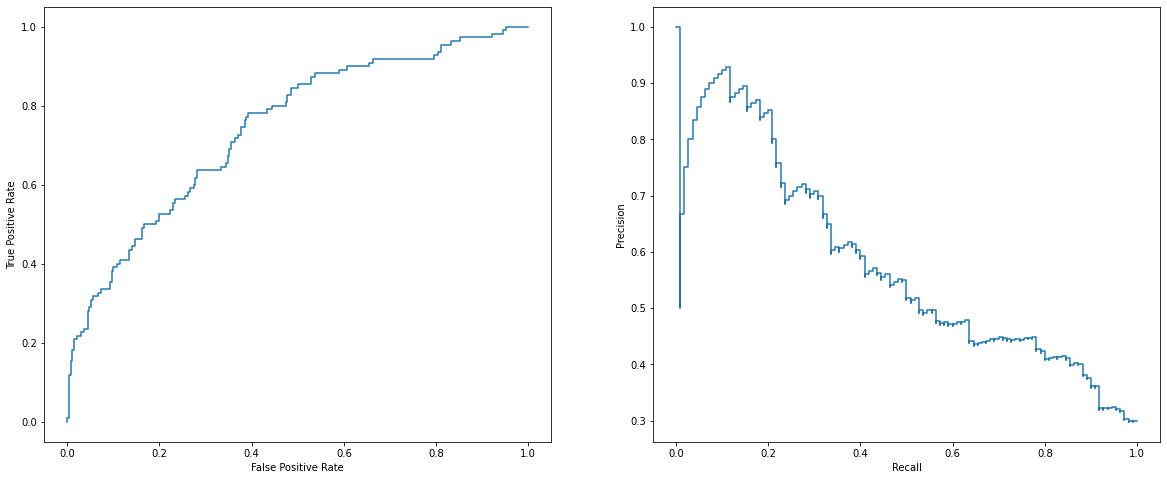

In [75]:
y_prob = clf_xgb.predict_proba(X_test)
probabilities = y_prob[:,1]

fpr_e, tpr_e, _ = roc_curve(y_test, probabilities)
roc_display_e = RocCurveDisplay(fpr=fpr_e, tpr=tpr_e)
roc_auc_e = auc(fpr_e, tpr_e)

prec_e, recall_e, _ = precision_recall_curve(y_test, probabilities)
pr_auc_e = auc(recall_e, prec_e)
pr_display_e = PrecisionRecallDisplay(precision=prec_e, recall=recall_e)

print('ROC AUC:', roc_auc_e)
print('Precision-Recall AUC:', pr_auc_e)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_e.plot(ax=ax1)
pr_display_e.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


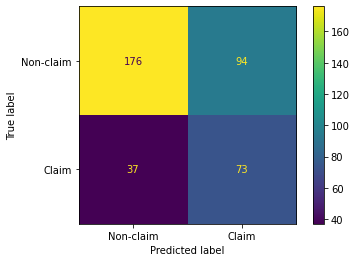

In [76]:
plot_confusion_matrix(clf_xgb, X_test, y_test, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:09:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'Full_GGTP': 2, 'XS_100Pct_USD': 3, 'Full_GGWP': 3, 'Full_GrossGrossModelPrice': 4, 'PLR_band_Lower_Middle': 3, 'Ded_100Pct_USD': 7, 'Limit_100Pct_USD': 3, 'PLR': 3, 'PLR_band_ex_adj_Lower_Middle': 1, 'BrokerFeePct': 3, 'SubClass_TELECOMMUNICATIONS': 1, 'ModelToActualRto': 4, 'RARC': 2, 'StatsMinorClassCode_EP': 1, 'Territory_CALIFORNIA': 1, 'SubClass_OIL_AND_GAS': 1, 'Territory_GERMANY': 1, 'Territory_NETHERLANDS': 1, 'PricingStrength': 2}
gain:  {'Full_GGTP': 71.358069985, 'XS_100Pct_USD': 31.562506966666664, 'Full_GGWP': 10.392675736666666, 'Full_GrossGrossModelPrice': 9.8237681425, 'PLR_band_Lower_Middle': 9.536966, 'Ded_100Pct_USD': 11.613497375714287, 'Limit_100Pct_USD': 4.30888477, 'PLR': 5.356916426666666, 'PLR_band_ex_a

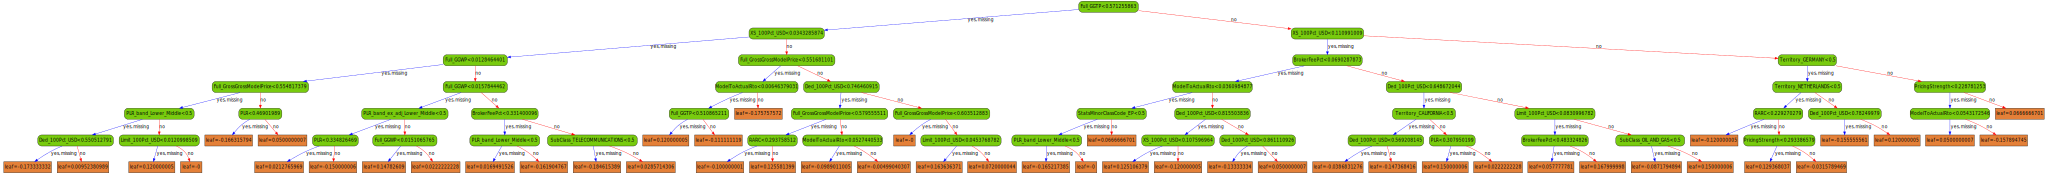

In [77]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                        gamma=1,
                          learning_rate=0.1,
                          max_depth=6,
                          reg_lambda=1,
                          scale_pos_weight=3,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_train, y_train)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


## Splitting the Dataset into Training and Testing

In [78]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_encoded_p, y_p, test_size=0.2, 
                                                    stratify = y_p, random_state=42)

X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_encoded_e, y_e, test_size=0.2, 
                                                    stratify = y_e, random_state=42)

In [79]:
print(X_encoded_p.columns)

Index(['Limit_100Pct_USD', 'Full_GGTP', 'LeaderLinePct', 'Ded_100Pct_USD',
       'PLR', 'RARC', 'Full_GrossGrossModelPrice', 'PricingStrength',
       'BrokerFeePct', 'ModelToActualRto',
       'SubClass_COMPUTER_SERVICES_/_SUPPORT', 'SubClass_INSURANCE_BROKERS',
       'SubClass_LEISURE_/_HOTELS_/_ENTERTAINMENT',
       'SubClass_PROPERTY_/_REAL_ESTATE', 'SubClass_RETAILERS',
       'SubClass_SPECIALTY_/_FINANCE_/_PROFESSIONAL_SERVI',
       'SubClass_SUPPORT_SERVICES', 'SubClass_TRANSPORT',
       'StatsMinorClassCode_DQ', 'StatsMinorClassCode_FY',
       'Territory_BRITISH_COLUMBIA', 'Territory_ITALY', 'Territory_NEVADA',
       'Territory_SWITZERLAND', 'Territory_UNITED_KINGDOM',
       'Territory_USA_VIRGIN_ISLANDS', 'Territory_VIRGIN_ISLANDS_(BRITISH)',
       'Territory_WISCONSIN', 'Territory_WORLDWIDE', 'LeaderStatus_LEAD',
       'BrokerUltimateName_AON',
       'BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.',
       'BrokerUltimateName_COGENT_RESOURCES_LIMITED',
       'Broke

## Random Over Sampler

In [80]:
ros = RandomOverSampler(sampling_strategy = 'minority', random_state=42)

# Primary business
X_train_res_p, y_train_res_p = ros.fit_resample(X_train_p, y_train_p)

# Excess business
X_train_res_e, y_train_res_e = ros.fit_resample(X_train_e, y_train_e)

### XGBoost (ROS)

#### Primary business

In [81]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_train_res_p, y_train_res_p, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

In [82]:
# print(optimal_params.best_params_)

In [83]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0,
                          learning_rate=0.1,
                          max_depth=6,
                          reg_lambda=1,
                          scale_pos_weight=3,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5)
clf_xgb.fit(X_train_res_p, y_train_res_p, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

[0]	validation_0-aucpr:0.57885
[1]	validation_0-aucpr:0.70961
[2]	validation_0-aucpr:0.68383
[3]	validation_0-aucpr:0.67220
[4]	validation_0-aucpr:0.72836
[5]	validation_0-aucpr:0.74116
[6]	validation_0-aucpr:0.74143
[7]	validation_0-aucpr:0.76026
[8]	validation_0-aucpr:0.77885


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-aucpr:0.76994
[10]	validation_0-aucpr:0.78520
[11]	validation_0-aucpr:0.77292
[12]	validation_0-aucpr:0.79524
[13]	validation_0-aucpr:0.78672
[14]	validation_0-aucpr:0.78033
[15]	validation_0-aucpr:0.77063
[16]	validation_0-aucpr:0.76907
[17]	validation_0-aucpr:0.76983
[18]	validation_0-aucpr:0.75699
[19]	validation_0-aucpr:0.75385
[20]	validation_0-aucpr:0.76397
[21]	validation_0-aucpr:0.75545


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [84]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.795245
Best iteration: 12


In [85]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_p)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_p, predictions)
report = classification_report(y_test_p, predictions)
roc_auc = roc_auc_score(y_test_p, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 85.54%
ROC AUC: 0.8203296703296704
              precision    recall  f1-score   support

         0.0       0.95      0.87      0.91        70
         1.0       0.53      0.77      0.62        13

    accuracy                           0.86        83
   macro avg       0.74      0.82      0.77        83
weighted avg       0.89      0.86      0.87        83



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.9131868131868132
Precision-Recall AUC: 0.7951560252713352


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


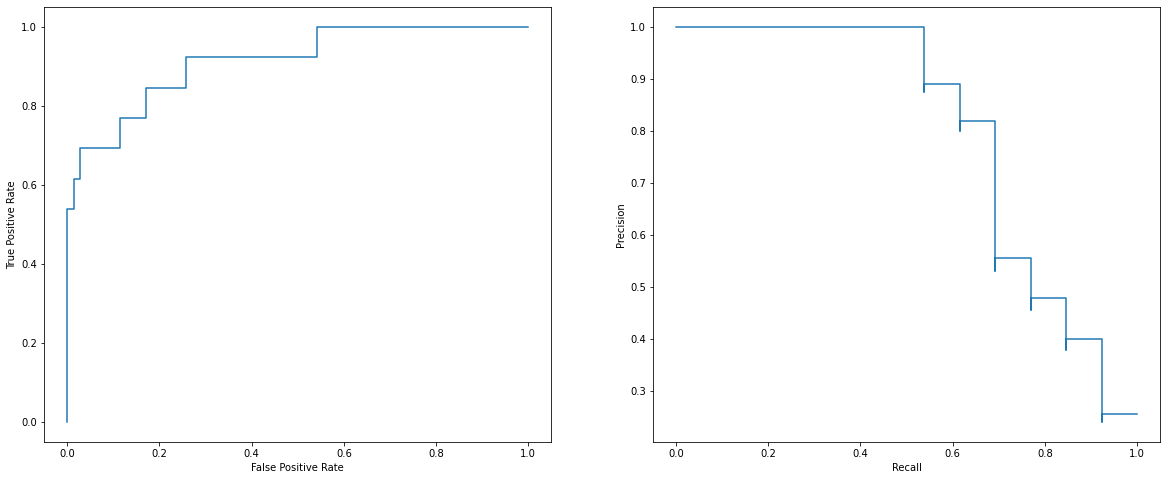

In [86]:
y_prob = clf_xgb.predict_proba(X_test_p)
probabilities = y_prob[:,1]

fpr_ros_p, tpr_ros_p, _ = roc_curve(y_test_p, probabilities)
roc_display_ros_p = RocCurveDisplay(fpr=fpr_ros_p, tpr=tpr_ros_p)
roc_auc_ros_p = auc(fpr_ros_p, tpr_ros_p)

prec_ros_p, recall_ros_p, _ = precision_recall_curve(y_test_p, probabilities)
pr_auc_ros_p = auc(recall_ros_p, prec_ros_p)
pr_display_ros_p = PrecisionRecallDisplay(precision=prec_ros_p, recall=recall_ros_p)

print('ROC AUC:', roc_auc_ros_p)
print('Precision-Recall AUC:', pr_auc_ros_p)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_ros_p.plot(ax=ax1)
pr_display_ros_p.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


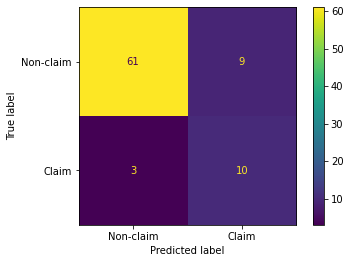

In [87]:
plot_confusion_matrix(clf_xgb, X_test_p, y_test_p, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:09:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'Full_GGTP': 3, 'BrokerFeePct': 2, 'ModelToActualRto': 1, 'PLR_band_Lower_Middle': 1, 'BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.': 1, 'PLR_band_ex_adj_Lower_Middle': 1, 'Territory_USA_VIRGIN_ISLANDS': 1, 'PLR': 1, 'PricingStrength': 1, 'Territory_BRITISH_COLUMBIA': 1, 'StatsMinorClassCode_FY': 1, 'LeaderLinePct': 1, 'Ded_100Pct_USD': 1}
gain:  {'Full_GGTP': 59.48866840333333, 'BrokerFeePct': 50.113376599999995, 'ModelToActualRto': 15.5685501, 'PLR_band_Lower_Middle': 40.0056915, 'BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.': 42.0108414, 'PLR_band_ex_adj_Lower_Middle': 10.2001381, 'Territory_USA_VIRGIN_ISLANDS': 27.34235, 'PLR': 21.9258919, 'PricingStrength': 36.4886475, 'Territory_BRITISH_COLUMBIA': 19.2299194, 'StatsMinorCl

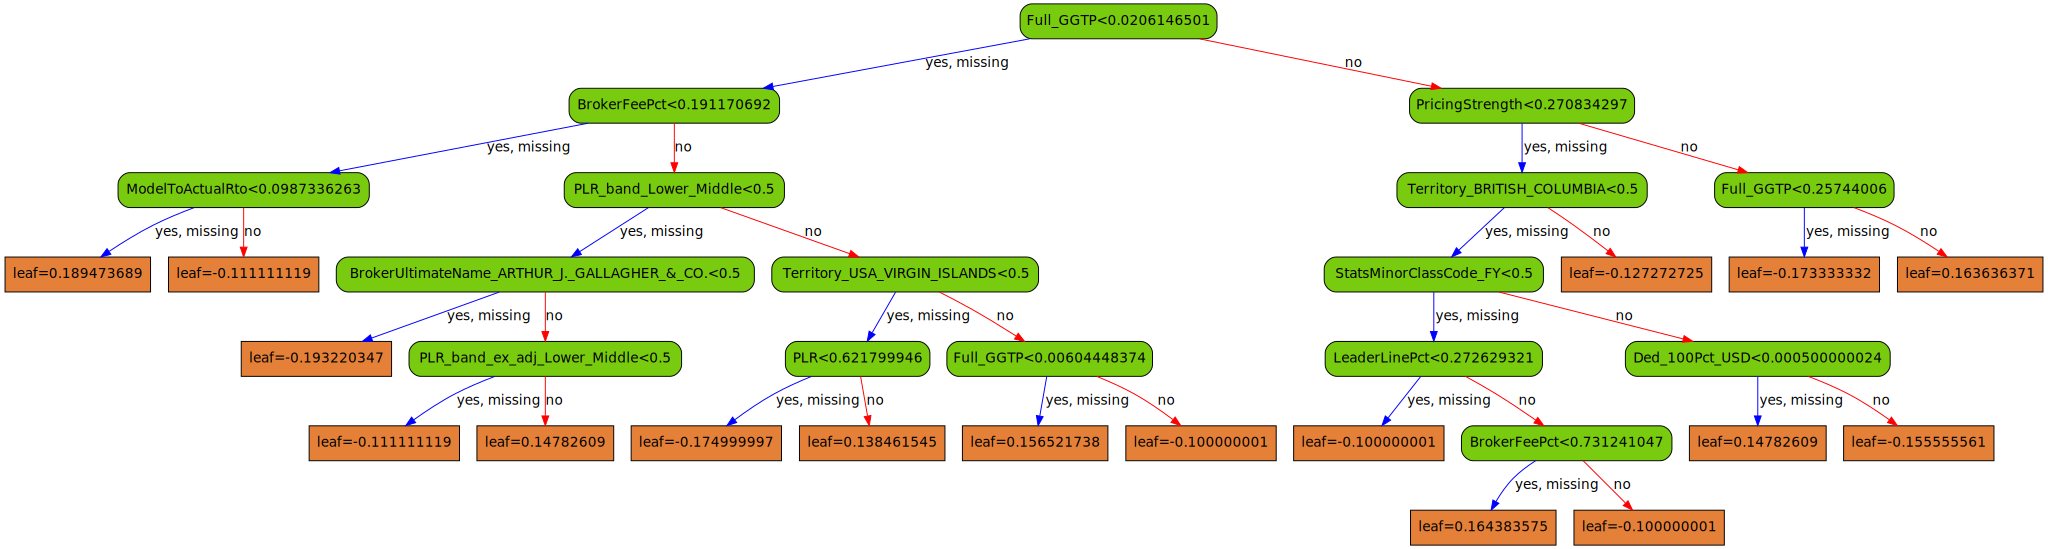

In [88]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                         gamma=0,
                          learning_rate=0.1,
                          max_depth=6,
                          reg_lambda=1,
                          scale_pos_weight=3,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_train_res_p, y_train_res_p)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


#### Excess business

In [89]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_train_res_e, y_train_res_e, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

In [90]:
# print(optimal_params.best_params_)

In [91]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0.1,
                          learning_rate=0.1,
                          max_depth=6,
                          reg_lambda=1,
                          scale_pos_weight=3,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5
                           )
clf_xgb.fit(X_train_res_e, y_train_res_e, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

[0]	validation_0-aucpr:0.42247
[1]	validation_0-aucpr:0.40333
[2]	validation_0-aucpr:0.42513


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[3]	validation_0-aucpr:0.43477
[4]	validation_0-aucpr:0.43747
[5]	validation_0-aucpr:0.44201
[6]	validation_0-aucpr:0.47953
[7]	validation_0-aucpr:0.48847
[8]	validation_0-aucpr:0.49564
[9]	validation_0-aucpr:0.49053
[10]	validation_0-aucpr:0.49904
[11]	validation_0-aucpr:0.50432
[12]	validation_0-aucpr:0.51531
[13]	validation_0-aucpr:0.51103
[14]	validation_0-aucpr:0.51042
[15]	validation_0-aucpr:0.51550
[16]	validation_0-aucpr:0.51431
[17]	validation_0-aucpr:0.51497
[18]	validation_0-aucpr:0.53124
[19]	validation_0-aucpr:0.54644
[20]	validation_0-aucpr:0.53064
[21]	validation_0-aucpr:0.53104
[22]	validation_0-aucpr:0.53134
[23]	validation_0-aucpr:0.53354
[24]	validation_0-aucpr:0.52871
[25]	validation_0-aucpr:0.53031
[26]	validation_0-aucpr:0.52635
[27]	validation_0-aucpr:0.52486
[28]	validation_0-aucpr:0.53580


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [92]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.546444
Best iteration: 19


In [93]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_e)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_e, predictions)
report = classification_report(y_test_e, predictions)
roc_auc = roc_auc_score(y_test_e, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 51.58%
ROC AUC: 0.6215488215488215
              precision    recall  f1-score   support

         0.0       0.88      0.37      0.52       270
         1.0       0.36      0.87      0.51       110

    accuracy                           0.52       380
   macro avg       0.62      0.62      0.52       380
weighted avg       0.73      0.52      0.52       380



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.7371212121212121
Precision-Recall AUC: 0.5463791107710574


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


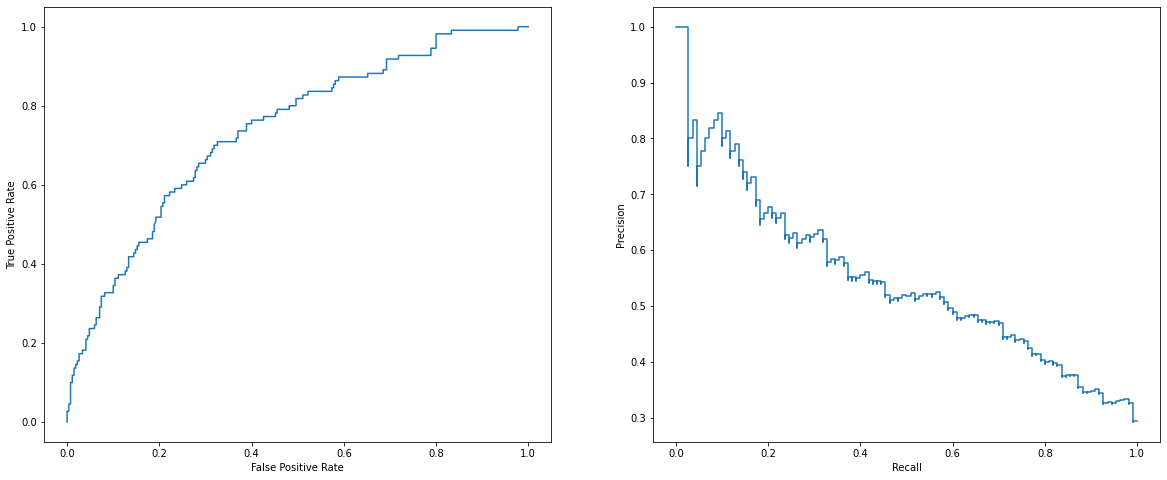

In [94]:
y_prob = clf_xgb.predict_proba(X_test_e)
probabilities = y_prob[:,1]

fpr_ros_e, tpr_ros_e, _ = roc_curve(y_test_e, probabilities)
roc_display_ros_e = RocCurveDisplay(fpr=fpr_ros_e, tpr=tpr_ros_e)
roc_auc_ros_e = auc(fpr_ros_e, tpr_ros_e)

prec_ros_e, recall_ros_e, _ = precision_recall_curve(y_test_e, probabilities)
pr_auc_ros_e = auc(recall_ros_e, prec_ros_e)
pr_display_ros_e = PrecisionRecallDisplay(precision=prec_ros_e, recall=recall_ros_e)

print('ROC AUC:', roc_auc_ros_e)
print('Precision-Recall AUC:', pr_auc_ros_e)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_ros_e.plot(ax=ax1)
pr_display_ros_e.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


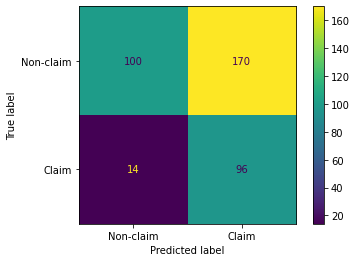

In [95]:
plot_confusion_matrix(clf_xgb, X_test_e, y_test_e, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:09:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'XS_100Pct_USD': 3, 'Full_GGWP': 5, 'Limit_100Pct_USD': 3, 'BrokerUltimateName_THB_GROUP': 1, 'PricingStrength': 3, 'Full_GGTP': 1, 'Full_GrossGrossModelPrice': 2, 'StatsMinorClassCode_DP': 1, 'Territory_SOUTH_KOREA': 1, 'ModelToActualRto': 3, 'LeaderLinePct': 3, 'BrokerUltimateName_AON': 1, 'Ded_100Pct_USD': 1, 'PlacingBasis_OM': 1, 'Territory_AUSTRALIA': 1, 'PLR_band_Upper_Middle': 1, 'PLR': 2, 'SubClass_ELECTRONIC_HARDWARE': 1, 'Territory_ALBERTA': 1, 'BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.': 1, 'Territory_CALIFORNIA': 1}
gain:  {'XS_100Pct_USD': 59.72662548666667, 'Full_GGWP': 43.846999566, 'Limit_100Pct_USD': 8.357468433333333, 'BrokerUltimateName_THB_GROUP': 2.0192318, 'PricingStrength': 18.534832966666666, 'Full_GGT

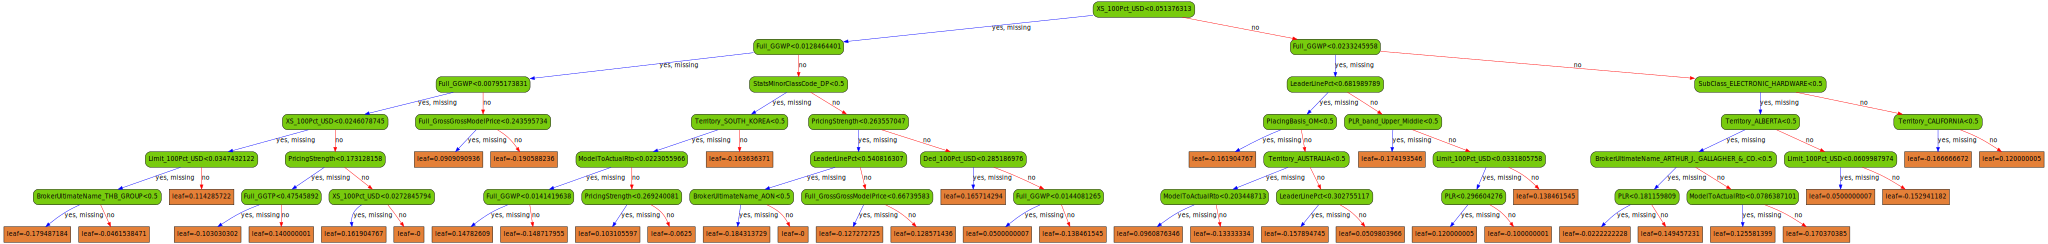

In [96]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0.1,
                          learning_rate=0.1,
                          max_depth=6,
                          reg_lambda=1,
                          scale_pos_weight=3,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_train_res_e, y_train_res_e)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


## SMOTE

In [97]:
sm = SMOTE(sampling_strategy = 'minority', random_state=42)

# Primary business
X_train_sm_p, y_train_sm_p = sm.fit_resample(X_train_p, y_train_p)

# Excess business
X_train_sm_e, y_train_sm_e = sm.fit_resample(X_train_e, y_train_e)

### XGBoost (SMOTE)

#### Primary business

In [98]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_train_sm_p, y_train_sm_p, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

In [99]:
# print(optimal_params.best_params_)

In [100]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0.1,
                          learning_rate=0.1,
                          max_depth=6,
                          reg_lambda=1,
                          scale_pos_weight=1,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5)
clf_xgb.fit(X_train_sm_p, y_train_sm_p, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

[0]	validation_0-aucpr:0.38323
[1]	validation_0-aucpr:0.76046
[2]	validation_0-aucpr:0.76840
[3]	validation_0-aucpr:0.76935
[4]	validation_0-aucpr:0.73629
[5]	validation_0-aucpr:0.76883
[6]	validation_0-aucpr:0.78336
[7]	validation_0-aucpr:0.79217


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[8]	validation_0-aucpr:0.77810
[9]	validation_0-aucpr:0.77915
[10]	validation_0-aucpr:0.79600
[11]	validation_0-aucpr:0.81802
[12]	validation_0-aucpr:0.80473
[13]	validation_0-aucpr:0.79861
[14]	validation_0-aucpr:0.79608
[15]	validation_0-aucpr:0.81916
[16]	validation_0-aucpr:0.80462
[17]	validation_0-aucpr:0.81268
[18]	validation_0-aucpr:0.81388
[19]	validation_0-aucpr:0.80378
[20]	validation_0-aucpr:0.80212
[21]	validation_0-aucpr:0.80917
[22]	validation_0-aucpr:0.79563
[23]	validation_0-aucpr:0.82536
[24]	validation_0-aucpr:0.80412
[25]	validation_0-aucpr:0.80919
[26]	validation_0-aucpr:0.80890
[27]	validation_0-aucpr:0.79926
[28]	validation_0-aucpr:0.79722
[29]	validation_0-aucpr:0.79811
[30]	validation_0-aucpr:0.80268
[31]	validation_0-aucpr:0.80101
[32]	validation_0-aucpr:0.80955
[33]	validation_0-aucpr:0.81251


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [101]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.825362
Best iteration: 23


In [102]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_p)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_p, predictions)
report = classification_report(y_test_p, predictions)
roc_auc = roc_auc_score(y_test_p, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 90.36%
ROC AUC: 0.7862637362637362
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94        70
         1.0       0.73      0.62      0.67        13

    accuracy                           0.90        83
   macro avg       0.83      0.79      0.81        83
weighted avg       0.90      0.90      0.90        83



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.9538461538461538
Precision-Recall AUC: 0.8252468898622745


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


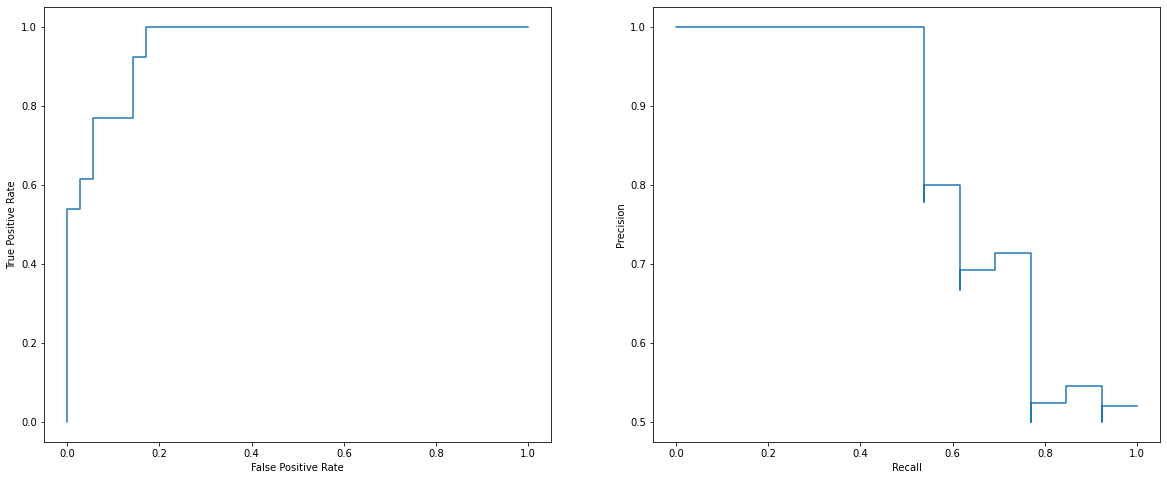

In [103]:
y_prob = clf_xgb.predict_proba(X_test_p)
probabilities = y_prob[:,1]

fpr_sm_p, tpr_sm_p, _ = roc_curve(y_test_p, probabilities)
roc_display_sm_p = RocCurveDisplay(fpr=fpr_sm_p, tpr=tpr_sm_p)
roc_auc_sm_p = auc(fpr_sm_p, tpr_sm_p)

prec_sm_p, recall_sm_p, _ = precision_recall_curve(y_test_p, probabilities)
pr_auc_sm_p = auc(recall_sm_p, prec_sm_p)
pr_display_sm_p = PrecisionRecallDisplay(precision=prec_sm_p, recall=recall_sm_p)

print('ROC AUC:', roc_auc_sm_p)
print('Precision-Recall AUC:', pr_auc_sm_p)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_sm_p.plot(ax=ax1)
pr_display_sm_p.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


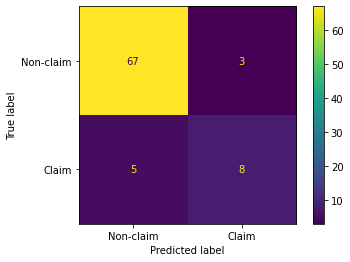

In [104]:
plot_confusion_matrix(clf_xgb, X_test_p, y_test_p, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:09:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'BrokerFeePct': 3, 'StatsMinorClassCode_FY': 1, 'PLR': 1, 'Limit_100Pct_USD': 1, 'Full_GGTP': 3, 'Ded_100Pct_USD': 1, 'SubClass_PROPERTY_/_REAL_ESTATE': 1, 'Territory_BRITISH_COLUMBIA': 1, 'PricingStrength': 1, 'RARC': 2, 'PLR_band_Lower_Middle': 1, 'LeaderStatus_LEAD': 1, 'Territory_USA_VIRGIN_ISLANDS': 1}
gain:  {'BrokerFeePct': 72.20752913, 'StatsMinorClassCode_FY': 26.3193665, 'PLR': 29.8421707, 'Limit_100Pct_USD': 5.34722233, 'Full_GGTP': 12.470819803333335, 'Ded_100Pct_USD': 6.34920645, 'SubClass_PROPERTY_/_REAL_ESTATE': 12.7707672, 'Territory_BRITISH_COLUMBIA': 13.3541412, 'PricingStrength': 5.17144775, 'RARC': 3.2516250634999997, 'PLR_band_Lower_Middle': 5.53172302, 'LeaderStatus_LEAD': 1.04411316, 'Territory_USA_VIRGIN_

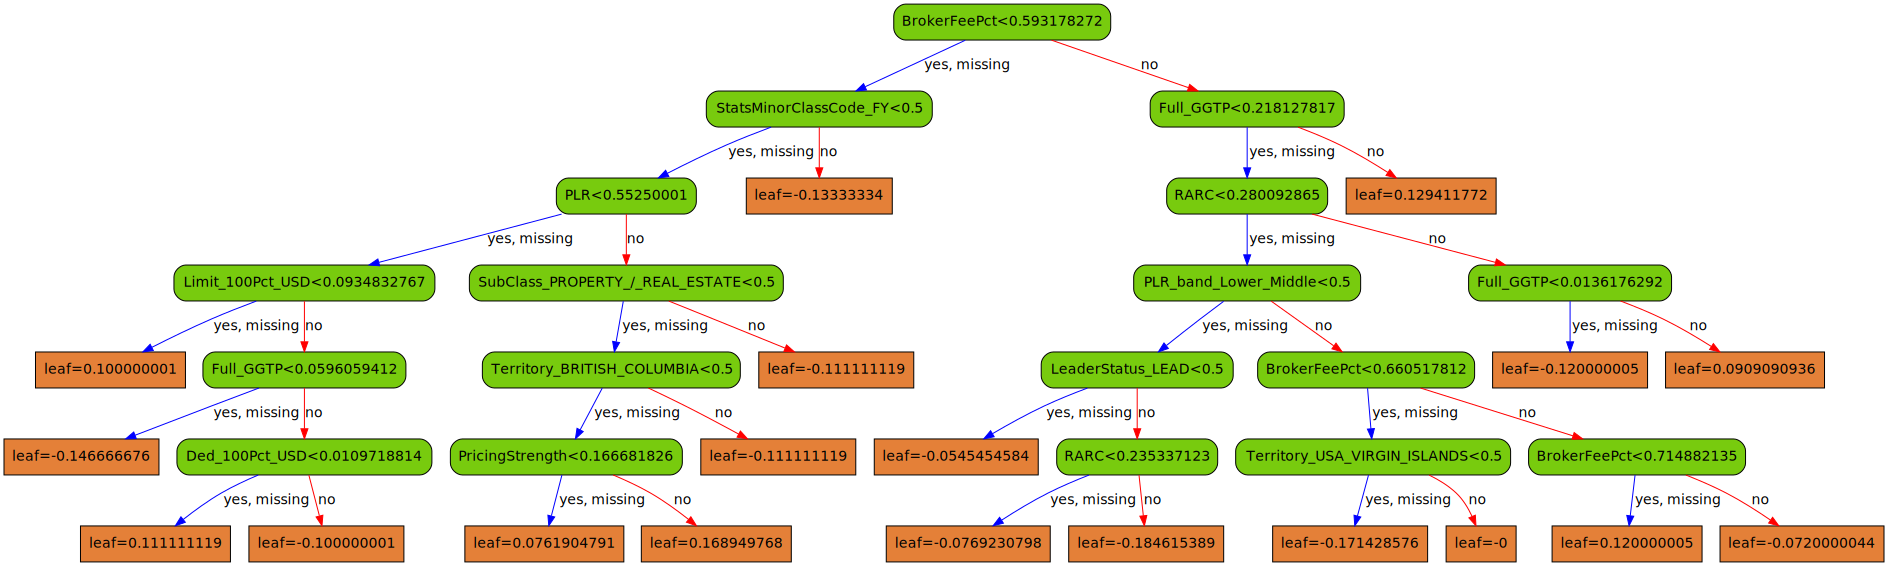

In [105]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                         gamma=0.1,
                          learning_rate=0.1,
                          max_depth=6,
                          reg_lambda=1,
                          scale_pos_weight=1,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_train_sm_p, y_train_sm_p)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


#### Excess business

In [106]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_train_sm_e, y_train_sm_e, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

In [107]:
# print(optimal_params.best_params_)

In [108]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0.1,
                          learning_rate=0.05,
                          max_depth=5,
                          reg_lambda=1,
                          scale_pos_weight=1,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5
                           )
clf_xgb.fit(X_train_sm_e, y_train_sm_e, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

[0]	validation_0-aucpr:0.37065
[1]	validation_0-aucpr:0.43818


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-aucpr:0.46472
[3]	validation_0-aucpr:0.47277
[4]	validation_0-aucpr:0.46245
[5]	validation_0-aucpr:0.46183
[6]	validation_0-aucpr:0.46841
[7]	validation_0-aucpr:0.45735
[8]	validation_0-aucpr:0.45397
[9]	validation_0-aucpr:0.45259
[10]	validation_0-aucpr:0.46059
[11]	validation_0-aucpr:0.45900
[12]	validation_0-aucpr:0.45940
[13]	validation_0-aucpr:0.45307


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [109]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.472773
Best iteration: 3


In [110]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_e)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_e, predictions)
report = classification_report(y_test_e, predictions)
roc_auc = roc_auc_score(y_test_e, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 65.53%
ROC AUC: 0.663131313131313
              precision    recall  f1-score   support

         0.0       0.83      0.64      0.73       270
         1.0       0.44      0.68      0.53       110

    accuracy                           0.66       380
   macro avg       0.64      0.66      0.63       380
weighted avg       0.72      0.66      0.67       380



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.7041919191919193
Precision-Recall AUC: 0.4745181420177552


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


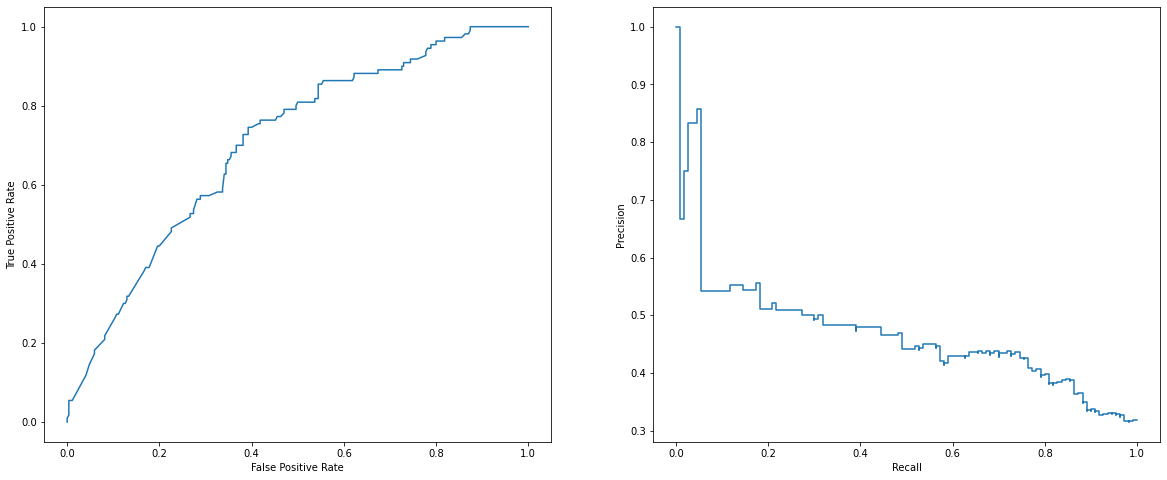

In [111]:
y_prob = clf_xgb.predict_proba(X_test_e)
probabilities = y_prob[:,1]

fpr_sm_e, tpr_sm_e, _ = roc_curve(y_test_e, probabilities)
roc_display_sm_e = RocCurveDisplay(fpr=fpr_sm_e, tpr=tpr_sm_e)
roc_auc_sm_e = auc(fpr_sm_e, tpr_sm_e)

prec_sm_e, recall_sm_e, _ = precision_recall_curve(y_test_e, probabilities)
pr_auc_sm_e = auc(recall_sm_e, prec_sm_e)
pr_display_sm_e = PrecisionRecallDisplay(precision=prec_sm_e, recall=recall_sm_e)

print('ROC AUC:', roc_auc_sm_e)
print('Precision-Recall AUC:', pr_auc_sm_e)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_sm_e.plot(ax=ax1)
pr_display_sm_e.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


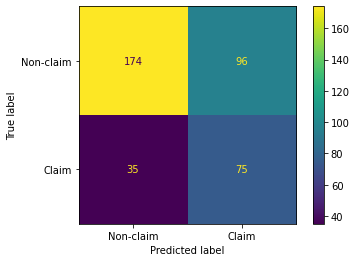

In [112]:
plot_confusion_matrix(clf_xgb, X_test_e, y_test_e, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:09:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'BrokerFeePct': 2, 'StatsMinorClassCode_FY': 1, 'PLR': 1, 'Limit_100Pct_USD': 1, 'Full_GGTP': 3, 'SubClass_PROPERTY_/_REAL_ESTATE': 1, 'Territory_BRITISH_COLUMBIA': 1, 'RARC': 1, 'PLR_band_Lower_Middle': 1, 'LeaderStatus_LEAD': 1}
gain:  {'BrokerFeePct': 105.03645501, 'StatsMinorClassCode_FY': 26.3193665, 'PLR': 29.8421707, 'Limit_100Pct_USD': 5.34722233, 'Full_GGTP': 12.470819803333335, 'SubClass_PROPERTY_/_REAL_ESTATE': 12.7707672, 'Territory_BRITISH_COLUMBIA': 13.3541412, 'RARC': 6.20860291, 'PLR_band_Lower_Middle': 5.53172302, 'LeaderStatus_LEAD': 1.04411316}
cover:  {'BrokerFeePct': 76.625, 'StatsMinorClassCode_FY': 77.25, 'PLR': 73.75, 'Limit_100Pct_USD': 8.0, 'Full_GGTP': 24.166666666666668, 'SubClass_PROPERTY_/_REAL_ESTA

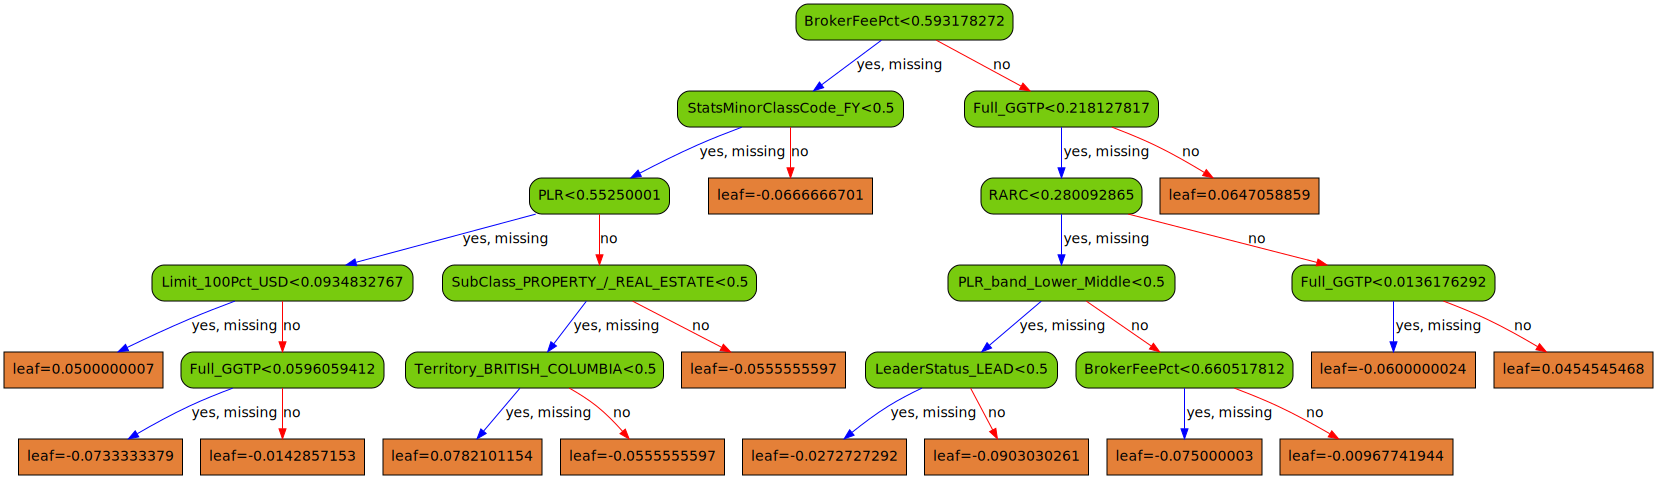

In [113]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0.1,
                          learning_rate=0.05,
                          max_depth=5,
                          reg_lambda=1,
                          scale_pos_weight=1,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_train_sm_p, y_train_sm_p)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


## GAN

In [114]:
def generator_network(x, data_dim, base_n_count): 
    x = layers.Dense(base_n_count, activation='relu')(x)
    x = layers.Dense(base_n_count*2, activation='relu')(x)
    x = layers.Dense(base_n_count*4, activation='relu')(x)
    x = layers.Dense(data_dim)(x)    
    return x

def discriminator_network(x, data_dim, base_n_count):
    x = layers.Dense(base_n_count*4, activation='relu')(x)
    # x = layers.Dropout(0.1)(x)
    x = layers.Dense(base_n_count*2, activation='relu')(x)
    # x = layers.Dropout(0.1)(x)
    x = layers.Dense(base_n_count, activation='relu')(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    # x = layers.Dense(1)(x)
    return x

In [115]:
def generator_network_w_label(x, labels, data_dim, label_dim, base_n_count): 
    x = layers.concatenate([x,labels])
    x = layers.Dense(base_n_count*1, activation='relu')(x) # 1
    x = layers.Dense(base_n_count*2, activation='relu')(x) # 2
    x = layers.Dense(base_n_count*4, activation='relu')(x)
    # x = layers.Dense(base_n_count*4, activation='relu')(x) # extra
    # x = layers.Dense(base_n_count*4, activation='relu')(x) # extra
    x = layers.Dense(data_dim)(x)    
    x = layers.concatenate([x,labels])
    return x

In [116]:
def get_data_batch(train, batch_size, seed=42):
    # # random sampling - some samples will have excessively low or high sampling, but easy to implement
    # np.random.seed(seed)
    # x = train.loc[ np.random.choice(train.index, batch_size) ].values
    
    # iterate through shuffled indices, so every sample gets covered evenly
    start_i = (batch_size * seed) % len(train)
    stop_i = start_i + batch_size
    shuffle_seed = (batch_size * seed) // len(train)
    np.random.seed(shuffle_seed)
    train_ix = np.random.choice( list(train.index), replace=False, size=len(train) ) # wasteful to shuffle every time
    train_ix = list(train_ix) + list(train_ix) # duplicate to cover ranges past the end of the set
    x = train.loc[ train_ix[ start_i: stop_i ] ].values
    
    return np.reshape(x, (batch_size, -1) )

In [117]:
def CheckAccuracy( x, g_z, data_cols, label_cols=[], seed=42, with_class=False, data_dim=2 ):

    # Slightly slower code to create dataframes to feed into the xgboost dmatrix formats
    
    # real_samples = pd.DataFrame(x, columns=data_cols+label_cols)
    # gen_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
    # real_samples['syn_label'] = 0
    # gen_samples['syn_label'] = 1
    
    # training_fraction = 0.5
    # n_real, n_gen = int(len(real_samples)*training_fraction), int(len(gen_samples)*training_fraction)
    # train_df = pd.concat([real_samples[:n_real],gen_samples[:n_gen]],axis=0)
    # test_df = pd.concat([real_samples[n_real:],gen_samples[n_gen:]],axis=0)

    # X_col = test_df.columns[:-1]
    # y_col = test_df.columns[-1]
    # dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
    # dtest = xgb.DMatrix(test_df[X_col], feature_names=X_col)
    # y_true = test_df['syn_label']

    dtrain = np.vstack( [ x[:int(len(x)/2)], g_z[:int(len(g_z)/2)] ] ) # Use half of each real and generated set for training
    dlabels = np.hstack( [ np.zeros(int(len(x)/2)), np.ones(int(len(g_z)/2)) ] ) # synthetic labels
    dtest = np.vstack( [ x[int(len(x)/2):], g_z[int(len(g_z)/2):] ] ) # Use the other half of each set for testing
    y_true = dlabels # Labels for test samples will be the same as the labels for training samples, assuming even batch sizes
    
    dtrain = xgb.DMatrix(dtrain, dlabels, feature_names=data_cols)
    dtest = xgb.DMatrix(dtest, feature_names=data_cols)
    
    xgb_params = {
        # 'tree_method': 'hist', # for faster evaluation
        'max_depth': 6,
        'objective': 'binary:logistic',
        'random_state': 0,
        'eval_metric': 'aucpr',
#         'gamma' : 0,
#         'learning_rate': 0.1,
#         'reg_lambda' : 10,
        'scale_pos_weight' : 1 # allows for balanced or unbalanced classes 
        }
    xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=100) # limit to ten rounds for faster evaluation

    y_pred = xgb_test.predict(dtest)

    y_pred = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_true, y_pred)
    # return '{:.2f}'.format(SimpleAccuracy(y_pred, y_true)) # assumes balanced real and generated datasets
    return accuracy # assumes balanced real and generated datasets

In [118]:
def CheckAccuracyConditional( x, g_z, data_cols, label_cols=[], seed=42, with_class=False, data_dim=2 ):

    # Slightly slower code to create dataframes to feed into the xgboost dmatrix formats
    
    # real_samples = pd.DataFrame(x, columns=data_cols+label_cols)
    # gen_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
    # real_samples['syn_label'] = 0
    # gen_samples['syn_label'] = 1
    
    # training_fraction = 0.5
    # n_real, n_gen = int(len(real_samples)*training_fraction), int(len(gen_samples)*training_fraction)
    # train_df = pd.concat([real_samples[:n_real],gen_samples[:n_gen]],axis=0)
    # test_df = pd.concat([real_samples[n_real:],gen_samples[n_gen:]],axis=0)

    # X_col = test_df.columns[:-1]
    # y_col = test_df.columns[-1]
    # dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
    # dtest = xgb.DMatrix(test_df[X_col], feature_names=X_col)
    # y_true = test_df['syn_label']

    dtrain = np.vstack( [ x[:int(len(x)/2)], g_z[:int(len(g_z)/2)] ] ) # Use half of each real and generated set for training
    dlabels = np.hstack( [ np.zeros(int(len(x)/2)), np.ones(int(len(g_z)/2)) ] ) # synthetic labels
    dtest = np.vstack( [ x[int(len(x)/2):], g_z[int(len(g_z)/2):] ] ) # Use the other half of each set for testing
    y_true = dlabels # Labels for test samples will be the same as the labels for training samples, assuming even batch sizes
    
    dtrain = xgb.DMatrix(dtrain, dlabels, feature_names=data_cols_w_class)
    dtest = xgb.DMatrix(dtest, feature_names=data_cols_w_class)
    
    xgb_params = {
        # 'tree_method': 'hist', # for faster evaluation
        'max_depth': 6,
        'objective': 'binary:logistic',
        'random_state': 0,
        'eval_metric': 'aucpr',
#         'gamma' : 0,
#         'learning_rate': 0.1,
#         'reg_lambda' : 10,
        'scale_pos_weight' : 1 # allows for balanced or unbalanced classes 
        }
    xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=100) # limit to ten rounds for faster evaluation

    y_pred = xgb_test.predict(dtest)

    y_pred = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_true, y_pred)
    # return '{:.2f}'.format(SimpleAccuracy(y_pred, y_true)) # assumes balanced real and generated datasets
    return accuracy # assumes balanced real and generated datasets

#### Primary Business

In [119]:
X_encoded_w_classes_p = X_train_p.copy()
X_encoded_w_classes_p['Class'] = y_train_p
X_encoded_w_classes_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,"BrokerUltimateName_NAUSCH_HOGAN_AND_MURRAY,_INC",BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Upper_Middle,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle,Class
161,0.017739,0.004671,1.0,0.000500,0.4811,0.263959,0.534054,0.241071,0.724812,0.135099,...,0,0,0,0,1,0,0,0,1,0.0
228,0.245383,0.025324,1.0,0.000000,0.5326,0.263959,0.523761,0.236111,0.081870,0.022363,...,0,0,0,0,0,0,0,0,0,0.0
287,0.065238,0.018378,1.0,0.001685,0.5612,0.263959,0.543699,0.235243,0.660517,0.041204,...,0,0,0,0,0,1,0,0,0,0.0
335,0.245383,0.042298,1.0,0.000000,0.4932,0.263959,0.670768,0.258333,0.596223,0.104932,...,0,0,0,0,0,0,0,1,0,0.0
289,0.198154,0.021396,1.0,0.000000,0.6983,0.263959,0.000000,0.166667,0.081870,0.000000,...,0,1,0,0,0,0,1,0,0,0.0


In [120]:
# Finding rows with class '1'
train_p = X_encoded_w_classes_p.loc[ X_encoded_w_classes_p.Class == 1 ].copy()
claim_w_classes_p = train_p.copy()
claim_w_classes_p['Class'] = y_train_p
# claim_w_classes_p.head()
train_p = claim_w_classes_p.copy().reset_index(drop=True)
# train_p.head()

label_cols = ['Class']
data_cols = [ i for i in train_p.columns if i not in label_cols ]
train_no_label_p = train_p.copy()
train_no_label_p.drop('Class', axis=1, inplace=True)
# train_no_label_p = train_p[ data_cols ]
train_no_label_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_JOHN_HOLMAN_&_SONS_LTD,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,"BrokerUltimateName_NAUSCH_HOGAN_AND_MURRAY,_INC",BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Upper_Middle,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle
0,0.037785,0.027338,1.000000,0.003000,0.4577,0.213198,0.596739,0.270833,0.596223,0.053135,...,0,0,0,0,0,0,0,0,0,0
1,0.017739,0.005358,1.000000,0.000500,0.6010,0.263959,0.498425,0.205729,0.596223,0.080535,...,0,0,0,0,0,0,1,0,1,0
2,1.000000,0.308956,0.245690,0.000000,0.3621,0.263959,0.774043,0.333940,0.711953,0.051500,...,0,0,0,0,0,0,0,0,0,0
3,0.245383,0.020760,1.000000,0.000309,0.7440,0.263959,0.587271,0.177083,0.153696,0.086984,...,0,0,0,0,0,0,0,0,1,0
4,0.398616,0.411987,0.461207,0.250000,0.6600,0.263959,0.816713,0.184028,0.118454,0.119398,...,0,0,1,0,0,0,0,1,1,0


In [121]:
# rand_dim = len(train_no_label_p.columns) # 32 # needs to be ~data_dim
# base_n_count = 128 # 128

# nb_steps = 10000 + 1 # 50000 # Add one for logging of the last interval
# batch_size = 32 # 64

# k_d = 1  # number of critic network updates per adversarial training step
# k_g = 1  # number of generator network updates per adversarial training step
# critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
# log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
# learning_rate = 5e-4 # 5e-5
# # data_dir = 'cache/'
# # generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None
# # show = True 

In [122]:
# with_class=False
# data_cols = train_no_label_p.columns
# data_dim = len(data_cols)
# print('data_dim: ', data_dim)
# print('data_cols: ', data_cols)
    
# label_dim = 0

# K.set_learning_phase(1) # 1 = train

# cache_prefix = 'GAN'

# generator_input_tensor = layers.Input(shape=(rand_dim, ))
# generated_image_tensor = generator_network(generator_input_tensor, data_dim, base_n_count)

# generated_or_real_image_tensor = layers.Input(shape=(data_dim,))
    
# discriminator_output = discriminator_network(generated_or_real_image_tensor, data_dim, base_n_count)

# generator_model = models.Model(inputs=[generator_input_tensor], outputs=[generated_image_tensor], name='generator')
# discriminator_model = models.Model(inputs=[generated_or_real_image_tensor],
#                                    outputs=[discriminator_output],
#                                    name='discriminator')

# combined_output = discriminator_model(generator_model(generator_input_tensor))
# combined_model = models.Model(inputs=[generator_input_tensor], outputs=[combined_output], name='combined')

In [123]:
# combined_loss, disc_loss_generated, disc_loss_real, xgb_losses = [], [], [], []

In [124]:
# adam = optimizers.Adam(lr=learning_rate, beta_1=0.5, beta_2=0.9)

# generator_model.compile(optimizer=adam, loss='binary_crossentropy')
# discriminator_model.compile(optimizer=adam, loss='binary_crossentropy')
# discriminator_model.trainable = False
# combined_model.compile(optimizer=adam, loss='binary_crossentropy')

# # print(generator_model.summary())
# # print(discriminator_model.summary())
# # print(combined_model.summary())

In [125]:
# for i in range(0, nb_steps):
#     K.set_learning_phase(1)
    
#     # train the discriminator
#     for j in range(k_d):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         x = get_data_batch(train_no_label_p, batch_size, seed=i+j)
            
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
#         else:
#             g_z = generator_model.predict(z)
# #             x = np.vstack([x,g_z]) # code to train the discriminator on real and generated data at the same time, but you have to run network again for separate losses
# #             classes = np.hstack([np.zeros(batch_size),np.ones(batch_size)])
# #             d_l_r = discriminator_model.train_on_batch(x, classes)
            
#         d_l_r = discriminator_model.train_on_batch(x, np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#         d_l_g = discriminator_model.train_on_batch(g_z, np.random.uniform(low=0.0, high=0.001, size=batch_size)) # 0.0, 0.3 # GANs need noise to prevent loss going to zero
#             # d_l_r = discriminator_model.train_on_batch(x, np.ones(batch_size)) # without noise
#             # d_l_g = discriminator_model.train_on_batch(g_z, np.zeros(batch_size)) # without noise
#     disc_loss_real.append(d_l_r)
#     disc_loss_generated.append(d_l_g)
    
#     # train the generator
#     for j in range(k_g):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         if with_class:
#             # loss = combined_model.train_on_batch([z, labels], np.ones(batch_size)) # without noise
#             loss = combined_model.train_on_batch([z, labels], np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#         else:
#             # loss = combined_model.train_on_batch(z, np.ones(batch_size)) # without noise
#             loss = combined_model.train_on_batch(z, np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#     combined_loss.append(loss)
    
#     # Determine xgb loss each step, after training generator and discriminator
#     if not i % 10: # 2x faster than testing each step...
#         K.set_learning_phase(0) # 0 = test
#         test_size = np.sum(train_p['Class']==1) - 1 # test using all of the actual fraud data - 1
#         x = get_data_batch(train_no_label_p, test_size, seed=i)
#         z = np.random.normal(size=(test_size, rand_dim))
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
#         else:
#             g_z = generator_model.predict(z)
#         xgb_loss = CheckAccuracy( x, g_z, data_cols, label_cols, seed=42, with_class=with_class, data_dim=data_dim )
#         xgb_losses = np.append(xgb_losses, xgb_loss)
    
#     # Saving weights and plotting images
#     if not i % log_interval:
#         print('Step: {} of {}.'.format(i, nb_steps))
#         K.set_learning_phase(0) # 0 = test
                        
#         # loss summaries      
#         print( 'Losses: G, D Gen, D Real, Xgb: {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(combined_loss[-1], disc_loss_generated[-1], disc_loss_real[-1], xgb_losses[-1]) )
#         print( 'D Real - D Gen: {:.4f}'.format(disc_loss_real[-1]-disc_loss_generated[-1]) )    

In [126]:
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1, 3, 1)
# ax2 = fig.add_subplot(1, 3, 2)
# ax3 = fig.add_subplot(1, 3, 3)

# ax1.plot(combined_loss)
# ax1.set_title('Generator Loss')
# ax1.set_xlabel('Step')
# ax1.set_ylabel('Loss')

# ax2.plot(disc_loss_generated)
# ax2.set_title('Discriminator Loss of Generated Data')
# ax2.set_xlabel('Step')
# ax2.set_ylabel('Loss')

# ax3.plot(disc_loss_real)
# ax3.set_title('Discriminator Loss of Real Data')
# ax3.set_xlabel('Step')
# ax3.set_ylabel('Loss')

# plt.show()

In [127]:
# # Predicting the generated data
# samples = len(X_train_res_p) - len(X_train_p)
# new_z = np.random.normal(size=(samples,rand_dim))
# new_g_z = generator_model.predict(new_z)

In [128]:
# gan_samples_p = pd.DataFrame(new_g_z, columns=data_cols)
# gan_samples_p.to_csv('dandoww_gan_primary.csv',index=False)

In [129]:
gan_samples_p = pd.read_csv('../input/project/dandoww_gan_primary.csv')
gan_samples_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_JOHN_HOLMAN_&_SONS_LTD,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,"BrokerUltimateName_NAUSCH_HOGAN_AND_MURRAY,_INC",BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Upper_Middle,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle
0,0.248293,0.024940,1.011629,-0.001476,0.749169,0.270477,0.609654,0.185433,0.130672,0.088258,...,0.003338,0.000779,0.000003,-0.000008,-0.000454,-0.001189,-0.001485,-0.000069,1.011823,0.003259
1,0.253697,0.048185,1.024364,-0.001216,0.760491,0.280334,0.658108,0.181203,0.086187,0.090474,...,0.002421,0.001775,-0.000754,0.000275,0.000498,-0.001070,-0.001219,0.000077,1.024686,0.002277
2,0.253697,0.048185,1.024364,-0.001216,0.760491,0.280334,0.658108,0.181203,0.086187,0.090474,...,0.002421,0.001775,-0.000754,0.000275,0.000498,-0.001070,-0.001219,0.000077,1.024686,0.002277
3,0.247988,0.021762,1.011907,-0.001377,0.749229,0.269516,0.603170,0.186386,0.138443,0.088287,...,0.003182,0.000583,-0.000007,-0.000069,-0.000428,-0.001254,-0.001802,-0.000038,1.012055,0.003230
4,0.253697,0.048185,1.024364,-0.001216,0.760491,0.280334,0.658108,0.181203,0.086187,0.090474,...,0.002421,0.001775,-0.000754,0.000275,0.000498,-0.001070,-0.001219,0.000077,1.024686,0.002277


In [130]:
X_gan_p = X_train_p.append(gan_samples_p, ignore_index = True)
X_gan_p.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_JOHN_HOLMAN_&_SONS_LTD,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,"BrokerUltimateName_NAUSCH_HOGAN_AND_MURRAY,_INC",BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Upper_Middle,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle
count,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,...,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000
mean,0.188507,0.054922,0.912529,0.010616,0.657945,0.271861,0.570014,0.207094,0.337554,0.094143,...,0.004708,0.023909,0.094759,0.012644,0.032355,0.044346,0.141058,0.157735,0.599826,0.119342
std,0.135154,0.089103,0.227468,0.066449,0.128188,0.047578,0.183393,0.065615,0.267312,0.078731,...,0.059763,0.150890,0.293526,0.111388,0.176826,0.207156,0.349140,0.364780,0.499094,0.322842
min,0.000000,0.000000,0.000000,-0.001865,0.177000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.001634,-0.000078,-0.000483,-0.001257,-0.002149,-0.000785,0.000000,0.000000
25%,0.078481,0.013600,1.000000,-0.001216,0.577150,0.263959,0.544071,0.181203,0.086187,0.054136,...,0.000000,0.000000,-0.000682,0.000000,0.000000,-0.001070,-0.001219,0.000000,0.000000,0.000000
50%,0.245383,0.040059,1.000000,0.000000,0.713000,0.263959,0.631150,0.181672,0.171882,0.089634,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.002277
75%,0.253697,0.048185,1.021868,0.002493,0.760491,0.280334,0.658108,0.208352,0.596223,0.090474,...,0.002421,0.001775,0.000000,0.000275,0.000498,0.000000,0.000000,0.000077,1.020996,0.002955
max,1.000000,1.000000,1.024364,1.000000,0.846999,1.000000,1.000000,0.836142,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.024686,1.000000


In [131]:
X_train_p.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_JOHN_HOLMAN_&_SONS_LTD,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,"BrokerUltimateName_NAUSCH_HOGAN_AND_MURRAY,_INC",BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Upper_Middle,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle
count,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,...,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000
mean,0.144531,0.064002,0.837913,0.018893,0.589426,0.267959,0.518468,0.224191,0.502811,0.097125,...,0.006061,0.039394,0.160606,0.021212,0.054545,0.075758,0.239394,0.266667,0.309091,0.200000
std,0.161786,0.114778,0.271871,0.085482,0.127599,0.061516,0.223887,0.081042,0.231636,0.102332,...,0.077731,0.194826,0.367725,0.144310,0.227436,0.265012,0.427362,0.442888,0.462821,0.400607
min,0.000000,0.000000,0.000000,0.000000,0.177000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.017739,0.006731,0.568966,0.000309,0.509525,0.263959,0.472085,0.166667,0.339047,0.032611,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.097923,0.020469,1.000000,0.001000,0.610050,0.263959,0.571924,0.201389,0.596223,0.065340,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.198154,0.068550,1.000000,0.005616,0.698225,0.263959,0.652750,0.241071,0.660517,0.132079,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,0.846999,1.000000,1.000000,0.836142,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [132]:
ones = np.ones((len(gan_samples_p),))
one = pd.Series(ones)
y_gan_p = y_train_p.append(one, ignore_index=True)
# y_gan_p

#### Excess Business

In [133]:
X_encoded_w_classes_e = X_train_e.copy()
X_encoded_w_classes_e['Class'] = y_train_e
X_encoded_w_classes_e.head()

,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,...,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle,PLR_band_ex_adj_Upper_Quantile,Class
826,0.114050,0.617426,0.060234,0.030612,0.035984,0.530641,0.221555,0.210193,0.683076,0.232331,...,0,0,0,1,0,0,1,0,0,0.0
447,0.057123,0.520773,0.014839,0.240204,0.210151,0.000000,0.276326,0.277531,0.637512,0.176302,...,0,0,1,0,0,0,0,1,0,0.0
1210,0.026221,0.538964,0.019957,0.346020,0.108220,0.000000,0.252025,0.352610,0.716845,0.193359,...,0,0,1,0,0,0,0,0,1,1.0
1663,0.076522,0.595267,0.031501,0.489796,0.014581,0.000000,0.386192,0.262867,0.706239,0.145834,...,0,0,0,0,0,1,0,1,0,0.0
315,0.067954,0.575828,0.026549,0.319796,0.086575,0.000000,0.341237,0.309986,0.708364,0.158333,...,0,0,0,0,0,1,0,0,1,0.0


In [134]:
# Finding rows with class '1'
train_e = X_encoded_w_classes_e.loc[ X_encoded_w_classes_e.Class == 1 ].copy()
claim_w_classes_e = train_e.copy()
claim_w_classes_e['Class'] = y_train_e
# claim_w_classes_e.head()
train_e = claim_w_classes_e.copy().reset_index(drop=True)
# train_e.head()

label_cols = ['Class']
data_cols = [ i for i in train_e.columns if i not in label_cols ]
train_no_label_e = train_e.copy()
train_no_label_e.drop('Class', axis=1, inplace=True)
# train_no_label_e = train_e[ data_cols ]
train_no_label_e.head()

,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,...,BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle,PLR_band_ex_adj_Upper_Quantile
0,0.026221,0.538964,0.019957,0.346020,0.108220,0.000000,0.252025,0.352610,0.716845,0.193359,...,0,0,0,1,0,0,0,0,0,1
1,0.137510,0.560556,0.024887,0.183673,0.216446,0.650734,0.293439,0.262867,0.646901,0.183911,...,0,0,0,0,0,1,0,1,0,0
2,0.026221,0.561268,0.026992,0.489796,0.034627,0.000000,0.242476,0.323205,0.681138,0.200859,...,1,0,0,1,0,0,0,0,1,0
3,0.276159,0.623994,0.068404,0.120306,0.113257,0.771782,0.218926,0.309986,0.773354,0.245690,...,0,0,0,0,1,0,0,0,0,1
4,0.137510,0.614651,0.046490,0.209184,0.173156,0.000000,0.275146,0.287047,0.734016,0.177083,...,0,0,0,1,0,0,0,0,1,0


In [135]:
# rand_dim = len(train_no_label_e.columns) # 32 # needs to be ~data_dim
# base_n_count = 128 # 128

# nb_steps = 10000 + 1 # 50000 # Add one for logging of the last interval
# batch_size = 128 # 64

# k_d = 1  # number of critic network updates per adversarial training step
# k_g = 1  # number of generator network updates per adversarial training step
# critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
# log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
# learning_rate = 5e-4 # 5e-5
# # data_dir = 'cache/'
# # generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None
# # show = True 

In [136]:
# with_class=False
# data_cols = train_no_label_e.columns
# data_dim = len(data_cols)
# print('data_dim: ', data_dim)
# print('data_cols: ', data_cols)
    
# label_dim = 0

# K.set_learning_phase(1) # 1 = train

# cache_prefix = 'GAN'

# generator_input_tensor = layers.Input(shape=(rand_dim, ))
# generated_image_tensor = generator_network(generator_input_tensor, data_dim, base_n_count)

# generated_or_real_image_tensor = layers.Input(shape=(data_dim,))
    
# discriminator_output = discriminator_network(generated_or_real_image_tensor, data_dim, base_n_count)

# generator_model = models.Model(inputs=[generator_input_tensor], outputs=[generated_image_tensor], name='generator')
# discriminator_model = models.Model(inputs=[generated_or_real_image_tensor],
#                                    outputs=[discriminator_output],
#                                    name='discriminator')

# combined_output = discriminator_model(generator_model(generator_input_tensor))
# combined_model = models.Model(inputs=[generator_input_tensor], outputs=[combined_output], name='combined')

In [137]:
# combined_loss, disc_loss_generated, disc_loss_real, xgb_losses = [], [], [], []

In [138]:
# adam = optimizers.Adam(lr=learning_rate, beta_1=0.5, beta_2=0.9)

# generator_model.compile(optimizer=adam, loss='binary_crossentropy')
# discriminator_model.compile(optimizer=adam, loss='binary_crossentropy')
# discriminator_model.trainable = False
# combined_model.compile(optimizer=adam, loss='binary_crossentropy')

# # print(generator_model.summary())
# # print(discriminator_model.summary())
# # print(combined_model.summary())

In [139]:
# for i in range(0, nb_steps):
#     K.set_learning_phase(1)
    
#     # train the discriminator
#     for j in range(k_d):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         x = get_data_batch(train_no_label_e, batch_size, seed=i+j)
            
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
#         else:
#             g_z = generator_model.predict(z)
# #             x = np.vstack([x,g_z]) # code to train the discriminator on real and generated data at the same time, but you have to run network again for separate losses
# #             classes = np.hstack([np.zeros(batch_size),np.ones(batch_size)])
# #             d_l_r = discriminator_model.train_on_batch(x, classes)
            
#         d_l_r = discriminator_model.train_on_batch(x, np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#         d_l_g = discriminator_model.train_on_batch(g_z, np.random.uniform(low=0.0, high=0.001, size=batch_size)) # 0.0, 0.3 # GANs need noise to prevent loss going to zero
#             # d_l_r = discriminator_model.train_on_batch(x, np.ones(batch_size)) # without noise
#             # d_l_g = discriminator_model.train_on_batch(g_z, np.zeros(batch_size)) # without noise
#     disc_loss_real.append(d_l_r)
#     disc_loss_generated.append(d_l_g)
    
#     # train the generator
#     for j in range(k_g):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         if with_class:
#             # loss = combined_model.train_on_batch([z, labels], np.ones(batch_size)) # without noise
#             loss = combined_model.train_on_batch([z, labels], np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#         else:
#             # loss = combined_model.train_on_batch(z, np.ones(batch_size)) # without noise
#             loss = combined_model.train_on_batch(z, np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#     combined_loss.append(loss)
    
#     # Determine xgb loss each step, after training generator and discriminator
#     if not i % 10: # 2x faster than testing each step...
#         K.set_learning_phase(0) # 0 = test
#         test_size = np.sum(train_e['Class']==1)  # test using all of the actual fraud data 
#         x = get_data_batch(train_no_label_e, test_size, seed=i)
#         z = np.random.normal(size=(test_size, rand_dim))
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
#         else:
#             g_z = generator_model.predict(z)
#         xgb_loss = CheckAccuracy( x, g_z, data_cols, label_cols, seed=42, with_class=with_class, data_dim=data_dim )
#         xgb_losses = np.append(xgb_losses, xgb_loss)
    
#     # Saving weights and plotting images
#     if not i % log_interval:
#         print('Step: {} of {}.'.format(i, nb_steps))
#         K.set_learning_phase(0) # 0 = test
                        
#         # loss summaries      
#         print( 'Losses: G, D Gen, D Real, Xgb: {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(combined_loss[-1], disc_loss_generated[-1], disc_loss_real[-1], xgb_losses[-1]) )
#         print( 'D Real - D Gen: {:.4f}'.format(disc_loss_real[-1]-disc_loss_generated[-1]) )    

In [140]:
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1, 3, 1)
# ax2 = fig.add_subplot(1, 3, 2)
# ax3 = fig.add_subplot(1, 3, 3)

# ax1.plot(combined_loss)
# ax1.set_title('Generator Loss')
# ax1.set_xlabel('Step')
# ax1.set_ylabel('Loss')

# ax2.plot(disc_loss_generated)
# ax2.set_title('Discriminator Loss of Generated Data')
# ax2.set_xlabel('Step')
# ax2.set_ylabel('Loss')

# ax3.plot(disc_loss_real)
# ax3.set_title('Discriminator Loss of Real Data')
# ax3.set_xlabel('Step')
# ax3.set_ylabel('Loss')

# plt.show()

In [141]:
# # Predicting the generated data
# samples = len(X_train_res_e) - len(X_train_e)
# new_z = np.random.normal(size=(samples,rand_dim))
# new_g_z = generator_model.predict(new_z)

In [142]:
# gan_samples_e = pd.DataFrame(new_g_z, columns=data_cols)
# gan_samples_e.to_csv('dandoww_gan_excess.csv',index=False)

In [143]:
gan_samples_e = pd.read_csv('../input/project/dandoww_gan_excess.csv')
gan_samples_e.head()

,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,...,BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle,PLR_band_ex_adj_Upper_Quantile
0,0.059582,0.662423,0.136774,0.219498,0.125374,0.382594,0.249418,0.283237,0.588887,0.062882,...,-0.025446,-0.029755,0.023180,0.538431,0.059651,0.044974,0.102367,0.625776,0.128393,0.032335
1,0.035677,0.543680,0.016258,0.328758,0.139483,-0.005828,0.243415,0.294642,0.621248,0.206302,...,-0.004363,-0.005268,0.002747,0.957715,0.000612,-0.001023,0.003170,0.003670,0.927997,-0.008831
2,0.028574,0.557622,0.027566,0.327100,0.142000,-0.010722,0.238588,0.301083,0.625536,0.220936,...,-0.002855,0.003471,0.004236,0.993458,0.003526,-0.003169,-0.003742,0.992566,-0.004680,-0.007268
3,0.040505,0.573659,0.013380,0.348435,0.135806,-0.006439,0.253321,0.303474,0.624314,0.220492,...,-0.003410,-0.009219,0.003806,0.980365,0.001985,-0.002450,0.014718,0.008473,0.951283,-0.003878
4,0.015269,0.564669,0.023677,0.332227,0.137588,-0.014119,0.247077,0.302056,0.634705,0.223664,...,-0.004074,0.002724,0.002838,0.991044,0.004040,-0.002320,-0.002027,0.990396,0.000172,-0.006137


In [144]:
X_gan_e = X_train_e.append(gan_samples_e, ignore_index = True)
X_gan_e.describe()

,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,...,BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle,PLR_band_ex_adj_Upper_Quantile
count,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,...,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000
mean,0.091210,0.570989,0.045715,0.350012,0.106876,0.142056,0.274717,0.303789,0.655023,0.203931,...,0.008403,0.010920,0.059487,0.481697,0.141952,0.174254,0.193775,0.385220,0.305246,0.218764
std,0.096789,0.076030,0.064068,0.211977,0.074550,0.283375,0.059786,0.044141,0.110309,0.052055,...,0.095868,0.104850,0.235019,0.492162,0.348520,0.379596,0.394863,0.481893,0.454185,0.415225
min,0.000000,0.000000,0.000000,0.000000,0.000000,-0.021912,0.003809,0.000000,0.000000,-0.030599,...,-0.041887,-0.046576,-0.019074,0.000000,-0.020603,-0.005607,-0.007952,-0.002465,-0.016255,-0.011642
25%,0.032776,0.536604,0.017288,0.234694,0.047797,-0.000844,0.239223,0.296211,0.622719,0.166667,...,-0.000794,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.002744
50%,0.067954,0.566286,0.032126,0.306248,0.097417,0.000000,0.261317,0.309986,0.657534,0.200539,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.123395,0.610961,0.047458,0.387755,0.143381,0.000000,0.312215,0.309986,0.709216,0.223664,...,0.000000,0.000000,0.002012,0.998410,0.001697,0.000000,0.003126,0.993940,0.961021,0.000000
max,1.000000,1.000000,1.000000,1.000000,0.875197,0.967907,1.000000,0.957070,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.087057,1.000000,1.000000,1.000000,1.113710,1.027324,1.000000


In [145]:
X_train_e.describe()

,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,...,BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle,PLR_band_ex_adj_Upper_Quantile
count,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,...,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000
mean,0.099253,0.569165,0.049617,0.376919,0.095426,0.202503,0.285787,0.304439,0.661818,0.198655,...,0.013167,0.015800,0.083608,0.275181,0.201448,0.248190,0.275181,0.260039,0.312706,0.313364
std,0.110936,0.085943,0.074987,0.246454,0.083793,0.317881,0.067344,0.051901,0.129401,0.059094,...,0.114025,0.124742,0.276890,0.446753,0.401214,0.432105,0.446753,0.438800,0.463748,0.464014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003809,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.032776,0.519252,0.015486,0.195255,0.031779,0.000000,0.241779,0.287047,0.630661,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.067153,0.566168,0.027834,0.319796,0.076235,0.000000,0.291830,0.309986,0.680224,0.184028,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.127343,0.614725,0.053001,0.489796,0.129865,0.590751,0.325144,0.309986,0.726624,0.218750,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,0.875197,0.967907,1.000000,0.957070,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [146]:
ones = np.ones((len(gan_samples_e),))
one = pd.Series(ones)
y_gan_e = y_train_e.append(one, ignore_index=True)
# y_gan

### XGBoost (GAN)

#### Primary Business

In [147]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_gan_p, y_gan_p, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

In [148]:
# print(optimal_params.best_params_)

In [149]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0,
                          learning_rate=0.01,
                          max_depth=4,
                          reg_lambda=1,
                          scale_pos_weight=1,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5)
clf_xgb.fit(X_gan_p, y_gan_p, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

[0]	validation_0-aucpr:0.57010
[1]	validation_0-aucpr:0.70325
[2]	validation_0-aucpr:0.74553
[3]	validation_0-aucpr:0.79914
[4]	validation_0-aucpr:0.80282
[5]	validation_0-aucpr:0.78666
[6]	validation_0-aucpr:0.77752
[7]	validation_0-aucpr:0.78242
[8]	validation_0-aucpr:0.77392
[9]	validation_0-aucpr:0.79568


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-aucpr:0.79398
[11]	validation_0-aucpr:0.79628
[12]	validation_0-aucpr:0.79389
[13]	validation_0-aucpr:0.78087


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [150]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.802816
Best iteration: 4


In [151]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_p)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_p, predictions)
report = classification_report(y_test_p, predictions)
roc_auc = roc_auc_score(y_test_p, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 90.36%
ROC AUC: 0.6923076923076923
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95        70
         1.0       1.00      0.38      0.56        13

    accuracy                           0.90        83
   macro avg       0.95      0.69      0.75        83
weighted avg       0.91      0.90      0.88        83



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.8983516483516484
Precision-Recall AUC: 0.8042441531384275


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


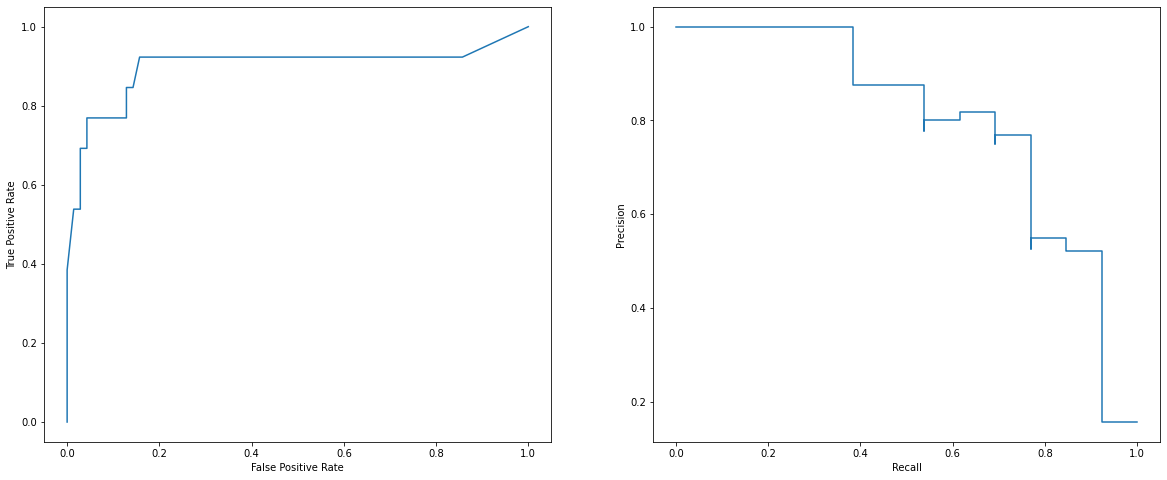

In [152]:
y_prob = clf_xgb.predict_proba(X_test_p)
probabilities = y_prob[:,1]

fpr_gan_p, tpr_gan_p, _ = roc_curve(y_test_p, probabilities)
roc_display_gan_p = RocCurveDisplay(fpr=fpr_gan_p, tpr=tpr_gan_p)
roc_auc_gan_p = auc(fpr_gan_p, tpr_gan_p)

prec_gan_p, recall_gan_p, _ = precision_recall_curve(y_test_p, probabilities)
pr_auc_gan_p = auc(recall_gan_p, prec_gan_p)
pr_display_gan_p = PrecisionRecallDisplay(precision=prec_gan_p, recall=recall_gan_p)

print('ROC AUC:', roc_auc_gan_p)
print('Precision-Recall AUC:', pr_auc_gan_p)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_gan_p.plot(ax=ax1)
pr_display_gan_p.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


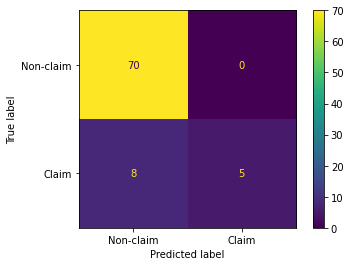

In [153]:
plot_confusion_matrix(clf_xgb, X_test_p, y_test_p, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:09:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'BrokerUltimateName_JOHN_HOLMAN_&_SONS_LTD': 1, 'Full_GGTP': 1, 'BrokerFeePct': 1, 'SubClass_RETAILERS': 1, 'Territory_NEVADA': 1, 'PricingStrength': 1, 'Full_GrossGrossModelPrice': 1}
gain:  {'BrokerUltimateName_JOHN_HOLMAN_&_SONS_LTD': 385.405731, 'Full_GGTP': 23.966629, 'BrokerFeePct': 13.1460114, 'SubClass_RETAILERS': 5.19034672, 'Territory_NEVADA': 1.57588196, 'PricingStrength': 2.4242425, 'Full_GrossGrossModelPrice': 2.0}
cover:  {'BrokerUltimateName_JOHN_HOLMAN_&_SONS_LTD': 139.5, 'Full_GGTP': 82.0, 'BrokerFeePct': 77.5, 'SubClass_RETAILERS': 20.0, 'Territory_NEVADA': 57.5, 'PricingStrength': 4.5, 'Full_GrossGrossModelPrice': 2.5}
total_gain:  {'BrokerUltimateName_JOHN_HOLMAN_&_SONS_LTD': 385.405731, 'Full_GGTP': 23.96662

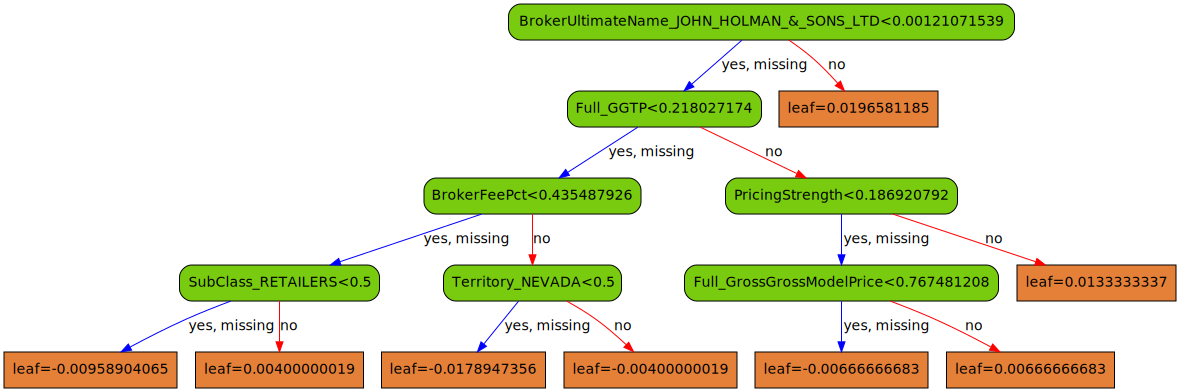

In [154]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                           gamma=0,
                          learning_rate=0.01,
                          max_depth=4,
                          reg_lambda=1,
                          scale_pos_weight=1,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_gan_p, y_gan_p)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


#### Excess Business

In [155]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_gan_e, y_gan_e, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

In [156]:
# print(optimal_params.best_params_)

In [157]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                         gamma=1,
                          learning_rate=0.1,
                          max_depth=5,
                          reg_lambda=1,
                          scale_pos_weight=1,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5)
clf_xgb.fit(X_gan_e, y_gan_e, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

[0]	validation_0-aucpr:0.38551
[1]	validation_0-aucpr:0.43040


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-aucpr:0.49928
[3]	validation_0-aucpr:0.55355
[4]	validation_0-aucpr:0.55812
[5]	validation_0-aucpr:0.55851
[6]	validation_0-aucpr:0.56239
[7]	validation_0-aucpr:0.55133
[8]	validation_0-aucpr:0.55163
[9]	validation_0-aucpr:0.54945
[10]	validation_0-aucpr:0.57878
[11]	validation_0-aucpr:0.57941
[12]	validation_0-aucpr:0.57328
[13]	validation_0-aucpr:0.56577
[14]	validation_0-aucpr:0.56389
[15]	validation_0-aucpr:0.56750
[16]	validation_0-aucpr:0.56581
[17]	validation_0-aucpr:0.56916
[18]	validation_0-aucpr:0.56850
[19]	validation_0-aucpr:0.57524
[20]	validation_0-aucpr:0.58652
[21]	validation_0-aucpr:0.59068
[22]	validation_0-aucpr:0.58875
[23]	validation_0-aucpr:0.58665
[24]	validation_0-aucpr:0.58110
[25]	validation_0-aucpr:0.58442
[26]	validation_0-aucpr:0.58951
[27]	validation_0-aucpr:0.58873
[28]	validation_0-aucpr:0.58744
[29]	validation_0-aucpr:0.58452
[30]	validation_0-aucpr:0.58612


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [158]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.59068
Best iteration: 21


In [159]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_e)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_e, predictions)
report = classification_report(y_test_e, predictions)
roc_auc = roc_auc_score(y_test_e, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 74.74%
ROC AUC: 0.5905723905723906
              precision    recall  f1-score   support

         0.0       0.75      0.96      0.84       270
         1.0       0.71      0.22      0.33       110

    accuracy                           0.75       380
   macro avg       0.73      0.59      0.59       380
weighted avg       0.74      0.75      0.70       380



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.7662962962962963
Precision-Recall AUC: 0.5905880091360595


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


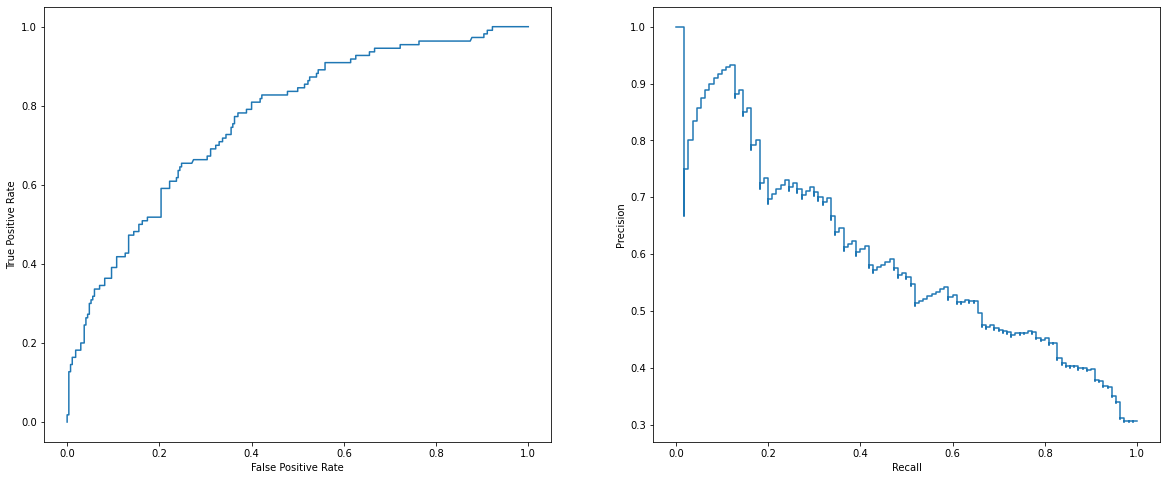

In [160]:
y_prob = clf_xgb.predict_proba(X_test_e)
probabilities = y_prob[:,1]

fpr_gan_e, tpr_gan_e, _ = roc_curve(y_test_e, probabilities)
roc_display_gan_e = RocCurveDisplay(fpr=fpr_gan_e, tpr=tpr_gan_e)
roc_auc_gan_e = auc(fpr_gan_e, tpr_gan_e)

prec_gan_e, recall_gan_e, _ = precision_recall_curve(y_test_e, probabilities)
pr_display_gan_e = PrecisionRecallDisplay(precision=prec_gan_e, recall=recall_gan_e)
pr_auc_gan_e = auc(recall_gan_e, prec_gan_e)

print('ROC AUC:', roc_auc_gan_e)
print('Precision-Recall AUC:', pr_auc_gan_e)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_gan_e.plot(ax=ax1)
pr_display_gan_e.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


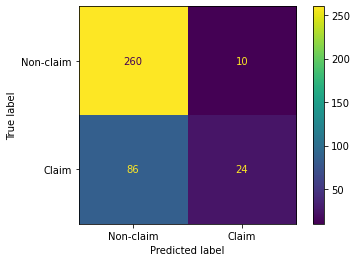

In [161]:
plot_confusion_matrix(clf_xgb, X_test_e, y_test_e, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:09:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'PLR_band_ex_adj_Upper_Quantile': 1, 'Full_GGWP': 2, 'BrokerUltimateName_WILLIS': 1, 'Ded_100Pct_USD': 2, 'SubClass_LEISURE_/_HOTELS_/_ENTERTAINMENT': 1, 'PLR': 1, 'SubClass_PROPERTY_/_REAL_ESTATE': 1, 'SubClass_PHARMACEUTICALS_/_BIO-TECHNOLOGY': 1, 'XS_100Pct_USD': 1, 'BrokerFeePct': 2, 'BrokerUltimateName_MARSH': 1}
gain:  {'PLR_band_ex_adj_Upper_Quantile': 864.667297, 'Full_GGWP': 40.1188803, 'BrokerUltimateName_WILLIS': 16.9572754, 'Ded_100Pct_USD': 5.207498905, 'SubClass_LEISURE_/_HOTELS_/_ENTERTAINMENT': 6.12304688, 'PLR': 3.4200902, 'SubClass_PROPERTY_/_REAL_ESTATE': 8.56140423, 'SubClass_PHARMACEUTICALS_/_BIO-TECHNOLOGY': 39.8400536, 'XS_100Pct_USD': 30.7786789, 'BrokerFeePct': 11.649461515, 'BrokerUltimateName_MARSH': 6

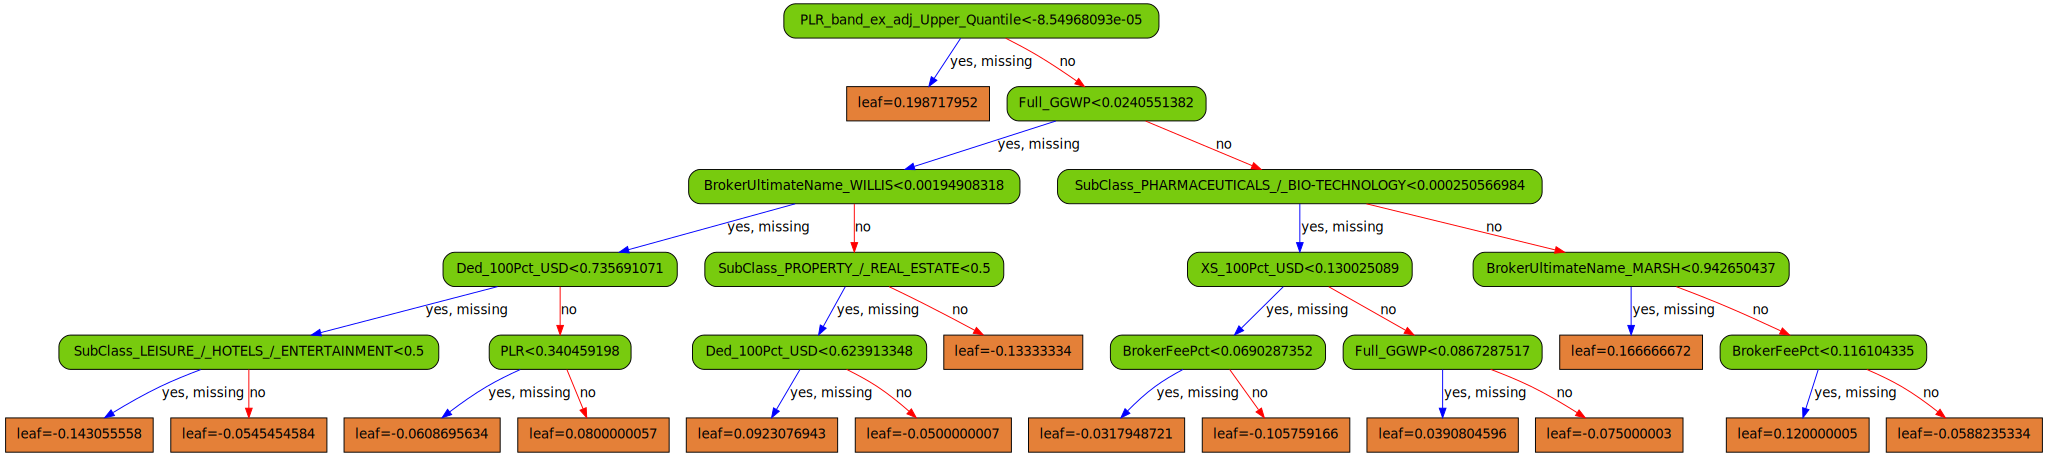

In [162]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=1,
                          learning_rate=0.1,
                          max_depth=5,
                          reg_lambda=1,
                          scale_pos_weight=1,
                           seed=42,
                           n_estimators=1
                           )
clf_xgb.fit(X_gan_e, y_gan_e)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


## cGAN

#### Primary Business

In [163]:
# rand_dim = len(train_no_label_p.columns) # 32 # needs to be ~data_dim
# base_n_count = 128 # 128

# nb_steps = 10000 + 1 # 50000 # Add one for logging of the last interval
# batch_size = 32 # 64

# k_d = 1  # number of critic network updates per adversarial training step
# k_g = 1  # number of generator network updates per adversarial training step
# critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
# log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
# learning_rate = 5e-4 # 5e-5
# # data_dir = 'cache/'
# # generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None
# # show = True 

In [164]:
# with_class = True
# data_cols = train_no_label_p.columns
# data_cols_w_class = train_p.columns
# data_dim = len(data_cols)
# print('data_dim: ', data_dim)
# print('data_cols: ', data_cols)

# label_dim = 0
# label_dim = len(label_cols)
# print('label_dim: ', label_dim)
# print('label_cols: ', label_cols)
    

# K.set_learning_phase(1) # 1 = train

# cache_prefix = 'CGAN'

# generator_input_tensor = layers.Input(shape=(rand_dim, ))
# labels_tensor = layers.Input(shape=(label_dim,)) # updated for class
# generated_image_tensor = generator_network_w_label(generator_input_tensor, labels_tensor, data_dim, label_dim, base_n_count) # updated for class

# generated_or_real_image_tensor = layers.Input(shape=(data_dim + label_dim,)) # updated for class
    
# discriminator_output = discriminator_network(generated_or_real_image_tensor, data_dim + label_dim, base_n_count)

# generator_model = models.Model(inputs=[generator_input_tensor, labels_tensor], outputs=[generated_image_tensor], name='generator') # updated for class
# discriminator_model = models.Model(inputs=[generated_or_real_image_tensor],
#                                    outputs=[discriminator_output],
#                                    name='discriminator')

# combined_output = discriminator_model(generator_model([generator_input_tensor, labels_tensor])) # updated for class
# combined_model = models.Model(inputs=[generator_input_tensor, labels_tensor], outputs=[combined_output], name='combined') # updated for class

In [165]:
# adam = optimizers.Adam(lr=learning_rate, beta_1=0.5, beta_2=0.9)

# generator_model.compile(optimizer=adam, loss='binary_crossentropy')
# discriminator_model.compile(optimizer=adam, loss='binary_crossentropy')
# discriminator_model.trainable = False
# combined_model.compile(optimizer=adam, loss='binary_crossentropy')

# # print(generator_model.summary())
# # print(discriminator_model.summary())
# # print(combined_model.summary())

In [166]:
# combined_loss, disc_loss_generated, disc_loss_real, xgb_losses = [], [], [], []

In [167]:
# for i in range(0, nb_steps):
#     K.set_learning_phase(1)
    
#     # train the discriminator
#     for j in range(k_d):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         x = get_data_batch(train_p, batch_size, seed=i+j)
            
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
# #             print(g_z)
#         else:
#             g_z = generator_model.predict(z)
# #             x = np.vstack([x,g_z]) # code to train the discriminator on real and generated data at the same time, but you have to run network again for separate losses
# #             classes = np.hstack([np.zeros(batch_size),np.ones(batch_size)])
# #             d_l_r = discriminator_model.train_on_batch(x, classes)
            
#         d_l_r = discriminator_model.train_on_batch(x, np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#         d_l_g = discriminator_model.train_on_batch(g_z, np.random.uniform(low=0.0, high=0.001, size=batch_size)) # 0.0, 0.3 # GANs need noise to prevent loss going to zero
# #             # d_l_r = discriminator_model.train_on_batch(x, np.ones(batch_size)) # without noise
# #             # d_l_g = discriminator_model.train_on_batch(g_z, np.zeros(batch_size)) # without noise
#     disc_loss_real.append(d_l_r)
#     disc_loss_generated.append(d_l_g)
    
#     # train the generator
#     for j in range(k_g):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         if with_class:
#             # loss = combined_model.train_on_batch([z, labels], np.ones(batch_size)) # without noise
#             loss = combined_model.train_on_batch([z, labels], np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#         else:
#             # loss = combined_model.train_on_batch(z, np.ones(batch_size)) # without noise
#             loss = combined_model.train_on_batch(z, np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#     combined_loss.append(loss)
    
#     # Determine xgb loss each step, after training generator and discriminator
#     if not i % 10: # 2x faster than testing each step...
#         K.set_learning_phase(0) # 0 = test
#         test_size = np.sum(train_p['Class']==1) - 1 # test using all of the actual fraud data - 1
#         x = get_data_batch(train_p, test_size, seed=i)
#         z = np.random.normal(size=(test_size, rand_dim))
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
#         else:
#             g_z = generator_model.predict(z)
#         xgb_loss = CheckAccuracyConditional( x, g_z, data_cols, label_cols, seed=42, with_class=with_class, data_dim=data_dim )
#         xgb_losses = np.append(xgb_losses, xgb_loss)
    
#     # Saving weights and plotting images
#     if not i % log_interval:
#         print('Step: {} of {}.'.format(i, nb_steps))
#         K.set_learning_phase(0) # 0 = test
                        
#         # loss summaries      
#         print( 'Losses: G, D Gen, D Real, Xgb: {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(combined_loss[-1], disc_loss_generated[-1], disc_loss_real[-1], xgb_losses[-1]) )
#         print( 'D Real - D Gen: {:.4f}'.format(disc_loss_real[-1]-disc_loss_generated[-1]) )    

In [168]:
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1, 3, 1)
# ax2 = fig.add_subplot(1, 3, 2)
# ax3 = fig.add_subplot(1, 3, 3)

# ax1.plot(combined_loss)
# ax1.set_title('Generator Loss')
# ax1.set_xlabel('Step')
# ax1.set_ylabel('Loss')

# ax2.plot(disc_loss_generated)
# ax2.set_title('Discriminator Loss of Generated Data')
# ax2.set_xlabel('Step')
# ax2.set_ylabel('Loss')

# ax3.plot(disc_loss_real)
# ax3.set_title('Discriminator Loss of Real Data')
# ax3.set_xlabel('Step')
# ax3.set_ylabel('Loss')

# plt.show()

In [169]:
# # Predicting the generated data
# samples = len(X_train_res_p) - len(X_train_p)
# new_z = np.random.normal(size=(samples,rand_dim))
# labels_z = np.ones((samples,1))
# new_g_z = generator_model.predict([new_z, labels_z])

In [170]:
# cgan_samples_p = pd.DataFrame(new_g_z, columns=train_p.columns)
# # Saving the dataset
# cgan_samples_p.to_csv('dandoww_cgan_primary.csv',index=False)

In [171]:
# Loading the dataset
cgan_samples_p = pd.read_csv('../input/project/dandoww_cgan_primary.csv')
cgan_samples_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,"BrokerUltimateName_NAUSCH_HOGAN_AND_MURRAY,_INC",BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Upper_Middle,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle,Class
0,0.248711,0.028204,1.001984,0.002415,0.751050,0.280055,0.619039,0.172018,0.121293,0.091230,...,-0.001566,0.004872,-0.002334,-0.000763,0.001849,-0.000844,-0.000602,1.015637,0.001287,1.0
1,0.247565,0.044110,1.002744,0.002639,0.753848,0.285154,0.651234,0.168165,0.085524,0.094018,...,-0.001015,0.004271,-0.002131,-0.000799,0.002412,-0.001111,-0.001200,1.018197,0.001115,1.0
2,0.250917,0.010849,1.008808,0.002424,0.758387,0.277743,0.595721,0.175465,0.156473,0.091218,...,-0.002189,0.004512,-0.001748,-0.000937,0.002755,-0.001450,-0.000731,1.020937,0.000850,1.0
3,0.250917,0.010849,1.008808,0.002424,0.758387,0.277743,0.595721,0.175465,0.156473,0.091218,...,-0.002189,0.004512,-0.001748,-0.000937,0.002755,-0.001450,-0.000731,1.020937,0.000850,1.0
4,0.246920,0.040607,0.998234,0.002360,0.747912,0.282138,0.637606,0.169331,0.095686,0.092013,...,-0.000669,0.004799,-0.002618,-0.001124,0.001303,-0.000777,-0.001255,1.013380,0.001637,1.0


In [172]:
cgan_samples_p.drop('Class', axis=1, inplace=True)
cgan_samples_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_JOHN_HOLMAN_&_SONS_LTD,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,"BrokerUltimateName_NAUSCH_HOGAN_AND_MURRAY,_INC",BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Upper_Middle,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle
0,0.248711,0.028204,1.001984,0.002415,0.751050,0.280055,0.619039,0.172018,0.121293,0.091230,...,0.001749,-0.001566,0.004872,-0.002334,-0.000763,0.001849,-0.000844,-0.000602,1.015637,0.001287
1,0.247565,0.044110,1.002744,0.002639,0.753848,0.285154,0.651234,0.168165,0.085524,0.094018,...,0.001396,-0.001015,0.004271,-0.002131,-0.000799,0.002412,-0.001111,-0.001200,1.018197,0.001115
2,0.250917,0.010849,1.008808,0.002424,0.758387,0.277743,0.595721,0.175465,0.156473,0.091218,...,0.002213,-0.002189,0.004512,-0.001748,-0.000937,0.002755,-0.001450,-0.000731,1.020937,0.000850
3,0.250917,0.010849,1.008808,0.002424,0.758387,0.277743,0.595721,0.175465,0.156473,0.091218,...,0.002213,-0.002189,0.004512,-0.001748,-0.000937,0.002755,-0.001450,-0.000731,1.020937,0.000850
4,0.246920,0.040607,0.998234,0.002360,0.747912,0.282138,0.637606,0.169331,0.095686,0.092013,...,0.001750,-0.000669,0.004799,-0.002618,-0.001124,0.001303,-0.000777,-0.001255,1.013380,0.001637


In [173]:
X_cgan_p = X_train_p.append(cgan_samples_p, ignore_index = True)
X_cgan_p.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_JOHN_HOLMAN_&_SONS_LTD,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,"BrokerUltimateName_NAUSCH_HOGAN_AND_MURRAY,_INC",BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Upper_Middle,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle
count,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,...,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000
mean,0.187257,0.049523,0.906250,0.012209,0.657236,0.273497,0.561822,0.202707,0.345966,0.095245,...,0.004314,0.022659,0.096807,0.011737,0.031912,0.045811,0.141084,0.157318,0.599177,0.118702
std,0.134568,0.090460,0.224581,0.066188,0.127640,0.047810,0.180616,0.067480,0.260403,0.078687,...,0.059778,0.151083,0.292869,0.111494,0.176907,0.206842,0.349130,0.364960,0.498539,0.323074
min,0.000000,0.000000,0.000000,0.000000,0.177000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.002399,0.000000,-0.002706,-0.001161,0.000000,-0.001768,-0.001406,0.000000,-0.000208
25%,0.078481,0.010849,1.000000,0.000500,0.577150,0.263959,0.544071,0.167932,0.094234,0.054136,...,0.000000,-0.001261,0.000000,-0.001748,-0.000889,0.000000,-0.001125,-0.000731,0.000000,0.000000
50%,0.245383,0.023964,1.000000,0.002424,0.713000,0.263959,0.598550,0.175465,0.171368,0.091219,...,0.000000,0.000000,0.003687,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000723
75%,0.249977,0.044802,1.003823,0.002827,0.755401,0.281108,0.649474,0.208352,0.596223,0.095697,...,0.001665,0.000000,0.004512,0.000000,0.000000,0.002704,0.000000,0.000000,1.018335,0.001194
max,1.000000,1.000000,1.017976,1.000000,0.846999,1.000000,1.000000,0.836142,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.034264,1.000000


In [174]:
X_train_p.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_JOHN_HOLMAN_&_SONS_LTD,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,"BrokerUltimateName_NAUSCH_HOGAN_AND_MURRAY,_INC",BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Upper_Middle,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle
count,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,...,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000
mean,0.144531,0.064002,0.837913,0.018893,0.589426,0.267959,0.518468,0.224191,0.502811,0.097125,...,0.006061,0.039394,0.160606,0.021212,0.054545,0.075758,0.239394,0.266667,0.309091,0.200000
std,0.161786,0.114778,0.271871,0.085482,0.127599,0.061516,0.223887,0.081042,0.231636,0.102332,...,0.077731,0.194826,0.367725,0.144310,0.227436,0.265012,0.427362,0.442888,0.462821,0.400607
min,0.000000,0.000000,0.000000,0.000000,0.177000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.017739,0.006731,0.568966,0.000309,0.509525,0.263959,0.472085,0.166667,0.339047,0.032611,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.097923,0.020469,1.000000,0.001000,0.610050,0.263959,0.571924,0.201389,0.596223,0.065340,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.198154,0.068550,1.000000,0.005616,0.698225,0.263959,0.652750,0.241071,0.660517,0.132079,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,0.846999,1.000000,1.000000,0.836142,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [175]:
ones = np.ones((len(cgan_samples_p),))
one = pd.Series(ones)
y_cgan_p = y_train_p.append(one, ignore_index=True)
# y_cgan_p

#### Excess Business

In [176]:
# rand_dim = len(train_no_label_e.columns) # 32 # needs to be ~data_dim
# base_n_count = 128 # 128

# nb_steps = 10000 + 1 # 50000 # Add one for logging of the last interval
# batch_size = 128 # 64

# k_d = 1  # number of critic network updates per adversarial training step
# k_g = 1  # number of generator network updates per adversarial training step
# critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
# log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
# learning_rate = 5e-4 # 5e-5
# # data_dir = 'cache/'
# # generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None
# # show = True 

In [177]:
# with_class = True
# data_cols = train_no_label_e.columns
# data_cols_w_class = train_e.columns
# data_dim = len(data_cols)
# print('data_dim: ', data_dim)
# print('data_cols: ', data_cols)

# label_dim = 0
# label_dim = len(label_cols)
# print('label_dim: ', label_dim)
# print('label_cols: ', label_cols)
    

# K.set_learning_phase(1) # 1 = train

# cache_prefix = 'CGAN'

# generator_input_tensor = layers.Input(shape=(rand_dim, ))
# labels_tensor = layers.Input(shape=(label_dim,)) # updated for class
# generated_image_tensor = generator_network_w_label(generator_input_tensor, labels_tensor, data_dim, label_dim, base_n_count) # updated for class

# generated_or_real_image_tensor = layers.Input(shape=(data_dim + label_dim,)) # updated for class
    
# discriminator_output = discriminator_network(generated_or_real_image_tensor, data_dim + label_dim, base_n_count)

# generator_model = models.Model(inputs=[generator_input_tensor, labels_tensor], outputs=[generated_image_tensor], name='generator') # updated for class
# discriminator_model = models.Model(inputs=[generated_or_real_image_tensor],
#                                    outputs=[discriminator_output],
#                                    name='discriminator')

# combined_output = discriminator_model(generator_model([generator_input_tensor, labels_tensor])) # updated for class
# combined_model = models.Model(inputs=[generator_input_tensor, labels_tensor], outputs=[combined_output], name='combined') # updated for class

In [178]:
# adam = optimizers.Adam(lr=learning_rate, beta_1=0.5, beta_2=0.9)

# generator_model.compile(optimizer=adam, loss='binary_crossentropy')
# discriminator_model.compile(optimizer=adam, loss='binary_crossentropy')
# discriminator_model.trainable = False
# combined_model.compile(optimizer=adam, loss='binary_crossentropy')

# # print(generator_model.summary())
# # print(discriminator_model.summary())
# # print(combined_model.summary())

In [179]:
# combined_loss, disc_loss_generated, disc_loss_real, xgb_losses = [], [], [], []

In [180]:
# for i in range(0, nb_steps):
#     K.set_learning_phase(1)
    
#     # train the discriminator
#     for j in range(k_d):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         x = get_data_batch(train_e, batch_size, seed=i+j)
            
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
# #             print(g_z)
#         else:
#             g_z = generator_model.predict(z)
# #             x = np.vstack([x,g_z]) # code to train the discriminator on real and generated data at the same time, but you have to run network again for separate losses
# #             classes = np.hstack([np.zeros(batch_size),np.ones(batch_size)])
# #             d_l_r = discriminator_model.train_on_batch(x, classes)
            
#         d_l_r = discriminator_model.train_on_batch(x, np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#         d_l_g = discriminator_model.train_on_batch(g_z, np.random.uniform(low=0.0, high=0.001, size=batch_size)) # 0.0, 0.3 # GANs need noise to prevent loss going to zero
# #             # d_l_r = discriminator_model.train_on_batch(x, np.ones(batch_size)) # without noise
# #             # d_l_g = discriminator_model.train_on_batch(g_z, np.zeros(batch_size)) # without noise
#     disc_loss_real.append(d_l_r)
#     disc_loss_generated.append(d_l_g)
    
#     # train the generator
#     for j in range(k_g):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         if with_class:
#             # loss = combined_model.train_on_batch([z, labels], np.ones(batch_size)) # without noise
#             loss = combined_model.train_on_batch([z, labels], np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#         else:
#             # loss = combined_model.train_on_batch(z, np.ones(batch_size)) # without noise
#             loss = combined_model.train_on_batch(z, np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#     combined_loss.append(loss)
    
#     # Determine xgb loss each step, after training generator and discriminator
#     if not i % 10: # 2x faster than testing each step...
#         K.set_learning_phase(0) # 0 = test
#         test_size = np.sum(train_e['Class']==1) # test using all of the actual fraud data
#         x = get_data_batch(train_e, test_size, seed=i)
#         z = np.random.normal(size=(test_size, rand_dim))
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
#         else:
#             g_z = generator_model.predict(z)
#         xgb_loss = CheckAccuracyConditional( x, g_z, data_cols, label_cols, seed=42, with_class=with_class, data_dim=data_dim )
#         xgb_losses = np.append(xgb_losses, xgb_loss)
    
#     # Saving weights and plotting images
#     if not i % log_interval:
#         print('Step: {} of {}.'.format(i, nb_steps))
#         K.set_learning_phase(0) # 0 = test
                        
#         # loss summaries      
#         print( 'Losses: G, D Gen, D Real, Xgb: {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(combined_loss[-1], disc_loss_generated[-1], disc_loss_real[-1], xgb_losses[-1]) )
#         print( 'D Real - D Gen: {:.4f}'.format(disc_loss_real[-1]-disc_loss_generated[-1]) )    

In [181]:
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1, 3, 1)
# ax2 = fig.add_subplot(1, 3, 2)
# ax3 = fig.add_subplot(1, 3, 3)

# ax1.plot(combined_loss)
# ax1.set_title('Generator Loss')
# ax1.set_xlabel('Step')
# ax1.set_ylabel('Loss')

# ax2.plot(disc_loss_generated)
# ax2.set_title('Discriminator Loss of Generated Data')
# ax2.set_xlabel('Step')
# ax2.set_ylabel('Loss')

# ax3.plot(disc_loss_real)
# ax3.set_title('Discriminator Loss of Real Data')
# ax3.set_xlabel('Step')
# ax3.set_ylabel('Loss')

# plt.show()

In [182]:
# # Predicting the generated data
# samples = len(X_train_res_e) - len(X_train_e)
# new_z = np.random.normal(size=(samples,rand_dim))
# labels_z = np.ones((samples,1))
# new_g_z = generator_model.predict([new_z, labels_z])

In [183]:
# cgan_samples_e = pd.DataFrame(new_g_z, columns=train_e.columns)
# # Saving the dataset
# cgan_samples_e.to_csv('dandoww_cgan_excess.csv',index=False)

In [184]:
# Loading the dataset
cgan_samples_e = pd.read_csv('../input/project/dandoww_cgan_excess.csv')
cgan_samples_e.head()

,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,...,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle,PLR_band_ex_adj_Upper_Quantile,Class
0,0.033684,0.561292,0.039834,0.309140,0.129975,-0.008256,0.278236,0.302150,0.673478,0.205162,...,0.002213,0.003315,1.009542,-0.002559,-0.004482,0.003518,0.006295,0.966648,0.008351,1.0
1,0.050029,0.570990,0.047258,0.328148,0.127295,-0.012364,0.294030,0.303101,0.701198,0.203636,...,-0.002518,0.001482,1.054088,-0.007127,0.001785,0.003343,0.008191,0.981705,0.013947,1.0
2,0.037575,0.565078,0.034046,0.315569,0.127730,-0.006164,0.273207,0.310570,0.658218,0.211835,...,-0.000499,0.005137,1.003735,0.001088,-0.004945,-0.002809,0.003927,0.967458,0.006083,1.0
3,0.090103,0.630425,0.051457,0.241922,0.075115,-0.000664,0.297509,0.287672,0.633100,0.207897,...,0.001201,-0.001718,1.006659,-0.005562,-0.005099,-0.001128,0.956401,0.005599,0.002638,1.0
4,0.151351,0.590781,0.050113,0.257399,0.144237,0.002012,0.265431,0.298826,0.668517,0.231468,...,-0.002722,-0.000636,1.000194,0.002902,-0.005728,-0.003508,0.973459,-0.001834,0.003387,1.0


In [185]:
cgan_samples_e.drop('Class', axis=1, inplace=True)
cgan_samples_e.head()

,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,...,BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle,PLR_band_ex_adj_Upper_Quantile
0,0.033684,0.561292,0.039834,0.309140,0.129975,-0.008256,0.278236,0.302150,0.673478,0.205162,...,0.006149,0.002213,0.003315,1.009542,-0.002559,-0.004482,0.003518,0.006295,0.966648,0.008351
1,0.050029,0.570990,0.047258,0.328148,0.127295,-0.012364,0.294030,0.303101,0.701198,0.203636,...,0.005021,-0.002518,0.001482,1.054088,-0.007127,0.001785,0.003343,0.008191,0.981705,0.013947
2,0.037575,0.565078,0.034046,0.315569,0.127730,-0.006164,0.273207,0.310570,0.658218,0.211835,...,0.005609,-0.000499,0.005137,1.003735,0.001088,-0.004945,-0.002809,0.003927,0.967458,0.006083
3,0.090103,0.630425,0.051457,0.241922,0.075115,-0.000664,0.297509,0.287672,0.633100,0.207897,...,0.004725,0.001201,-0.001718,1.006659,-0.005562,-0.005099,-0.001128,0.956401,0.005599,0.002638
4,0.151351,0.590781,0.050113,0.257399,0.144237,0.002012,0.265431,0.298826,0.668517,0.231468,...,0.003053,-0.002722,-0.000636,1.000194,0.002902,-0.005728,-0.003508,0.973459,-0.001834,0.003387


In [186]:
X_cgan_e = X_train_e.append(cgan_samples_e, ignore_index = True)
X_cgan_e.describe()

,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,...,BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle,PLR_band_ex_adj_Upper_Quantile
count,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,...,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000
mean,0.094642,0.576312,0.047951,0.348938,0.103288,0.141674,0.283102,0.304427,0.662341,0.204485,...,0.010565,0.010861,0.058903,0.495200,0.141659,0.173815,0.192999,0.397504,0.295674,0.221438
std,0.096669,0.074064,0.063074,0.211763,0.072843,0.282370,0.057295,0.044509,0.109130,0.050754,...,0.095655,0.104836,0.235161,0.504882,0.348614,0.379784,0.395178,0.483468,0.453155,0.413787
min,0.000000,0.000000,0.000000,0.000000,0.000000,-0.023422,0.003809,0.000000,0.000000,0.000000,...,0.000000,-0.010121,-0.015430,0.000000,-0.016663,-0.011718,-0.011830,0.000000,-0.003313,-0.005742
25%,0.036366,0.538964,0.019901,0.234694,0.048135,0.000000,0.254905,0.297496,0.638021,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.067954,0.581202,0.037674,0.305759,0.097239,0.000000,0.279143,0.309986,0.669208,0.205851,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000374
75%,0.127343,0.614651,0.050363,0.387755,0.137022,0.001683,0.311424,0.309986,0.708297,0.223734,...,0.002795,0.000000,0.000000,1.000194,0.000926,0.000000,0.000880,0.978221,0.980091,0.007803
max,1.000000,1.000000,1.000000,1.000000,0.875197,0.967907,1.000000,0.957070,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.206548,1.000000,1.000000,1.000000,1.071345,1.041009,1.000000


In [187]:
X_train_e.describe()

,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,...,BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle,PLR_band_ex_adj_Upper_Quantile
count,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,...,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000
mean,0.099253,0.569165,0.049617,0.376919,0.095426,0.202503,0.285787,0.304439,0.661818,0.198655,...,0.013167,0.015800,0.083608,0.275181,0.201448,0.248190,0.275181,0.260039,0.312706,0.313364
std,0.110936,0.085943,0.074987,0.246454,0.083793,0.317881,0.067344,0.051901,0.129401,0.059094,...,0.114025,0.124742,0.276890,0.446753,0.401214,0.432105,0.446753,0.438800,0.463748,0.464014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003809,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.032776,0.519252,0.015486,0.195255,0.031779,0.000000,0.241779,0.287047,0.630661,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.067153,0.566168,0.027834,0.319796,0.076235,0.000000,0.291830,0.309986,0.680224,0.184028,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.127343,0.614725,0.053001,0.489796,0.129865,0.590751,0.325144,0.309986,0.726624,0.218750,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,0.875197,0.967907,1.000000,0.957070,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [188]:
ones = np.ones((len(cgan_samples_e),))
one = pd.Series(ones)
y_cgan_e = y_train_e.append(one, ignore_index=True)
# y_cgan_e

### XGBoost (cGAN)

#### Primary Business

In [189]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_cgan_p, y_cgan_p, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

In [190]:
# print(optimal_params.best_params_)

In [191]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0,
                          learning_rate=0.01,
                          max_depth=4,
                          reg_lambda=1,
                          scale_pos_weight=1,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5)
clf_xgb.fit(X_cgan_p, y_cgan_p, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

[0]	validation_0-aucpr:0.57010
[1]	validation_0-aucpr:0.70325
[2]	validation_0-aucpr:0.74553
[3]	validation_0-aucpr:0.79914
[4]	validation_0-aucpr:0.80282
[5]	validation_0-aucpr:0.78666
[6]	validation_0-aucpr:0.77752
[7]	validation_0-aucpr:0.78242
[8]	validation_0-aucpr:0.77392
[9]	validation_0-aucpr:0.79568


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-aucpr:0.79398
[11]	validation_0-aucpr:0.79628
[12]	validation_0-aucpr:0.79389
[13]	validation_0-aucpr:0.78087
[14]	validation_0-aucpr:0.78596


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [192]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.802816
Best iteration: 4


In [193]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_p)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_p, predictions)
report = classification_report(y_test_p, predictions)
roc_auc = roc_auc_score(y_test_p, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 90.36%
ROC AUC: 0.6923076923076923
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95        70
         1.0       1.00      0.38      0.56        13

    accuracy                           0.90        83
   macro avg       0.95      0.69      0.75        83
weighted avg       0.91      0.90      0.88        83



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.8983516483516484
Precision-Recall AUC: 0.8042441531384275


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


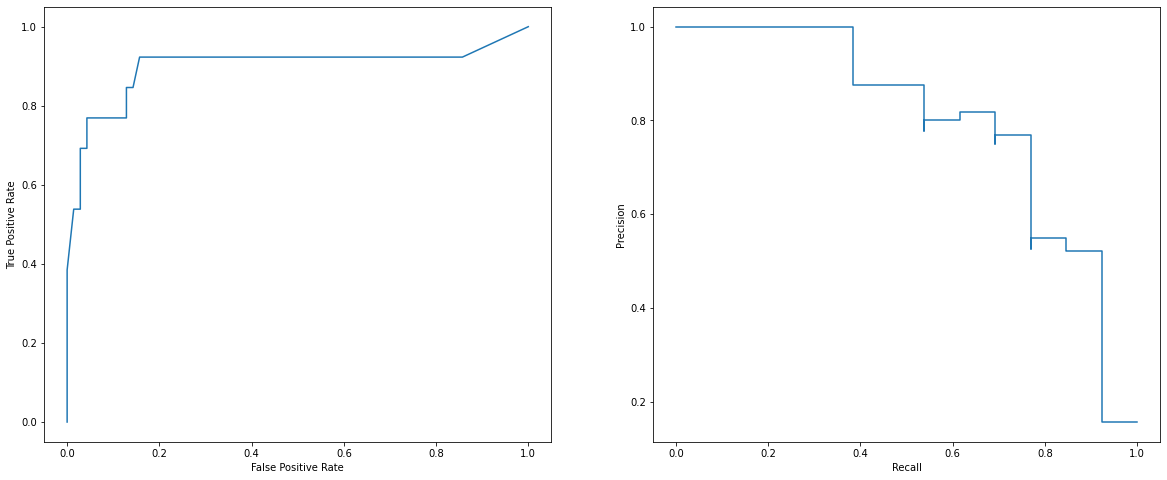

In [194]:
y_prob = clf_xgb.predict_proba(X_test_p)
probabilities = y_prob[:,1]

fpr_cgan_p, tpr_cgan_p, _ = roc_curve(y_test_p, probabilities)
roc_display_cgan_p = RocCurveDisplay(fpr=fpr_cgan_p, tpr=tpr_cgan_p)
roc_auc_cgan_p = auc(fpr_cgan_p, tpr_cgan_p)

prec_cgan_p, recall_cgan_p, _ = precision_recall_curve(y_test_p, probabilities)
pr_display_cgan_p = PrecisionRecallDisplay(precision=prec_cgan_p, recall=recall_cgan_p)
pr_auc_cgan_p = auc(recall_cgan_p, prec_cgan_p)

print('ROC AUC:', roc_auc_cgan_p)
print('Precision-Recall AUC:', pr_auc_cgan_p)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_cgan_p.plot(ax=ax1)
pr_display_cgan_p.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


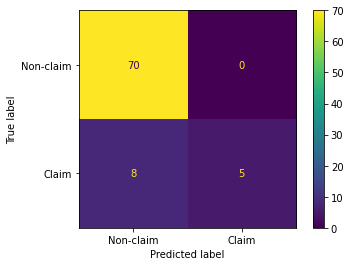

In [195]:
plot_confusion_matrix(clf_xgb, X_test_p, y_test_p, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:09:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'BrokerUltimateName_JOHN_HOLMAN_&_SONS_LTD': 1, 'Full_GGTP': 1, 'BrokerFeePct': 1, 'SubClass_RETAILERS': 1, 'Territory_NEVADA': 1, 'PricingStrength': 1, 'Full_GrossGrossModelPrice': 1}
gain:  {'BrokerUltimateName_JOHN_HOLMAN_&_SONS_LTD': 385.405731, 'Full_GGTP': 23.966629, 'BrokerFeePct': 13.1460114, 'SubClass_RETAILERS': 5.19034672, 'Territory_NEVADA': 1.57588196, 'PricingStrength': 2.4242425, 'Full_GrossGrossModelPrice': 2.0}
cover:  {'BrokerUltimateName_JOHN_HOLMAN_&_SONS_LTD': 139.5, 'Full_GGTP': 82.0, 'BrokerFeePct': 77.5, 'SubClass_RETAILERS': 20.0, 'Territory_NEVADA': 57.5, 'PricingStrength': 4.5, 'Full_GrossGrossModelPrice': 2.5}
total_gain:  {'BrokerUltimateName_JOHN_HOLMAN_&_SONS_LTD': 385.405731, 'Full_GGTP': 23.96662

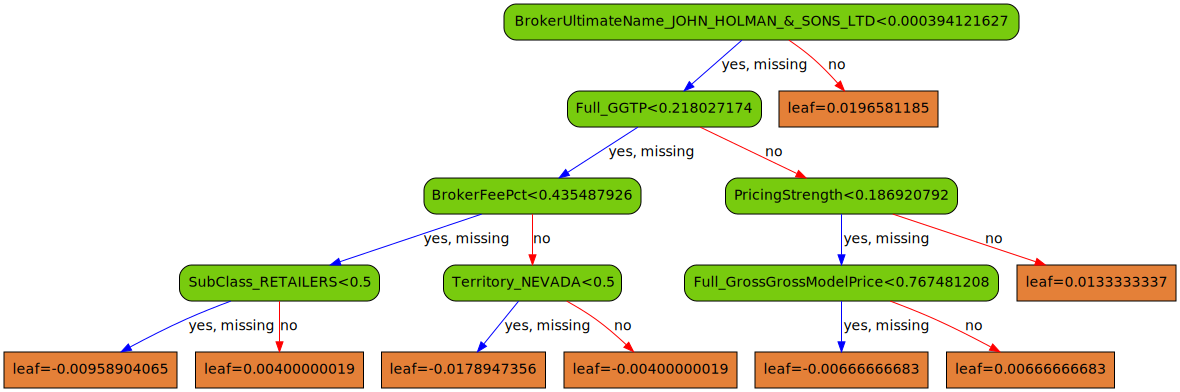

In [196]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0,
                          learning_rate=0.01,
                          max_depth=4,
                          reg_lambda=1,
                          scale_pos_weight=1,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_cgan_p, y_cgan_p)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


#### Excess Business

In [197]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_cgan_e, y_cgan_e, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

In [198]:
# print(optimal_params.best_params_)

In [199]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=1,
                          learning_rate=0.1,
                          max_depth=6,
                          reg_lambda=10,
                          scale_pos_weight=2,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5)
clf_xgb.fit(X_cgan_e, y_cgan_e, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

[0]	validation_0-aucpr:0.44196
[1]	validation_0-aucpr:0.43800
[2]	validation_0-aucpr:0.51887


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[3]	validation_0-aucpr:0.53412
[4]	validation_0-aucpr:0.53514
[5]	validation_0-aucpr:0.52512
[6]	validation_0-aucpr:0.52432
[7]	validation_0-aucpr:0.51244
[8]	validation_0-aucpr:0.50601
[9]	validation_0-aucpr:0.52235
[10]	validation_0-aucpr:0.51687
[11]	validation_0-aucpr:0.52135
[12]	validation_0-aucpr:0.51623
[13]	validation_0-aucpr:0.51606


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=2, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [200]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.535141
Best iteration: 4


In [201]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_e)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_e, predictions)
report = classification_report(y_test_e, predictions)
roc_auc = roc_auc_score(y_test_e, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 70.53%
ROC AUC: 0.6525252525252525
              precision    recall  f1-score   support

         0.0       0.80      0.78      0.79       270
         1.0       0.49      0.53      0.51       110

    accuracy                           0.71       380
   macro avg       0.65      0.65      0.65       380
weighted avg       0.71      0.71      0.71       380



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.7241750841750841
Precision-Recall AUC: 0.5385035479862739


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


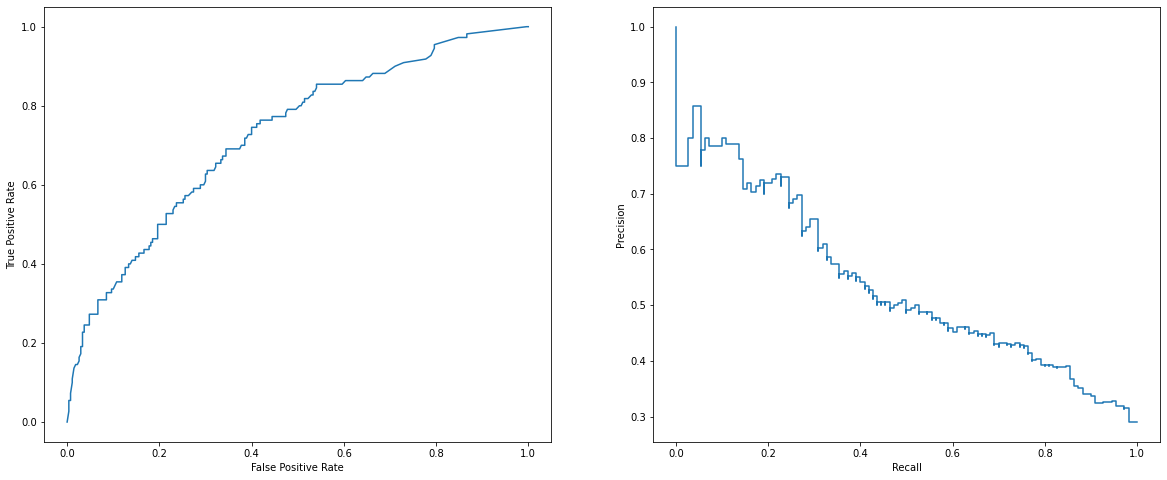

In [202]:
y_prob = clf_xgb.predict_proba(X_test_e)
probabilities = y_prob[:,1]

fpr_cgan_e, tpr_cgan_e, _ = roc_curve(y_test_e, probabilities)
roc_display_cgan_e = RocCurveDisplay(fpr=fpr_cgan_e, tpr=tpr_cgan_e)
roc_auc_cgan_e = auc(fpr_cgan_e, tpr_cgan_e)

prec_cgan_e, recall_cgan_e, _ = precision_recall_curve(y_test_e, probabilities)
pr_display_cgan_e = PrecisionRecallDisplay(precision=prec_cgan_e, recall=recall_cgan_e)
pr_auc_cgan_e = auc(recall_cgan_e, prec_cgan_e)

print('ROC AUC:', roc_auc_cgan_e)
print('Precision-Recall AUC:', pr_auc_cgan_e)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_cgan_e.plot(ax=ax1)
pr_display_cgan_e.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


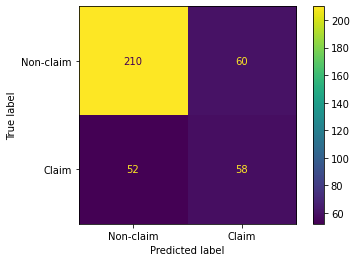

In [203]:
plot_confusion_matrix(clf_xgb, X_test_e, y_test_e, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:09:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'Territory_COLOMBIA': 2, 'Full_GGTP': 1, 'XS_100Pct_USD': 3, 'BrokerUltimateName_WILLIS': 1, 'Ded_100Pct_USD': 4, 'SubClass_LEISURE_/_HOTELS_/_ENTERTAINMENT': 1, 'Full_GrossGrossModelPrice': 1, 'SubClass_PROPERTY_/_REAL_ESTATE': 1, 'PLR': 1, 'BrokerUltimateName_MARSH': 1, 'SubClass_MINING': 1, 'Full_GGWP': 2, 'BrokerFeePct': 1, 'ModelToActualRto': 1, 'StatsMinorClassCode_EP': 1, 'Limit_100Pct_USD': 1, 'Territory_GERMANY': 1, 'Territory_NETHERLANDS': 1, 'PricingStrength': 2}
gain:  {'Territory_COLOMBIA': 457.86924645, 'Full_GGTP': 110.283302, 'XS_100Pct_USD': 20.63779578, 'BrokerUltimateName_WILLIS': 12.515625, 'Ded_100Pct_USD': 5.9536379575, 'SubClass_LEISURE_/_HOTELS_/_ENTERTAINMENT': 7.91853333, 'Full_GrossGrossModelPrice': 1.

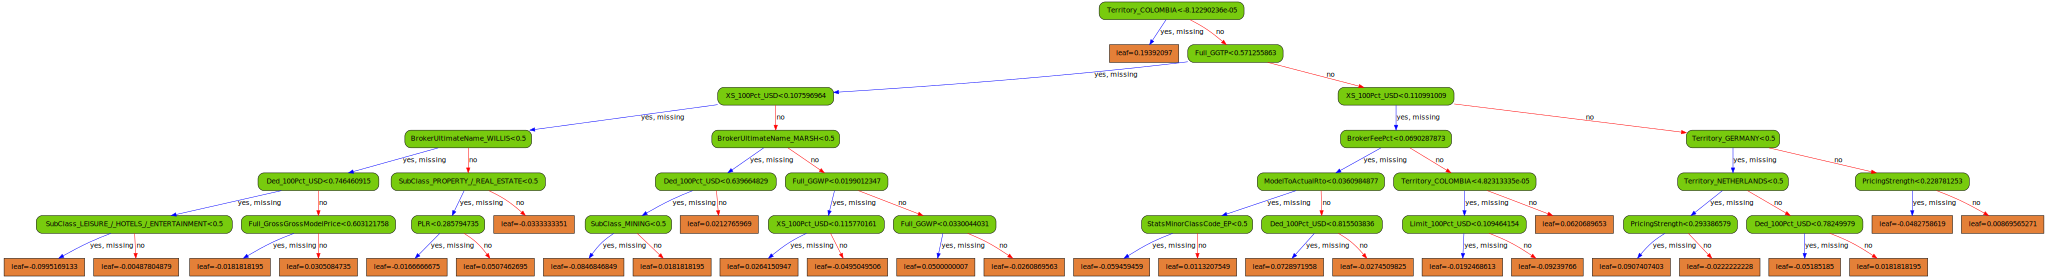

In [204]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                         gamma=1,
                          learning_rate=0.1,
                          max_depth=6,
                          reg_lambda=10,
                          scale_pos_weight=2,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_cgan_e, y_cgan_e)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


## WGAN

In [205]:
def critic_network(x, data_dim, base_n_count):
    x = layers.Dense(base_n_count*4, activation='relu')(x)
    # x = layers.Dropout(0.1)(x)
    x = layers.Dense(base_n_count*2, activation='relu')(x) # 2
    # x = layers.Dropout(0.1)(x)
    x = layers.Dense(base_n_count*1, activation='relu')(x) # 1
    # x = layers.Dense(base_n_count*4, activation='relu')(x) # extra
    # x = layers.Dense(base_n_count*4, activation='relu')(x) # extra
    # x = layers.Dense(1, activation='sigmoid')(x)
    x = layers.Dense(1)(x)
    return x

In [206]:
def em_loss(y_coefficients, y_pred):
    # define earth mover distance (wasserstein loss)
    # literally the weighted average of the critic network output
    # this is defined separately so it can be fed as a loss function to the optimizer in the WGANs
    return tf.reduce_mean(tf.multiply(y_coefficients, y_pred))

In [207]:
def train_discriminator_step_p(step, seed=42):
    
    if step == 0:
        init = tf.global_variables_initializer()
    
    if with_class:
        if step == 0:
            sess.run(init)
        d_l_g, d_l_r, _ = sess.run([_disc_loss_generated, _disc_loss_real, disc_optimizer], feed_dict={
            _z: np.random.normal(size=(batch_size, rand_dim)),
            _x: get_data_batch(train_p, batch_size, seed=seed),
            _labels: get_data_batch(train_p, batch_size, seed=seed)[:,-label_dim:], # .reshape(-1,label_dim), # updated for class            
            epsilon: np.random.uniform(low=0.0, high=1.0, size=(batch_size, 1))
        })
    else:
        if step == 0:
            sess.run(init)
        d_l_g, d_l_r, _ = sess.run([_disc_loss_generated, _disc_loss_real, disc_optimizer], feed_dict={
            _z: np.random.normal(size=(batch_size, rand_dim)),
            _x: get_data_batch(train_no_label_p, batch_size, seed=seed),
            epsilon: np.random.uniform(low=0.0, high=1.0, size=(batch_size, 1))
        })
        
    return d_l_g, d_l_r

In [208]:
def train_discriminator_step_e(step, seed=42):
    
    if step == 0:
        init = tf.global_variables_initializer()
    
    if with_class:
        if step == 0:
            sess.run(init)
        d_l_g, d_l_r, _ = sess.run([_disc_loss_generated, _disc_loss_real, disc_optimizer], feed_dict={
            _z: np.random.normal(size=(batch_size, rand_dim)),
            _x: get_data_batch(train_e, batch_size, seed=seed),
            _labels: get_data_batch(train_e, batch_size, seed=seed)[:,-label_dim:], # .reshape(-1,label_dim), # updated for class            
            epsilon: np.random.uniform(low=0.0, high=1.0, size=(batch_size, 1))
        })
    else:
        if step == 0:
            sess.run(init)
        d_l_g, d_l_r, _ = sess.run([_disc_loss_generated, _disc_loss_real, disc_optimizer], feed_dict={
            _z: np.random.normal(size=(batch_size, rand_dim)),
            _x: get_data_batch(train_no_label_e, batch_size, seed=seed),
            epsilon: np.random.uniform(low=0.0, high=1.0, size=(batch_size, 1))
        })
        
    return d_l_g, d_l_r

#### Primary Business

In [209]:
X_encoded_w_classes_p = X_train_p.copy()
X_encoded_w_classes_p['Class'] = y_train_p
X_encoded_w_classes_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,"BrokerUltimateName_NAUSCH_HOGAN_AND_MURRAY,_INC",BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Upper_Middle,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle,Class
161,0.017739,0.004671,1.0,0.000500,0.4811,0.263959,0.534054,0.241071,0.724812,0.135099,...,0,0,0,0,1,0,0,0,1,0.0
228,0.245383,0.025324,1.0,0.000000,0.5326,0.263959,0.523761,0.236111,0.081870,0.022363,...,0,0,0,0,0,0,0,0,0,0.0
287,0.065238,0.018378,1.0,0.001685,0.5612,0.263959,0.543699,0.235243,0.660517,0.041204,...,0,0,0,0,0,1,0,0,0,0.0
335,0.245383,0.042298,1.0,0.000000,0.4932,0.263959,0.670768,0.258333,0.596223,0.104932,...,0,0,0,0,0,0,0,1,0,0.0
289,0.198154,0.021396,1.0,0.000000,0.6983,0.263959,0.000000,0.166667,0.081870,0.000000,...,0,1,0,0,0,0,1,0,0,0.0


In [210]:
# Finding rows with class '1'
train_p = X_encoded_w_classes_p.loc[ X_encoded_w_classes_p.Class == 1 ].copy()
claim_w_classes_p = train_p.copy()
claim_w_classes_p['Class'] = y_train_p
# claim_w_classes_p.head()
train_p = claim_w_classes_p.copy().reset_index(drop=True)
# train_p.head()

label_cols = ['Class']
data_cols = [ i for i in train_p.columns if i not in label_cols ]
train_no_label_p = train_p.copy()
train_no_label_p.drop('Class', axis=1, inplace=True)
# train_no_label_p = train_p[ data_cols ]
train_no_label_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_JOHN_HOLMAN_&_SONS_LTD,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,"BrokerUltimateName_NAUSCH_HOGAN_AND_MURRAY,_INC",BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Upper_Middle,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle
0,0.037785,0.027338,1.000000,0.003000,0.4577,0.213198,0.596739,0.270833,0.596223,0.053135,...,0,0,0,0,0,0,0,0,0,0
1,0.017739,0.005358,1.000000,0.000500,0.6010,0.263959,0.498425,0.205729,0.596223,0.080535,...,0,0,0,0,0,0,1,0,1,0
2,1.000000,0.308956,0.245690,0.000000,0.3621,0.263959,0.774043,0.333940,0.711953,0.051500,...,0,0,0,0,0,0,0,0,0,0
3,0.245383,0.020760,1.000000,0.000309,0.7440,0.263959,0.587271,0.177083,0.153696,0.086984,...,0,0,0,0,0,0,0,0,1,0
4,0.398616,0.411987,0.461207,0.250000,0.6600,0.263959,0.816713,0.184028,0.118454,0.119398,...,0,0,1,0,0,0,0,1,1,0


In [211]:
# rand_dim = len(train_no_label_p.columns) # 32 # needs to be ~data_dim
# base_n_count = 128 # 128

# nb_steps = 10000 + 1 # 50000 # Add one for logging of the last interval
# batch_size = 32 # 64

# k_d = 1  # number of critic network updates per adversarial training step
# k_g = 1  # number of generator network updates per adversarial training step
# critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
# log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
# learning_rate = 1e-4 # 5e-5
# # data_dir = 'cache/'
# # generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None
# # show = True 

In [212]:
# data_cols = train_no_label_p.columns
# data_dim = len(data_cols)
# print('data_dim: ', data_dim)
# print('data_cols: ', data_cols)
    
# label_dim = 0
# with_class = False
# label_cols = []
    
# K.set_learning_phase(1) # 1 = train

# cache_prefix = 'WGAN'
# generator_input_tensor = layers.Input(shape=(rand_dim, ))
# generated_image_tensor = generator_network(generator_input_tensor, data_dim, base_n_count)

# generated_or_real_image_tensor = layers.Input(shape=(data_dim,))
# discriminator_output = critic_network(generated_or_real_image_tensor, data_dim, base_n_count)

# generator_model = models.Model(inputs=[generator_input_tensor], outputs=[generated_image_tensor], name='generator')
# discriminator_model = models.Model(inputs=[generated_or_real_image_tensor],
#                                        outputs=[discriminator_output],
#                                        name='discriminator')

# combined_output = discriminator_model(generator_model(generator_input_tensor))
# combined_model = models.Model(inputs=[generator_input_tensor], outputs=[combined_output], name='combined')

In [213]:
# _z = tf.placeholder(tf.float32, shape=(batch_size, rand_dim))
    
# _labels = None    

# _x = tf.placeholder(tf.float32, shape=(batch_size, data_dim))
# _g_z = generator_model(_z)

# epsilon = tf.placeholder(tf.float32, shape=(batch_size, 1))
    
# x_hat = epsilon * _x + (1.0 - epsilon) * _g_z
# gradients = tf.gradients(discriminator_model(x_hat), [x_hat])
# _gradient_penalty = 10.0 * tf.square(tf.norm(gradients[0], ord=2) - 1.0)

# # calculate discriminator's loss
# _disc_loss_generated = em_loss(tf.ones(batch_size), discriminator_model(_g_z))
# _disc_loss_real = em_loss(tf.ones(batch_size), discriminator_model(_x))
# _disc_loss = _disc_loss_generated - _disc_loss_real + _gradient_penalty

# # update f by taking an SGD step on mini-batch loss LD(f)
# disc_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.5, beta2=0.9).minimize(_disc_loss, var_list=discriminator_model.trainable_weights)

# sess = K.get_session()

# # compile models

# adam = optimizers.Adam(lr=learning_rate, beta_1=0.5, beta_2=0.9)

# discriminator_model.trainable = False
# combined_model.compile(optimizer=adam, loss=[em_loss])

# combined_loss, disc_loss_generated, disc_loss_real, xgb_losses = [], [], [], []

# # print(generator_model.summary())
# # print(discriminator_model.summary())
# # print(combined_model.summary())

In [214]:
# print('pre-training the critic...')
# K.set_learning_phase(1) # 1 = train
# for i in range(critic_pre_train_steps):
#     if i%20==0:
#         print('Step: {} of {} critic pre-training.'.format(i, critic_pre_train_steps))
#         loss = train_discriminator_step_p(step=0,seed=i)

# print('Last batch of critic pre-training disc_loss: {}.'.format(loss))

In [215]:
# for i in range(0, nb_steps):
#     K.set_learning_phase(1) # 1 = train
    
#     # train the discriminator
#     for j in range(k_d):
#         d_l_g, d_l_r = train_discriminator_step_p(step=i+1,seed=i+j)
#     disc_loss_generated.append(d_l_g)
#     disc_loss_real.append(d_l_r)
    
#     # train the generator
#     for j in range(k_g):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         if with_class:
#             labels = get_data_batch(train_p, batch_size, seed=i+j)[:,-label_dim:] # updated for class
#             loss = combined_model.train_on_batch([z, labels], [-np.ones(batch_size)]) # updated for class
#         else:
#             loss = combined_model.train_on_batch(z, [-np.ones(batch_size)])
#     combined_loss.append(loss)
    
#     # Determine xgb loss each step, after training generator and discriminator
#     if not i % 10: # 2x faster than testing each step...
#         K.set_learning_phase(0) # 0 = test
#         test_size = np.sum(train_p['Class']==1) - 1 # test using all of the actual claim data - 1
#         x = get_data_batch(train_no_label_p, test_size, seed=i)
#         z = np.random.normal(size=(test_size, rand_dim))
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
#         else:
#             g_z = generator_model.predict(z)
#         xgb_loss = CheckAccuracy( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim )
#         xgb_losses = np.append(xgb_losses, xgb_loss)
        
#     if not i % log_interval:
#         print('Step: {} of {}.'.format(i, nb_steps))
#         # K.set_learning_phase(0) # 0 = test
                        
#         # loss summaries   
#         print( 'Losses: G, D Gen, D Real, Xgb: {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(combined_loss[-1], disc_loss_generated[-1], disc_loss_real[-1], xgb_losses[-1]) )
#         print( 'D Real - D Gen: {:.4f}'.format(disc_loss_real[-1]-disc_loss_generated[-1]) )

In [216]:
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1, 3, 1)
# ax2 = fig.add_subplot(1, 3, 2)
# ax3 = fig.add_subplot(1, 3, 3)

# ax1.plot(combined_loss)
# ax1.set_title('Generator Loss')
# ax1.set_xlabel('Step')
# ax1.set_ylabel('Loss')

# ax2.plot(disc_loss_generated)
# ax2.set_title('Discriminator Loss of Generated Data')
# ax2.set_xlabel('Step')
# ax2.set_ylabel('Loss')

# ax3.plot(disc_loss_real)
# ax3.set_title('Discriminator Loss of Real Data')
# ax3.set_xlabel('Step')
# ax3.set_ylabel('Loss')

# plt.show()

In [217]:
# # Predicting the generated data
# samples = len(X_train_res_p) - len(X_train_p)
# new_z = np.random.normal(size=(samples,rand_dim))
# new_g_z = generator_model.predict(new_z)

In [218]:
# wgan_samples_p = pd.DataFrame(new_g_z, columns=data_cols)
# # Saving the dataset
# wgan_samples_p.to_csv('dandoww_wgan_primary.csv',index=False)

In [219]:
# Loading the dataset
wgan_samples_p = pd.read_csv('../input/project/dandoww_wgan_primary.csv')
wgan_samples_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_JOHN_HOLMAN_&_SONS_LTD,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,"BrokerUltimateName_NAUSCH_HOGAN_AND_MURRAY,_INC",BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Upper_Middle,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle
0,0.186833,0.098475,0.957785,0.011940,0.680922,0.271774,0.147103,0.160531,0.068907,0.005980,...,-0.020241,0.010332,0.937357,-0.004159,0.030785,0.015947,-0.014946,0.977851,0.146203,0.002570
1,0.264216,0.050696,0.775879,0.047559,0.628977,0.241269,0.351605,0.182147,0.162210,0.132134,...,-0.007298,0.035124,0.689746,-0.019711,-0.048876,-0.057971,0.089827,0.743862,0.093539,-0.034317
2,0.256835,0.100214,0.454309,0.001852,0.730199,0.247625,0.816526,0.166040,0.381951,0.200219,...,0.010569,0.036150,-0.009299,0.028760,1.045108,0.001388,0.128827,1.365435,0.054948,0.628056
3,0.085789,0.072529,0.932555,0.004492,0.612619,0.307825,0.245574,0.195544,0.674656,0.069630,...,-0.026584,-0.018681,0.005249,-0.013008,0.107239,0.642844,0.909188,0.025072,0.020534,0.052491
4,0.335960,0.070859,0.872625,-0.041053,0.644024,0.372974,0.467526,0.187538,0.138967,0.069002,...,0.010789,0.027140,0.265495,-0.009941,-0.069464,0.021516,0.649214,0.172918,0.511187,0.004378


In [220]:
X_wgan_p = X_train_p.append(wgan_samples_p, ignore_index = True)
X_wgan_p.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_JOHN_HOLMAN_&_SONS_LTD,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,"BrokerUltimateName_NAUSCH_HOGAN_AND_MURRAY,_INC",BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Upper_Middle,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle
count,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,...,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000
mean,0.182072,0.101357,0.813742,0.026872,0.611109,0.285859,0.543208,0.218150,0.427214,0.091880,...,0.020067,0.047543,0.200104,0.022046,0.121801,0.060809,0.294080,0.305963,0.362991,0.184613
std,0.156498,0.151690,0.264350,0.103093,0.112175,0.075424,0.223906,0.070096,0.241335,0.100466,...,0.135606,0.196544,0.384473,0.133431,0.289503,0.218061,0.434514,0.436224,0.459282,0.357669
min,-0.073913,-0.074751,0.000000,-0.099814,0.177000,0.000000,-0.124638,0.000000,-0.078673,-0.313144,...,-0.138236,-0.176880,-0.283750,-0.117148,-0.109732,-0.155646,-0.210998,-0.182620,-0.105572,-0.125276
25%,0.047375,0.007690,0.544995,0.000000,0.550977,0.263959,0.477880,0.166667,0.180797,0.032009,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.186413,0.041075,1.000000,0.001769,0.627072,0.263959,0.596044,0.201454,0.500664,0.074600,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.042273,0.000000
75%,0.259154,0.151529,1.000000,0.023599,0.697688,0.296438,0.689843,0.241071,0.603854,0.127683,...,0.000000,0.000148,0.120595,0.000000,0.041230,0.016745,0.741446,0.837053,1.000000,0.094301
max,1.140458,1.014915,1.210216,1.000000,0.846999,1.008868,1.000000,0.836142,1.051306,1.000000,...,1.348985,1.341512,1.260122,1.000000,1.204856,1.000000,1.614535,1.365435,1.372338,1.189820


In [221]:
X_train_p.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_JOHN_HOLMAN_&_SONS_LTD,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,"BrokerUltimateName_NAUSCH_HOGAN_AND_MURRAY,_INC",BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Upper_Middle,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle
count,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,...,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000
mean,0.144531,0.064002,0.837913,0.018893,0.589426,0.267959,0.518468,0.224191,0.502811,0.097125,...,0.006061,0.039394,0.160606,0.021212,0.054545,0.075758,0.239394,0.266667,0.309091,0.200000
std,0.161786,0.114778,0.271871,0.085482,0.127599,0.061516,0.223887,0.081042,0.231636,0.102332,...,0.077731,0.194826,0.367725,0.144310,0.227436,0.265012,0.427362,0.442888,0.462821,0.400607
min,0.000000,0.000000,0.000000,0.000000,0.177000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.017739,0.006731,0.568966,0.000309,0.509525,0.263959,0.472085,0.166667,0.339047,0.032611,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.097923,0.020469,1.000000,0.001000,0.610050,0.263959,0.571924,0.201389,0.596223,0.065340,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.198154,0.068550,1.000000,0.005616,0.698225,0.263959,0.652750,0.241071,0.660517,0.132079,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,0.846999,1.000000,1.000000,0.836142,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [222]:
ones = np.ones((len(wgan_samples_p),))
one = pd.Series(ones)
y_wgan_p = y_train_p.append(one, ignore_index=True)
# y_wgan_p

#### Excess Business

In [223]:
X_encoded_w_classes_e = X_train_e.copy()
X_encoded_w_classes_e['Class'] = y_train_e
X_encoded_w_classes_e.head()

,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,...,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle,PLR_band_ex_adj_Upper_Quantile,Class
826,0.114050,0.617426,0.060234,0.030612,0.035984,0.530641,0.221555,0.210193,0.683076,0.232331,...,0,0,0,1,0,0,1,0,0,0.0
447,0.057123,0.520773,0.014839,0.240204,0.210151,0.000000,0.276326,0.277531,0.637512,0.176302,...,0,0,1,0,0,0,0,1,0,0.0
1210,0.026221,0.538964,0.019957,0.346020,0.108220,0.000000,0.252025,0.352610,0.716845,0.193359,...,0,0,1,0,0,0,0,0,1,1.0
1663,0.076522,0.595267,0.031501,0.489796,0.014581,0.000000,0.386192,0.262867,0.706239,0.145834,...,0,0,0,0,0,1,0,1,0,0.0
315,0.067954,0.575828,0.026549,0.319796,0.086575,0.000000,0.341237,0.309986,0.708364,0.158333,...,0,0,0,0,0,1,0,0,1,0.0


In [224]:
# Finding rows with class '1'
train_e = X_encoded_w_classes_e.loc[ X_encoded_w_classes_e.Class == 1 ].copy()
claim_w_classes_e = train_e.copy()
claim_w_classes_e['Class'] = y_train_e
# claim_w_classes_e.head()
train_e = claim_w_classes_e.copy().reset_index(drop=True)
# train_e.head()

label_cols = ['Class']
data_cols = [ i for i in train_e.columns if i not in label_cols ]
train_no_label_e = train_e.copy()
train_no_label_e.drop('Class', axis=1, inplace=True)
# train_no_label_e = train_e[ data_cols ]
train_no_label_e.head()

,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,...,BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle,PLR_band_ex_adj_Upper_Quantile
0,0.026221,0.538964,0.019957,0.346020,0.108220,0.000000,0.252025,0.352610,0.716845,0.193359,...,0,0,0,1,0,0,0,0,0,1
1,0.137510,0.560556,0.024887,0.183673,0.216446,0.650734,0.293439,0.262867,0.646901,0.183911,...,0,0,0,0,0,1,0,1,0,0
2,0.026221,0.561268,0.026992,0.489796,0.034627,0.000000,0.242476,0.323205,0.681138,0.200859,...,1,0,0,1,0,0,0,0,1,0
3,0.276159,0.623994,0.068404,0.120306,0.113257,0.771782,0.218926,0.309986,0.773354,0.245690,...,0,0,0,0,1,0,0,0,0,1
4,0.137510,0.614651,0.046490,0.209184,0.173156,0.000000,0.275146,0.287047,0.734016,0.177083,...,0,0,0,1,0,0,0,0,1,0


In [225]:
# rand_dim = len(train_no_label_e.columns) # 32 # needs to be ~data_dim
# base_n_count = 128 # 128

# nb_steps = 10000 + 1 # 50000 # Add one for logging of the last interval
# batch_size = 128 # 64

# k_d = 1  # number of critic network updates per adversarial training step
# k_g = 1  # number of generator network updates per adversarial training step
# critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
# log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
# learning_rate = 1e-4 # 5e-5
# # data_dir = 'cache/'
# # generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None
# # show = True 

In [226]:
# data_cols = train_no_label_e.columns
# data_dim = len(data_cols)
# print('data_dim: ', data_dim)
# print('data_cols: ', data_cols)
    
# label_dim = 0
# with_class = False
# label_cols = []
    
# K.set_learning_phase(1) # 1 = train

# cache_prefix = 'WGAN'
# generator_input_tensor = layers.Input(shape=(rand_dim, ))
# generated_image_tensor = generator_network(generator_input_tensor, data_dim, base_n_count)

# generated_or_real_image_tensor = layers.Input(shape=(data_dim,))
# discriminator_output = critic_network(generated_or_real_image_tensor, data_dim, base_n_count)

# generator_model = models.Model(inputs=[generator_input_tensor], outputs=[generated_image_tensor], name='generator')
# discriminator_model = models.Model(inputs=[generated_or_real_image_tensor],
#                                        outputs=[discriminator_output],
#                                        name='discriminator')

# combined_output = discriminator_model(generator_model(generator_input_tensor))
# combined_model = models.Model(inputs=[generator_input_tensor], outputs=[combined_output], name='combined')

In [227]:
# _z = tf.placeholder(tf.float32, shape=(batch_size, rand_dim))
    
# _labels = None    

# _x = tf.placeholder(tf.float32, shape=(batch_size, data_dim))
# _g_z = generator_model(_z)

# epsilon = tf.placeholder(tf.float32, shape=(batch_size, 1))
    
# x_hat = epsilon * _x + (1.0 - epsilon) * _g_z
# gradients = tf.gradients(discriminator_model(x_hat), [x_hat])
# _gradient_penalty = 10.0 * tf.square(tf.norm(gradients[0], ord=2) - 1.0)

# # calculate discriminator's loss
# _disc_loss_generated = em_loss(tf.ones(batch_size), discriminator_model(_g_z))
# _disc_loss_real = em_loss(tf.ones(batch_size), discriminator_model(_x))
# _disc_loss = _disc_loss_generated - _disc_loss_real + _gradient_penalty

# # update f by taking an SGD step on mini-batch loss LD(f)
# disc_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.5, beta2=0.9).minimize(_disc_loss, var_list=discriminator_model.trainable_weights)

# sess = K.get_session()

# # compile models

# adam = optimizers.Adam(lr=learning_rate, beta_1=0.5, beta_2=0.9)

# discriminator_model.trainable = False
# combined_model.compile(optimizer=adam, loss=[em_loss])

# combined_loss, disc_loss_generated, disc_loss_real, xgb_losses = [], [], [], []

# # print(generator_model.summary())
# # print(discriminator_model.summary())
# # print(combined_model.summary())

In [228]:
# print('pre-training the critic...')
# K.set_learning_phase(1) # 1 = train
# for i in range(critic_pre_train_steps):
#     if i%20==0:
#         print('Step: {} of {} critic pre-training.'.format(i, critic_pre_train_steps))
#         loss = train_discriminator_step_e(step=0,seed=i)

# print('Last batch of critic pre-training disc_loss: {}.'.format(loss))

In [229]:
# for i in range(0, nb_steps):
#     K.set_learning_phase(1) # 1 = train
    
#     # train the discriminator
#     for j in range(k_d):
#         d_l_g, d_l_r = train_discriminator_step_e(step=i+1,seed=i+j)
#     disc_loss_generated.append(d_l_g)
#     disc_loss_real.append(d_l_r)
    
#     # train the generator
#     for j in range(k_g):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         if with_class:
#             labels = get_data_batch(train_e, batch_size, seed=i+j)[:,-label_dim:] # updated for class
#             loss = combined_model.train_on_batch([z, labels], [-np.ones(batch_size)]) # updated for class
#         else:
#             loss = combined_model.train_on_batch(z, [-np.ones(batch_size)])
#     combined_loss.append(loss)
    
#     # Determine xgb loss each step, after training generator and discriminator
#     if not i % 10: # 2x faster than testing each step...
#         K.set_learning_phase(0) # 0 = test
#         test_size = np.sum(train_e['Class']==1) # test using all of the actual claim data
#         x = get_data_batch(train_no_label_e, test_size, seed=i)
#         z = np.random.normal(size=(test_size, rand_dim))
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
#         else:
#             g_z = generator_model.predict(z)
#         xgb_loss = CheckAccuracy( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim )
#         xgb_losses = np.append(xgb_losses, xgb_loss)
        
#     if not i % log_interval:
#         print('Step: {} of {}.'.format(i, nb_steps))
#         # K.set_learning_phase(0) # 0 = test
                        
#         # loss summaries   
#         print( 'Losses: G, D Gen, D Real, Xgb: {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(combined_loss[-1], disc_loss_generated[-1], disc_loss_real[-1], xgb_losses[-1]) )
#         print( 'D Real - D Gen: {:.4f}'.format(disc_loss_real[-1]-disc_loss_generated[-1]) )

In [230]:
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1, 3, 1)
# ax2 = fig.add_subplot(1, 3, 2)
# ax3 = fig.add_subplot(1, 3, 3)

# ax1.plot(combined_loss)
# ax1.set_title('Generator Loss')
# ax1.set_xlabel('Step')
# ax1.set_ylabel('Loss')

# ax2.plot(disc_loss_generated)
# ax2.set_title('Discriminator Loss of Generated Data')
# ax2.set_xlabel('Step')
# ax2.set_ylabel('Loss')

# ax3.plot(disc_loss_real)
# ax3.set_title('Discriminator Loss of Real Data')
# ax3.set_xlabel('Step')
# ax3.set_ylabel('Loss')

# plt.show()

In [231]:
# # Predicting the generated data
# samples = len(X_train_res_e) - len(X_train_e)
# new_z = np.random.normal(size=(samples,rand_dim))
# new_g_z = generator_model.predict(new_z)

In [232]:
# wgan_samples_e = pd.DataFrame(new_g_z, columns=data_cols)
# # Saving the dataset
# wgan_samples_e.to_csv('dandoww_wgan_excess.csv',index=False)

In [233]:
# Loading the dataset
wgan_samples_e = pd.read_csv('../input/project/dandoww_wgan_excess.csv')
wgan_samples_e.head()

,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,...,BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle,PLR_band_ex_adj_Upper_Quantile
0,0.024637,0.623364,0.025093,0.297947,0.046818,0.153267,0.320365,0.272431,0.738874,0.204251,...,-0.060433,-0.035964,-0.041634,1.026826,-0.035523,0.101565,-0.076889,-0.125893,0.663971,-0.128683
1,0.091803,0.517301,-0.062722,0.192627,0.073040,-0.068440,0.238537,0.364393,0.559878,0.248607,...,-0.048138,-0.039998,0.022702,0.902702,0.031910,0.016064,0.076720,0.195435,0.577494,-0.116216
2,0.305480,0.707285,-0.037006,0.066747,0.197519,0.507379,0.302074,0.212958,0.724688,0.049536,...,-0.059881,-0.018985,0.361223,-0.155964,-0.089636,0.009204,1.007474,0.243455,-0.155396,0.825164
3,0.048783,0.536224,-0.019147,0.358906,0.110082,-0.057201,0.224510,0.301593,0.624884,0.235277,...,0.122148,-0.139145,0.025822,-0.029176,0.985657,-0.039467,0.066882,0.191351,0.446316,0.011222
4,0.039237,0.667679,0.064997,0.176710,0.049455,-0.104647,0.255860,0.242359,0.485963,0.297427,...,-0.008177,0.084687,0.138314,0.122800,0.143883,0.950161,0.031225,1.037367,-0.158986,0.016558


In [234]:
X_wgan_e = X_train_e.append(wgan_samples_e, ignore_index = True)
X_wgan_e.describe()

,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,...,BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle,PLR_band_ex_adj_Upper_Quantile
count,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,...,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000
mean,0.109342,0.574846,0.051303,0.368168,0.105103,0.199521,0.285105,0.297429,0.672224,0.195545,...,0.010711,0.009224,0.091357,0.288078,0.196735,0.260877,0.260195,0.258817,0.322026,0.313172
std,0.111998,0.086601,0.077716,0.227756,0.089349,0.313204,0.069729,0.056942,0.123616,0.062645,...,0.107286,0.110304,0.275434,0.440836,0.387968,0.429822,0.427914,0.424811,0.460835,0.451491
min,-0.147083,0.000000,-0.139006,-0.012401,-0.149830,-0.449888,0.003809,0.000000,0.000000,-0.121145,...,-0.242877,-0.222825,-0.327247,-0.264365,-0.267576,-0.233558,-0.266737,-0.305213,-0.413637,-0.430951
25%,0.036711,0.524026,0.014742,0.213980,0.035984,0.000000,0.239861,0.277531,0.630743,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.067954,0.572456,0.031086,0.319796,0.086575,0.000000,0.287764,0.309986,0.684617,0.186306,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.137510,0.625738,0.064978,0.489796,0.154728,0.503239,0.325264,0.309986,0.735656,0.223470,...,0.000000,0.000000,0.000000,0.884138,0.091390,0.648208,0.568071,0.663722,1.000000,0.994798
max,1.000000,1.088121,1.000000,1.412958,0.875197,1.364094,1.000000,0.957070,1.049796,1.000000,...,1.000000,1.000000,1.181308,1.375730,1.420571,1.352288,1.409409,1.201601,1.349771,1.362222


In [235]:
X_train_e.describe()

,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,...,BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle,PLR_band_ex_adj_Upper_Quantile
count,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,...,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000
mean,0.099253,0.569165,0.049617,0.376919,0.095426,0.202503,0.285787,0.304439,0.661818,0.198655,...,0.013167,0.015800,0.083608,0.275181,0.201448,0.248190,0.275181,0.260039,0.312706,0.313364
std,0.110936,0.085943,0.074987,0.246454,0.083793,0.317881,0.067344,0.051901,0.129401,0.059094,...,0.114025,0.124742,0.276890,0.446753,0.401214,0.432105,0.446753,0.438800,0.463748,0.464014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003809,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.032776,0.519252,0.015486,0.195255,0.031779,0.000000,0.241779,0.287047,0.630661,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.067153,0.566168,0.027834,0.319796,0.076235,0.000000,0.291830,0.309986,0.680224,0.184028,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.127343,0.614725,0.053001,0.489796,0.129865,0.590751,0.325144,0.309986,0.726624,0.218750,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,0.875197,0.967907,1.000000,0.957070,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [236]:
ones = np.ones((len(wgan_samples_e),))
one = pd.Series(ones)
y_wgan_e = y_train_e.append(one, ignore_index=True)
# y_wgan_e

### XGBoost (WGAN)

#### Primary Business

In [237]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_wgan_p, y_wgan_p, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

In [238]:
# print(optimal_params.best_params_)

In [239]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0,
                          learning_rate=0.01,
                          max_depth=4,
                          reg_lambda=1,
                          scale_pos_weight=3,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5)
clf_xgb.fit(X_wgan_p, y_wgan_p, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

[0]	validation_0-aucpr:0.40465
[1]	validation_0-aucpr:0.54601
[2]	validation_0-aucpr:0.73031
[3]	validation_0-aucpr:0.75772
[4]	validation_0-aucpr:0.77086
[5]	validation_0-aucpr:0.73401
[6]	validation_0-aucpr:0.72353
[7]	validation_0-aucpr:0.75805
[8]	validation_0-aucpr:0.82511
[9]	validation_0-aucpr:0.82137


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-aucpr:0.83192
[11]	validation_0-aucpr:0.83118
[12]	validation_0-aucpr:0.82163
[13]	validation_0-aucpr:0.82163
[14]	validation_0-aucpr:0.83426
[15]	validation_0-aucpr:0.83934
[16]	validation_0-aucpr:0.84649
[17]	validation_0-aucpr:0.84324
[18]	validation_0-aucpr:0.84123
[19]	validation_0-aucpr:0.84602
[20]	validation_0-aucpr:0.85352
[21]	validation_0-aucpr:0.85352
[22]	validation_0-aucpr:0.85160
[23]	validation_0-aucpr:0.85071
[24]	validation_0-aucpr:0.84035
[25]	validation_0-aucpr:0.84535
[26]	validation_0-aucpr:0.84086
[27]	validation_0-aucpr:0.84696
[28]	validation_0-aucpr:0.84696
[29]	validation_0-aucpr:0.84820
[30]	validation_0-aucpr:0.84732


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [240]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.85352
Best iteration: 20


In [241]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_p)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_p, predictions)
report = classification_report(y_test_p, predictions)
roc_auc = roc_auc_score(y_test_p, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 93.98%
ROC AUC: 0.8703296703296702
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96        70
         1.0       0.83      0.77      0.80        13

    accuracy                           0.94        83
   macro avg       0.90      0.87      0.88        83
weighted avg       0.94      0.94      0.94        83



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.9516483516483517
Precision-Recall AUC: 0.8534069263440036


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


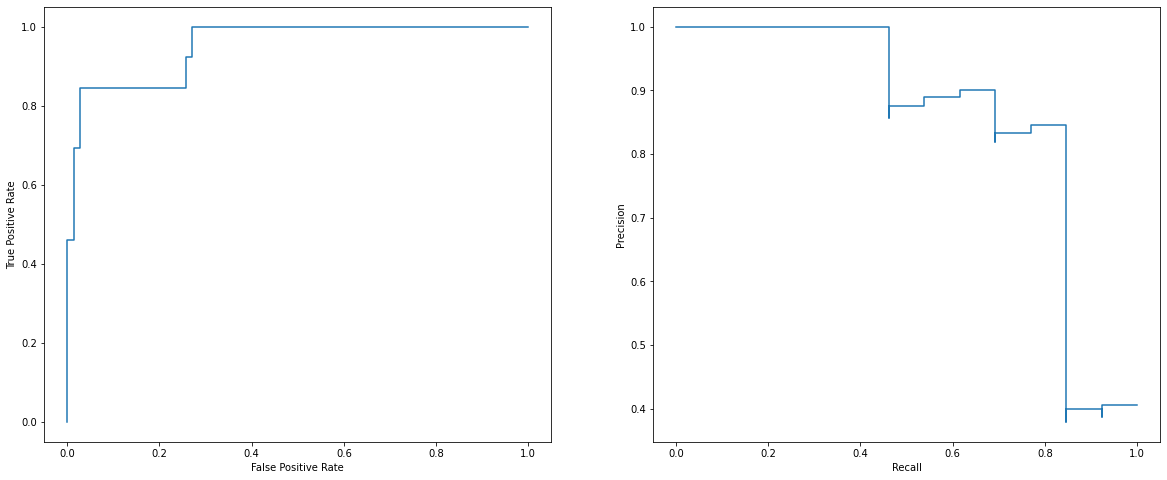

In [242]:
y_prob = clf_xgb.predict_proba(X_test_p)
probabilities = y_prob[:,1]

fpr_wgan_p, tpr_wgan_p, _ = roc_curve(y_test_p, probabilities)
roc_display_wgan_p = RocCurveDisplay(fpr=fpr_wgan_p, tpr=tpr_wgan_p)
roc_auc_wgan_p = auc(fpr_wgan_p, tpr_wgan_p)

prec_wgan_p, recall_wgan_p, _ = precision_recall_curve(y_test_p, probabilities)
pr_display_wgan_p = PrecisionRecallDisplay(precision=prec_wgan_p, recall=recall_wgan_p)
pr_auc_wgan_p = auc(recall_wgan_p, prec_wgan_p)

print('ROC AUC:', roc_auc_wgan_p)
print('Precision-Recall AUC:', pr_auc_wgan_p)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_wgan_p.plot(ax=ax1)
pr_display_wgan_p.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


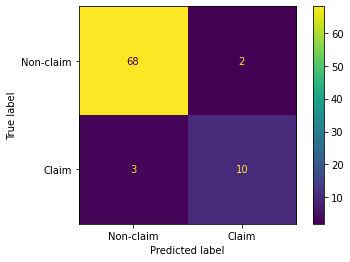

In [243]:
plot_confusion_matrix(clf_xgb, X_test_p, y_test_p, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:09:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'BrokerFeePct': 2, 'BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS': 2, 'StatsMinorClassCode_FY': 1, 'Full_GGTP': 1, 'Territory_BRITISH_COLUMBIA': 1}
gain:  {'BrokerFeePct': 134.3767243, 'BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS': 43.98465725, 'StatsMinorClassCode_FY': 138.364853, 'Full_GGTP': 38.714653, 'Territory_BRITISH_COLUMBIA': 22.1397629}
cover:  {'BrokerFeePct': 157.875, 'BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS': 131.75, 'StatsMinorClassCode_FY': 87.5, 'Full_GGTP': 68.0, 'Territory_BRITISH_COLUMBIA': 63.25}
total_gain:  {'BrokerFeePct': 268.7534486, 'BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS': 87.9693145, 'StatsMinorClassCode_FY': 138.364853, 'Full_GGTP': 

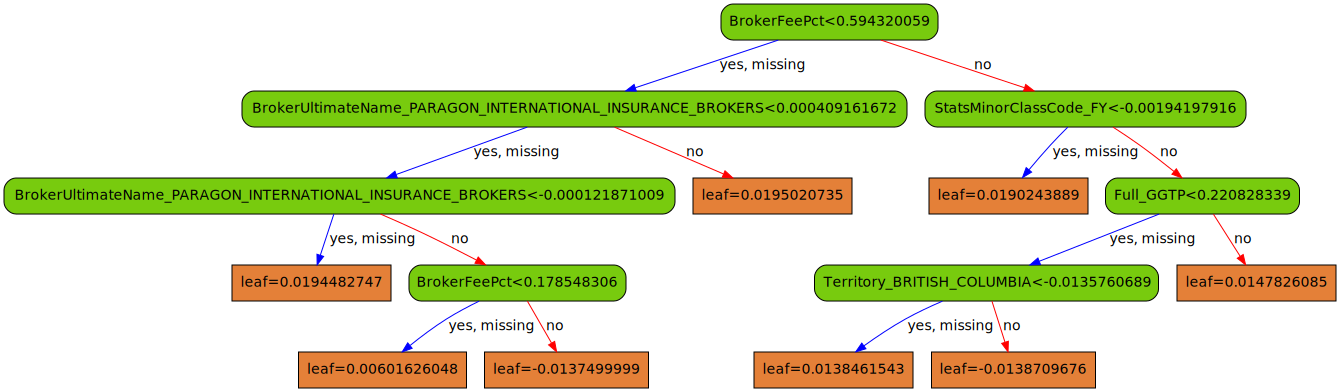

In [244]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                         gamma=0,
                          learning_rate=0.01,
                          max_depth=4,
                          reg_lambda=1,
                          scale_pos_weight=3,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_wgan_p, y_wgan_p)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


#### Excess Business

In [245]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_wgan_e, y_wgan_e, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

In [246]:
# print(optimal_params.best_params_)

In [247]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0.1,
                          learning_rate=0.1,
                          max_depth=6,
                          reg_lambda=5,
                          scale_pos_weight=2,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5)
clf_xgb.fit(X_wgan_e, y_wgan_e, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

[0]	validation_0-aucpr:0.46640
[1]	validation_0-aucpr:0.45761
[2]	validation_0-aucpr:0.51665


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[3]	validation_0-aucpr:0.52516
[4]	validation_0-aucpr:0.52338
[5]	validation_0-aucpr:0.52502
[6]	validation_0-aucpr:0.51901
[7]	validation_0-aucpr:0.51182
[8]	validation_0-aucpr:0.50944
[9]	validation_0-aucpr:0.51141
[10]	validation_0-aucpr:0.51255
[11]	validation_0-aucpr:0.51246
[12]	validation_0-aucpr:0.50791
[13]	validation_0-aucpr:0.51118


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=5, scale_pos_weight=2, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [248]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.525164
Best iteration: 3


In [249]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_e)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_e, predictions)
report = classification_report(y_test_e, predictions)
roc_auc = roc_auc_score(y_test_e, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 71.84%
ROC AUC: 0.6671717171717172
              precision    recall  f1-score   support

         0.0       0.81      0.79      0.80       270
         1.0       0.51      0.55      0.53       110

    accuracy                           0.72       380
   macro avg       0.66      0.67      0.66       380
weighted avg       0.72      0.72      0.72       380



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.7448653198653198
Precision-Recall AUC: 0.5306520454051736


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


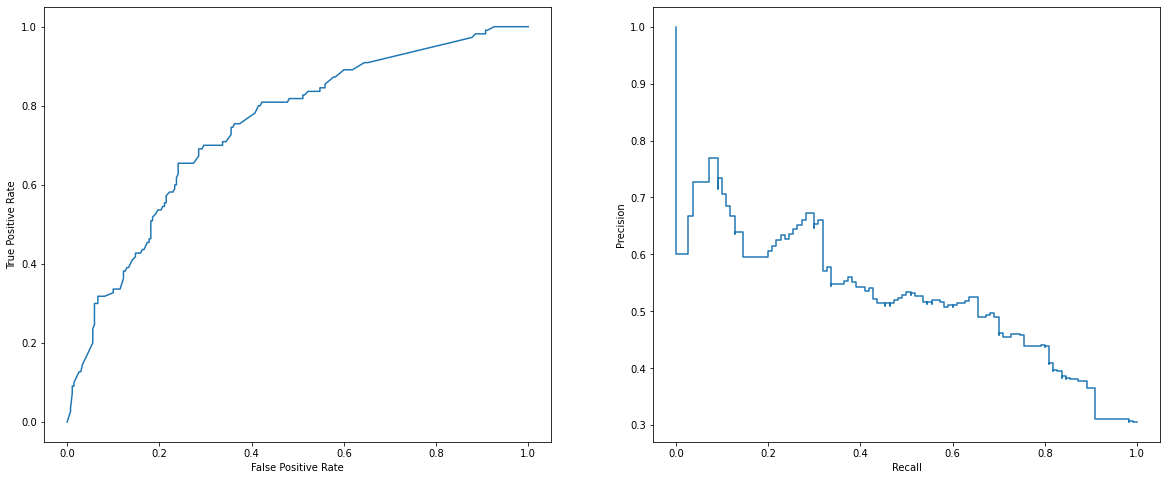

In [250]:
y_prob = clf_xgb.predict_proba(X_test_e)
probabilities = y_prob[:,1]

fpr_wgan_e, tpr_wgan_e, _ = roc_curve(y_test_e, probabilities)
roc_display_wgan_e = RocCurveDisplay(fpr=fpr_wgan_e, tpr=tpr_wgan_e)
roc_auc_wgan_e = auc(fpr_wgan_e, tpr_wgan_e)

prec_wgan_e, recall_wgan_e, _ = precision_recall_curve(y_test_e, probabilities)
pr_display_wgan_e = PrecisionRecallDisplay(precision=prec_wgan_e, recall=recall_wgan_e)
pr_auc_wgan_e = auc(recall_wgan_e, prec_wgan_e)

print('ROC AUC:', roc_auc_wgan_e)
print('Precision-Recall AUC:', pr_auc_wgan_e)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_wgan_e.plot(ax=ax1)
pr_display_wgan_e.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


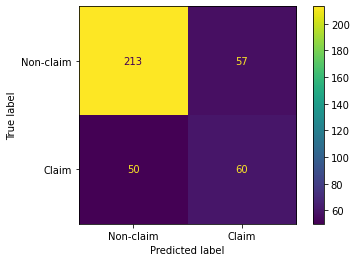

In [251]:
plot_confusion_matrix(clf_xgb, X_test_e, y_test_e, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:09:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'Territory_BAHAMAS': 3, 'Full_GGTP': 1, 'XS_100Pct_USD': 2, 'BrokerUltimateName_WILLIS': 1, 'Ded_100Pct_USD': 4, 'SubClass_PROPERTY_/_REAL_ESTATE': 1, 'BrokerUltimateName_MARSH': 1, 'Full_GGWP': 1, 'BrokerFeePct': 1, 'ModelToActualRto': 1, 'Territory_GERMANY': 1, 'Territory_NETHERLANDS': 1, 'PricingStrength': 1, 'Full_GrossGrossModelPrice': 1}
gain:  {'Territory_BAHAMAS': 303.5794171333334, 'Full_GGTP': 106.139595, 'XS_100Pct_USD': 32.290542599999995, 'BrokerUltimateName_WILLIS': 13.1381226, 'Ded_100Pct_USD': 7.315725764750001, 'SubClass_PROPERTY_/_REAL_ESTATE': 4.96161604, 'BrokerUltimateName_MARSH': 11.1639557, 'Full_GGWP': 9.0362072, 'BrokerFeePct': 32.4218941, 'ModelToActualRto': 19.2481461, 'Territory_GERMANY': 15.9380112, 

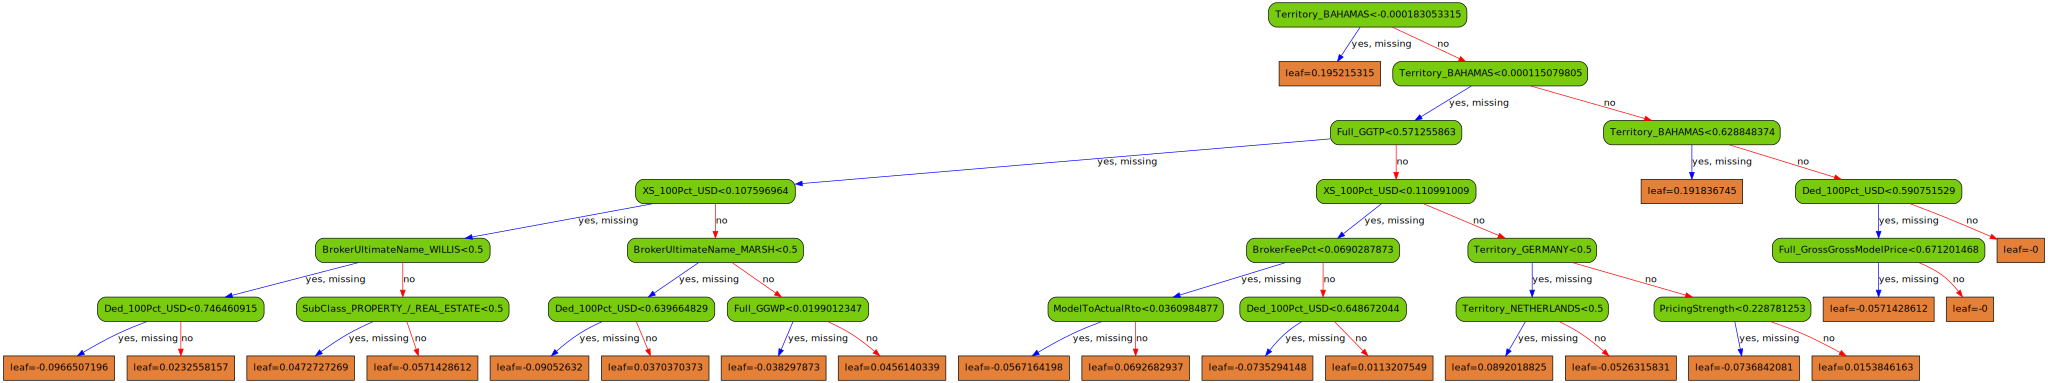

In [252]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                         gamma=0.1,
                          learning_rate=0.1,
                          max_depth=6,
                          reg_lambda=5,
                          scale_pos_weight=2,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_wgan_e, y_wgan_e)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


# WCGAN

#### Primary Business

In [253]:
X_encoded_w_classes_p = X_train_p.copy()
X_encoded_w_classes_p['Class'] = y_train_p
X_encoded_w_classes_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,"BrokerUltimateName_NAUSCH_HOGAN_AND_MURRAY,_INC",BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Upper_Middle,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle,Class
161,0.017739,0.004671,1.0,0.000500,0.4811,0.263959,0.534054,0.241071,0.724812,0.135099,...,0,0,0,0,1,0,0,0,1,0.0
228,0.245383,0.025324,1.0,0.000000,0.5326,0.263959,0.523761,0.236111,0.081870,0.022363,...,0,0,0,0,0,0,0,0,0,0.0
287,0.065238,0.018378,1.0,0.001685,0.5612,0.263959,0.543699,0.235243,0.660517,0.041204,...,0,0,0,0,0,1,0,0,0,0.0
335,0.245383,0.042298,1.0,0.000000,0.4932,0.263959,0.670768,0.258333,0.596223,0.104932,...,0,0,0,0,0,0,0,1,0,0.0
289,0.198154,0.021396,1.0,0.000000,0.6983,0.263959,0.000000,0.166667,0.081870,0.000000,...,0,1,0,0,0,0,1,0,0,0.0


In [254]:
# Finding rows with class '1'
train_p = X_encoded_w_classes_p.loc[ X_encoded_w_classes_p.Class == 1 ].copy()
claim_w_classes_p = train_p.copy()
claim_w_classes_p['Class'] = y_train_p
# claim_w_classes_p.head()
train_p = claim_w_classes_p.copy().reset_index(drop=True)
# train_p.head()

label_cols = ['Class']
data_cols = [ i for i in train_p.columns if i not in label_cols ]
train_no_label_p = train_p.copy()
train_no_label_p.drop('Class', axis=1, inplace=True)
# train_no_label_p = train_p[ data_cols ]
train_no_label_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_JOHN_HOLMAN_&_SONS_LTD,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,"BrokerUltimateName_NAUSCH_HOGAN_AND_MURRAY,_INC",BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Upper_Middle,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle
0,0.037785,0.027338,1.000000,0.003000,0.4577,0.213198,0.596739,0.270833,0.596223,0.053135,...,0,0,0,0,0,0,0,0,0,0
1,0.017739,0.005358,1.000000,0.000500,0.6010,0.263959,0.498425,0.205729,0.596223,0.080535,...,0,0,0,0,0,0,1,0,1,0
2,1.000000,0.308956,0.245690,0.000000,0.3621,0.263959,0.774043,0.333940,0.711953,0.051500,...,0,0,0,0,0,0,0,0,0,0
3,0.245383,0.020760,1.000000,0.000309,0.7440,0.263959,0.587271,0.177083,0.153696,0.086984,...,0,0,0,0,0,0,0,0,1,0
4,0.398616,0.411987,0.461207,0.250000,0.6600,0.263959,0.816713,0.184028,0.118454,0.119398,...,0,0,1,0,0,0,0,1,1,0


In [255]:
# rand_dim = len(train_no_label_p.columns) # 32 # needs to be ~data_dim
# base_n_count = 128 # 128

# nb_steps = 10000 + 1 # 50000 # Add one for logging of the last interval
# batch_size = 32 # 64

# k_d = 1  # number of critic network updates per adversarial training step
# k_g = 1  # number of generator network updates per adversarial training step
# critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
# log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
# learning_rate = 1e-4 # 5e-5
# # data_dir = 'cache/'
# # generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None
# # show = True 

In [256]:
# data_cols = train_no_label_p.columns
# data_cols_w_class = train_p.columns
# data_dim = len(data_cols)
# print('data_dim: ', data_dim)
# print('data_cols: ', data_cols)
    
# label_dim = len(label_cols)
# with_class = True
# print('label_dim: ', label_dim)
# print('label_cols: ', label_cols)
    
# K.set_learning_phase(1) # 1 = train

# cache_prefix = 'WCGAN'

# generator_input_tensor = layers.Input(shape=(rand_dim, ))
# labels_tensor = layers.Input(shape=(label_dim,)) # updated for class
# generated_image_tensor = generator_network_w_label(generator_input_tensor, labels_tensor, data_dim, label_dim, base_n_count) # updated for class

# generated_or_real_image_tensor = layers.Input(shape=(data_dim + label_dim,)) # updated for class

# discriminator_output = critic_network(generated_or_real_image_tensor, data_dim + label_dim, base_n_count) # updated for class

# generator_model = models.Model(inputs=[generator_input_tensor, labels_tensor], outputs=[generated_image_tensor], name='generator') # updated for class
# discriminator_model = models.Model(inputs=[generated_or_real_image_tensor],
#                                    outputs=[discriminator_output],
#                                    name='discriminator')

# combined_output = discriminator_model(generator_model([generator_input_tensor, labels_tensor])) # updated for class
# combined_model = models.Model(inputs=[generator_input_tensor, labels_tensor], outputs=[combined_output], name='combined') # updated for class

In [257]:
# _z = tf.placeholder(tf.float32, shape=(batch_size, rand_dim))
    
# _labels = None    

# _x = tf.placeholder(tf.float32, shape=(batch_size, data_dim + label_dim)) 
# _labels = tf.placeholder(tf.float32, shape=(batch_size, label_dim)) # updated for class
# _g_z = generator_model(inputs=[_z, _labels]) # updated for class

# epsilon = tf.placeholder(tf.float32, shape=(batch_size, 1))
    
# x_hat = epsilon * _x + (1.0 - epsilon) * _g_z
# gradients = tf.gradients(discriminator_model(x_hat), [x_hat])
# _gradient_penalty = 10.0 * tf.square(tf.norm(gradients[0], ord=2) - 1.0)

# # calculate discriminator's loss
# _disc_loss_generated = em_loss(tf.ones(batch_size), discriminator_model(_g_z))
# _disc_loss_real = em_loss(tf.ones(batch_size), discriminator_model(_x))
# _disc_loss = _disc_loss_generated - _disc_loss_real + _gradient_penalty

# # update f by taking an SGD step on mini-batch loss LD(f)
# disc_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.5, beta2=0.9).minimize(_disc_loss, var_list=discriminator_model.trainable_weights)

# sess = K.get_session()

# # compile models

# adam = optimizers.Adam(lr=learning_rate, beta_1=0.5, beta_2=0.9)

# discriminator_model.trainable = False
# combined_model.compile(optimizer=adam, loss=[em_loss])

# combined_loss, disc_loss_generated, disc_loss_real, xgb_losses = [], [], [], []

# # print(generator_model.summary())
# # print(discriminator_model.summary())
# # print(combined_model.summary())

In [258]:
# print('pre-training the critic...')
# K.set_learning_phase(1) # 1 = train
# for i in range(critic_pre_train_steps):
#     if i%20==0:
#         print('Step: {} of {} critic pre-training.'.format(i, critic_pre_train_steps))
#         loss = train_discriminator_step_p(step=0,seed=i)

# print('Last batch of critic pre-training disc_loss: {}.'.format(loss))

In [259]:
# for i in range(0, nb_steps):
#     K.set_learning_phase(1) # 1 = train
    
#     # train the discriminator
#     for j in range(k_d):
#         d_l_g, d_l_r = train_discriminator_step_p(step=i+1,seed=i+j)
#     disc_loss_generated.append(d_l_g)
#     disc_loss_real.append(d_l_r)
    
#     # train the generator
#     for j in range(k_g):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         if with_class:
#             labels = get_data_batch(train_p, batch_size, seed=i+j)[:,-label_dim:] # updated for class
#             loss = combined_model.train_on_batch([z, labels], [-np.ones(batch_size)]) # updated for class
#         else:
#             loss = combined_model.train_on_batch(z, [-np.ones(batch_size)])
#     combined_loss.append(loss)
    
#     # Determine xgb loss each step, after training generator and discriminator
#     if not i % 10: # 2x faster than testing each step...
#         K.set_learning_phase(0) # 0 = test
#         test_size = np.sum(train_p['Class']==1) - 1 # test using all of the actual claim data - 1
#         x = get_data_batch(train_p, test_size, seed=i)
#         z = np.random.normal(size=(test_size, rand_dim))
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
#         else:
#             g_z = generator_model.predict(z)
#         xgb_loss = CheckAccuracyConditional( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim )
#         xgb_losses = np.append(xgb_losses, xgb_loss)
        
#     if not i % log_interval:
#         print('Step: {} of {}.'.format(i, nb_steps))
#         # K.set_learning_phase(0) # 0 = test
                        
#         # loss summaries   
#         print( 'Losses: G, D Gen, D Real, Xgb: {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(combined_loss[-1], disc_loss_generated[-1], disc_loss_real[-1], xgb_losses[-1]) )
#         print( 'D Real - D Gen: {:.4f}'.format(disc_loss_real[-1]-disc_loss_generated[-1]) )

In [260]:
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1, 3, 1)
# ax2 = fig.add_subplot(1, 3, 2)
# ax3 = fig.add_subplot(1, 3, 3)

# ax1.plot(combined_loss)
# ax1.set_title('Generator Loss')
# ax1.set_xlabel('Step')
# ax1.set_ylabel('Loss')

# ax2.plot(disc_loss_generated)
# ax2.set_title('Discriminator Loss of Generated Data')
# ax2.set_xlabel('Step')
# ax2.set_ylabel('Loss')

# ax3.plot(disc_loss_real)
# ax3.set_title('Discriminator Loss of Real Data')
# ax3.set_xlabel('Step')
# ax3.set_ylabel('Loss')

# plt.show()

In [261]:
# # Predicting the generated data
# samples = len(X_train_res_p) - len(X_train_p)
# new_z = np.random.normal(size=(samples,rand_dim))
# labels_z = np.ones((samples,1))
# new_g_z = generator_model.predict([new_z, labels_z])

In [262]:
# wcgan_samples_p = pd.DataFrame(new_g_z, columns=data_cols_w_class)
# # Saving the dataset
# wcgan_samples_p.to_csv('dandoww_wcgan_primary.csv',index=False)

In [263]:
# Loading the dataset
wcgan_samples_p = pd.read_csv('../input/project/dandoww_wcgan_primary.csv')
wcgan_samples_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,"BrokerUltimateName_NAUSCH_HOGAN_AND_MURRAY,_INC",BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Upper_Middle,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle,Class
0,0.129909,0.074263,0.850024,0.039247,0.608456,0.251328,0.608618,0.216296,0.319072,0.118613,...,0.730199,0.038909,0.009287,0.032023,-0.029897,0.309695,0.316749,0.749484,0.023354,1.0
1,0.338565,0.335561,0.619270,0.175235,0.628808,0.225557,0.742557,0.180162,0.205895,0.084962,...,-0.000105,0.898551,-0.061465,-0.022093,0.026990,-0.026935,1.034770,0.856045,0.011132,1.0
2,0.127796,-0.004023,0.930036,0.033798,0.563566,0.271089,0.497126,0.203557,0.377281,0.091542,...,0.041090,0.001263,0.045805,-0.010398,0.014927,0.163476,-0.031253,0.950513,0.018606,1.0
3,0.206903,0.068726,0.593451,-0.011104,0.670606,0.168648,0.715094,0.142778,0.275254,0.174907,...,0.086162,0.119801,-0.058633,0.920881,0.120311,-0.341276,1.090969,-0.126008,1.249722,1.0
4,0.273115,0.083687,0.815831,0.048015,0.658395,0.219521,0.193853,0.159030,0.125999,0.105487,...,0.015724,0.889213,-0.036136,0.021614,0.060693,-0.002200,0.950650,0.023845,0.041391,1.0


In [264]:
wcgan_samples_p.drop('Class', axis=1, inplace=True)
wcgan_samples_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_JOHN_HOLMAN_&_SONS_LTD,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,"BrokerUltimateName_NAUSCH_HOGAN_AND_MURRAY,_INC",BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Upper_Middle,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle
0,0.129909,0.074263,0.850024,0.039247,0.608456,0.251328,0.608618,0.216296,0.319072,0.118613,...,0.015664,0.730199,0.038909,0.009287,0.032023,-0.029897,0.309695,0.316749,0.749484,0.023354
1,0.338565,0.335561,0.619270,0.175235,0.628808,0.225557,0.742557,0.180162,0.205895,0.084962,...,-0.000004,-0.000105,0.898551,-0.061465,-0.022093,0.026990,-0.026935,1.034770,0.856045,0.011132
2,0.127796,-0.004023,0.930036,0.033798,0.563566,0.271089,0.497126,0.203557,0.377281,0.091542,...,0.045951,0.041090,0.001263,0.045805,-0.010398,0.014927,0.163476,-0.031253,0.950513,0.018606
3,0.206903,0.068726,0.593451,-0.011104,0.670606,0.168648,0.715094,0.142778,0.275254,0.174907,...,0.045049,0.086162,0.119801,-0.058633,0.920881,0.120311,-0.341276,1.090969,-0.126008,1.249722
4,0.273115,0.083687,0.815831,0.048015,0.658395,0.219521,0.193853,0.159030,0.125999,0.105487,...,0.007789,0.015724,0.889213,-0.036136,0.021614,0.060693,-0.002200,0.950650,0.023845,0.041391


In [265]:
X_wcgan_p = X_train_p.append(wcgan_samples_p, ignore_index = True)
X_wcgan_p.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_JOHN_HOLMAN_&_SONS_LTD,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,"BrokerUltimateName_NAUSCH_HOGAN_AND_MURRAY,_INC",BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Upper_Middle,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle
count,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,...,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000
mean,0.187187,0.107795,0.797313,0.026822,0.601060,0.264723,0.539589,0.213827,0.433841,0.105739,...,0.022306,0.075421,0.201788,0.016269,0.094324,0.054746,0.289524,0.320290,0.319015,0.183662
std,0.158158,0.154587,0.263555,0.096889,0.109819,0.073615,0.223525,0.069519,0.240892,0.108763,...,0.139537,0.231029,0.382441,0.133055,0.263770,0.213096,0.429315,0.444268,0.442064,0.366954
min,-0.113171,-0.155500,0.000000,-0.086419,0.177000,0.000000,-0.217191,0.000000,-0.113680,-0.207809,...,-0.162062,-0.152164,-0.867369,-0.224709,-0.190958,-0.185035,-0.341276,-0.193109,-0.390556,-0.353210
25%,0.061233,0.009998,0.557766,0.000000,0.544100,0.248940,0.479382,0.166667,0.180649,0.044188,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.183503,0.047242,0.987206,0.001867,0.612212,0.263959,0.595873,0.195847,0.531929,0.082874,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.259412,0.149735,1.000000,0.024222,0.681880,0.263959,0.672288,0.236111,0.596429,0.140543,...,0.003257,0.021965,0.220201,0.000000,0.024659,0.014726,0.715059,0.906046,0.875779,0.096998
max,1.000000,1.000000,1.495701,1.000000,0.846999,1.000000,1.003288,0.836142,1.322497,1.000000,...,2.348765,1.156525,1.458530,1.000000,1.208452,1.000000,1.323942,1.344738,1.315221,1.452318


In [266]:
X_train_p.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_JOHN_HOLMAN_&_SONS_LTD,BrokerUltimateName_LOCKTON,BrokerUltimateName_MARSH,"BrokerUltimateName_NAUSCH_HOGAN_AND_MURRAY,_INC",BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Upper_Middle,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle
count,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,...,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000
mean,0.144531,0.064002,0.837913,0.018893,0.589426,0.267959,0.518468,0.224191,0.502811,0.097125,...,0.006061,0.039394,0.160606,0.021212,0.054545,0.075758,0.239394,0.266667,0.309091,0.200000
std,0.161786,0.114778,0.271871,0.085482,0.127599,0.061516,0.223887,0.081042,0.231636,0.102332,...,0.077731,0.194826,0.367725,0.144310,0.227436,0.265012,0.427362,0.442888,0.462821,0.400607
min,0.000000,0.000000,0.000000,0.000000,0.177000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.017739,0.006731,0.568966,0.000309,0.509525,0.263959,0.472085,0.166667,0.339047,0.032611,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.097923,0.020469,1.000000,0.001000,0.610050,0.263959,0.571924,0.201389,0.596223,0.065340,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.198154,0.068550,1.000000,0.005616,0.698225,0.263959,0.652750,0.241071,0.660517,0.132079,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,0.846999,1.000000,1.000000,0.836142,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [267]:
ones = np.ones((len(wcgan_samples_p),))
one = pd.Series(ones)
y_wcgan_p = y_train_p.append(one, ignore_index=True)
# y_wcgan_p

#### Excess Business

In [268]:
X_encoded_w_classes_e = X_train_e.copy()
X_encoded_w_classes_e['Class'] = y_train_e
X_encoded_w_classes_e.head()

,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,...,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle,PLR_band_ex_adj_Upper_Quantile,Class
826,0.114050,0.617426,0.060234,0.030612,0.035984,0.530641,0.221555,0.210193,0.683076,0.232331,...,0,0,0,1,0,0,1,0,0,0.0
447,0.057123,0.520773,0.014839,0.240204,0.210151,0.000000,0.276326,0.277531,0.637512,0.176302,...,0,0,1,0,0,0,0,1,0,0.0
1210,0.026221,0.538964,0.019957,0.346020,0.108220,0.000000,0.252025,0.352610,0.716845,0.193359,...,0,0,1,0,0,0,0,0,1,1.0
1663,0.076522,0.595267,0.031501,0.489796,0.014581,0.000000,0.386192,0.262867,0.706239,0.145834,...,0,0,0,0,0,1,0,1,0,0.0
315,0.067954,0.575828,0.026549,0.319796,0.086575,0.000000,0.341237,0.309986,0.708364,0.158333,...,0,0,0,0,0,1,0,0,1,0.0


In [269]:
# Finding rows with class '1'
train_e = X_encoded_w_classes_e.loc[ X_encoded_w_classes_e.Class == 1 ].copy()
claim_w_classes_e = train_e.copy()
claim_w_classes_e['Class'] = y_train_e
# claim_w_classes_p.head()
train_e = claim_w_classes_e.copy().reset_index(drop=True)
# train_e.head()

label_cols = ['Class']
data_cols = [ i for i in train_e.columns if i not in label_cols ]
train_no_label_e = train_e.copy()
train_no_label_e.drop('Class', axis=1, inplace=True)
# train_no_label_e = train_e[ data_cols ]
train_no_label_e.head()

,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,...,BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle,PLR_band_ex_adj_Upper_Quantile
0,0.026221,0.538964,0.019957,0.346020,0.108220,0.000000,0.252025,0.352610,0.716845,0.193359,...,0,0,0,1,0,0,0,0,0,1
1,0.137510,0.560556,0.024887,0.183673,0.216446,0.650734,0.293439,0.262867,0.646901,0.183911,...,0,0,0,0,0,1,0,1,0,0
2,0.026221,0.561268,0.026992,0.489796,0.034627,0.000000,0.242476,0.323205,0.681138,0.200859,...,1,0,0,1,0,0,0,0,1,0
3,0.276159,0.623994,0.068404,0.120306,0.113257,0.771782,0.218926,0.309986,0.773354,0.245690,...,0,0,0,0,1,0,0,0,0,1
4,0.137510,0.614651,0.046490,0.209184,0.173156,0.000000,0.275146,0.287047,0.734016,0.177083,...,0,0,0,1,0,0,0,0,1,0


In [270]:
# rand_dim = len(train_no_label_e.columns) # 32 # needs to be ~data_dim
# base_n_count = 128 # 128

# nb_steps = 10000 + 1 # 50000 # Add one for logging of the last interval
# batch_size = 128 # 64

# k_d = 1  # number of critic network updates per adversarial training step
# k_g = 1  # number of generator network updates per adversarial training step
# critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
# log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
# learning_rate = 1e-4 # 5e-5
# # data_dir = 'cache/'
# # generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None
# # show = True 

In [271]:
# data_cols = train_no_label_e.columns
# data_cols_w_class = train_e.columns
# data_dim = len(data_cols)
# print('data_dim: ', data_dim)
# print('data_cols: ', data_cols)
    
# label_dim = len(label_cols)
# with_class = True
# print('label_dim: ', label_dim)
# print('label_cols: ', label_cols)
    
# K.set_learning_phase(1) # 1 = train

# cache_prefix = 'WCGAN'

# generator_input_tensor = layers.Input(shape=(rand_dim, ))
# labels_tensor = layers.Input(shape=(label_dim,)) # updated for class
# generated_image_tensor = generator_network_w_label(generator_input_tensor, labels_tensor, data_dim, label_dim, base_n_count) # updated for class

# generated_or_real_image_tensor = layers.Input(shape=(data_dim + label_dim,)) # updated for class

# discriminator_output = critic_network(generated_or_real_image_tensor, data_dim + label_dim, base_n_count) # updated for class

# generator_model = models.Model(inputs=[generator_input_tensor, labels_tensor], outputs=[generated_image_tensor], name='generator') # updated for class
# discriminator_model = models.Model(inputs=[generated_or_real_image_tensor],
#                                    outputs=[discriminator_output],
#                                    name='discriminator')

# combined_output = discriminator_model(generator_model([generator_input_tensor, labels_tensor])) # updated for class
# combined_model = models.Model(inputs=[generator_input_tensor, labels_tensor], outputs=[combined_output], name='combined') # updated for class

In [272]:
# _z = tf.placeholder(tf.float32, shape=(batch_size, rand_dim))
    
# _labels = None    

# _x = tf.placeholder(tf.float32, shape=(batch_size, data_dim + label_dim)) 
# _labels = tf.placeholder(tf.float32, shape=(batch_size, label_dim)) # updated for class
# _g_z = generator_model(inputs=[_z, _labels]) # updated for class

# epsilon = tf.placeholder(tf.float32, shape=(batch_size, 1))
    
# x_hat = epsilon * _x + (1.0 - epsilon) * _g_z
# gradients = tf.gradients(discriminator_model(x_hat), [x_hat])
# _gradient_penalty = 10.0 * tf.square(tf.norm(gradients[0], ord=2) - 1.0)

# # calculate discriminator's loss
# _disc_loss_generated = em_loss(tf.ones(batch_size), discriminator_model(_g_z))
# _disc_loss_real = em_loss(tf.ones(batch_size), discriminator_model(_x))
# _disc_loss = _disc_loss_generated - _disc_loss_real + _gradient_penalty

# # update f by taking an SGD step on mini-batch loss LD(f)
# disc_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.5, beta2=0.9).minimize(_disc_loss, var_list=discriminator_model.trainable_weights)

# sess = K.get_session()

# # compile models

# adam = optimizers.Adam(lr=learning_rate, beta_1=0.5, beta_2=0.9)

# discriminator_model.trainable = False
# combined_model.compile(optimizer=adam, loss=[em_loss])

# combined_loss, disc_loss_generated, disc_loss_real, xgb_losses = [], [], [], []

# # print(generator_model.summary())
# # print(discriminator_model.summary())
# # print(combined_model.summary())

In [273]:
# print('pre-training the critic...')
# K.set_learning_phase(1) # 1 = train
# for i in range(critic_pre_train_steps):
#     if i%20==0:
#         print('Step: {} of {} critic pre-training.'.format(i, critic_pre_train_steps))
#         loss = train_discriminator_step_e(step=0,seed=i)

# print('Last batch of critic pre-training disc_loss: {}.'.format(loss))

In [274]:
# for i in range(0, nb_steps):
#     K.set_learning_phase(1) # 1 = train
    
#     # train the discriminator
#     for j in range(k_d):
#         d_l_g, d_l_r = train_discriminator_step_e(step=i+1,seed=i+j)
#     disc_loss_generated.append(d_l_g)
#     disc_loss_real.append(d_l_r)
    
#     # train the generator
#     for j in range(k_g):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         if with_class:
#             labels = get_data_batch(train_e, batch_size, seed=i+j)[:,-label_dim:] # updated for class
#             loss = combined_model.train_on_batch([z, labels], [-np.ones(batch_size)]) # updated for class
#         else:
#             loss = combined_model.train_on_batch(z, [-np.ones(batch_size)])
#     combined_loss.append(loss)
    
#     # Determine xgb loss each step, after training generator and discriminator
#     if not i % 10: # 2x faster than testing each step...
#         K.set_learning_phase(0) # 0 = test
#         test_size = np.sum(train_e['Class']==1) # test using all of the actual claim data
#         x = get_data_batch(train_e, test_size, seed=i)
#         z = np.random.normal(size=(test_size, rand_dim))
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
#         else:
#             g_z = generator_model.predict(z)
#         xgb_loss = CheckAccuracyConditional( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim )
#         xgb_losses = np.append(xgb_losses, xgb_loss)
        
#     if not i % log_interval:
#         print('Step: {} of {}.'.format(i, nb_steps))
#         # K.set_learning_phase(0) # 0 = test
                        
#         # loss summaries   
#         print( 'Losses: G, D Gen, D Real, Xgb: {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(combined_loss[-1], disc_loss_generated[-1], disc_loss_real[-1], xgb_losses[-1]) )
#         print( 'D Real - D Gen: {:.4f}'.format(disc_loss_real[-1]-disc_loss_generated[-1]) )

In [275]:
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1, 3, 1)
# ax2 = fig.add_subplot(1, 3, 2)
# ax3 = fig.add_subplot(1, 3, 3)

# ax1.plot(combined_loss)
# ax1.set_title('Generator Loss')
# ax1.set_xlabel('Step')
# ax1.set_ylabel('Loss')

# ax2.plot(disc_loss_generated)
# ax2.set_title('Discriminator Loss of Generated Data')
# ax2.set_xlabel('Step')
# ax2.set_ylabel('Loss')

# ax3.plot(disc_loss_real)
# ax3.set_title('Discriminator Loss of Real Data')
# ax3.set_xlabel('Step')
# ax3.set_ylabel('Loss')

# plt.show()

In [276]:
# # Predicting the generated data
# samples = len(X_train_res_e) - len(X_train_e)
# new_z = np.random.normal(size=(samples,rand_dim))
# labels_z = np.ones((samples,1))
# new_g_z = generator_model.predict([new_z, labels_z])

In [277]:
# wcgan_samples_e = pd.DataFrame(new_g_z, columns=data_cols_w_class)
# # Saving the dataset
# wcgan_samples_e.to_csv('dandoww_wcgan_excess.csv',index=False)

In [278]:
# Loading the dataset
wcgan_samples_e = pd.read_csv('../input/project/dandoww_wcgan_excess.csv')
wcgan_samples_e.head()

,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,...,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle,PLR_band_ex_adj_Upper_Quantile,Class
0,-0.004517,0.458147,0.054880,0.730348,-0.108531,0.346798,0.285481,0.428586,0.533179,0.284320,...,-0.006238,0.146401,0.005387,0.342898,0.725841,-0.070088,1.166105,-0.082058,-0.032113,1.0
1,0.098311,0.530959,0.004884,0.390870,0.053041,-0.119366,0.246325,0.321800,0.566477,0.259924,...,0.006885,0.041672,0.961120,0.002930,-0.017323,-0.007270,0.485331,0.239505,0.028996,1.0
2,0.073867,0.610780,0.063973,0.300408,0.198708,0.025786,0.322340,0.400141,0.709197,0.147789,...,0.112223,0.122499,0.096418,-0.085133,0.921091,0.074756,0.085878,0.162537,0.517263,1.0
3,0.029133,0.535229,-0.038121,0.404041,0.221424,0.762142,0.368445,0.447671,0.523713,0.239131,...,-0.010405,0.076080,0.102173,-0.041027,0.967411,0.154894,1.021892,-0.016183,-0.073642,1.0
4,0.056978,0.519752,-0.035462,0.274362,0.172253,-0.195799,0.246523,0.339369,0.553670,0.256339,...,-0.029753,0.090591,0.866607,0.082573,0.013057,-0.029482,0.101771,0.828915,-0.026414,1.0


In [279]:
wcgan_samples_e.drop('Class', axis=1, inplace=True)
wcgan_samples_e.head()

,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,...,BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle,PLR_band_ex_adj_Upper_Quantile
0,-0.004517,0.458147,0.054880,0.730348,-0.108531,0.346798,0.285481,0.428586,0.533179,0.284320,...,0.055538,-0.006238,0.146401,0.005387,0.342898,0.725841,-0.070088,1.166105,-0.082058,-0.032113
1,0.098311,0.530959,0.004884,0.390870,0.053041,-0.119366,0.246325,0.321800,0.566477,0.259924,...,-0.012657,0.006885,0.041672,0.961120,0.002930,-0.017323,-0.007270,0.485331,0.239505,0.028996
2,0.073867,0.610780,0.063973,0.300408,0.198708,0.025786,0.322340,0.400141,0.709197,0.147789,...,-0.014578,0.112223,0.122499,0.096418,-0.085133,0.921091,0.074756,0.085878,0.162537,0.517263
3,0.029133,0.535229,-0.038121,0.404041,0.221424,0.762142,0.368445,0.447671,0.523713,0.239131,...,0.011453,-0.010405,0.076080,0.102173,-0.041027,0.967411,0.154894,1.021892,-0.016183,-0.073642
4,0.056978,0.519752,-0.035462,0.274362,0.172253,-0.195799,0.246523,0.339369,0.553670,0.256339,...,-0.042200,-0.029753,0.090591,0.866607,0.082573,0.013057,-0.029482,0.101771,0.828915,-0.026414


In [280]:
X_wcgan_e = X_train_e.append(wcgan_samples_e, ignore_index = True)
X_wcgan_e.describe()

,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,...,BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle,PLR_band_ex_adj_Upper_Quantile
count,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,...,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000
mean,0.104936,0.565521,0.056199,0.351582,0.099934,0.201122,0.290631,0.309868,0.659160,0.200843,...,0.019095,0.009720,0.106283,0.288152,0.184909,0.246646,0.278721,0.270226,0.317424,0.302290
std,0.115988,0.085617,0.081201,0.230594,0.088508,0.309272,0.070975,0.059698,0.122349,0.062958,...,0.106764,0.110066,0.282354,0.442910,0.382135,0.417555,0.436562,0.430393,0.453794,0.449356
min,-0.290598,0.000000,-0.157250,-0.188932,-0.192734,-0.553426,0.003809,0.000000,0.000000,-0.029532,...,-0.178836,-0.194162,-0.367791,-0.332884,-0.346317,-0.373821,-0.291681,-0.396868,-0.501997,-0.407365
25%,0.032776,0.515201,0.015378,0.187123,0.034627,0.000000,0.243911,0.287047,0.617227,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.067954,0.562942,0.032837,0.307137,0.086575,0.000000,0.291830,0.309986,0.672344,0.188988,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.137510,0.614651,0.070871,0.489796,0.145862,0.472723,0.332868,0.309986,0.724954,0.230243,...,0.000000,0.000000,0.019407,0.897042,0.059751,0.461260,0.819850,0.745184,0.993529,0.939424
max,1.000000,1.000000,1.000000,1.148070,0.875197,1.315721,1.000000,0.957070,1.004167,1.000000,...,1.000000,1.000000,1.501420,1.519103,1.185371,1.256325,1.491205,1.336039,1.366297,1.182504


In [281]:
X_train_e.describe()

,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,...,BrokerUltimateName_PARAGON_INTERNATIONAL_INSURANCE_BROKERS,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile,PLR_band_ex_adj_Lower_Middle,PLR_band_ex_adj_Upper_Middle,PLR_band_ex_adj_Upper_Quantile
count,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,...,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000
mean,0.099253,0.569165,0.049617,0.376919,0.095426,0.202503,0.285787,0.304439,0.661818,0.198655,...,0.013167,0.015800,0.083608,0.275181,0.201448,0.248190,0.275181,0.260039,0.312706,0.313364
std,0.110936,0.085943,0.074987,0.246454,0.083793,0.317881,0.067344,0.051901,0.129401,0.059094,...,0.114025,0.124742,0.276890,0.446753,0.401214,0.432105,0.446753,0.438800,0.463748,0.464014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003809,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.032776,0.519252,0.015486,0.195255,0.031779,0.000000,0.241779,0.287047,0.630661,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.067153,0.566168,0.027834,0.319796,0.076235,0.000000,0.291830,0.309986,0.680224,0.184028,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.127343,0.614725,0.053001,0.489796,0.129865,0.590751,0.325144,0.309986,0.726624,0.218750,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,0.875197,0.967907,1.000000,0.957070,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [282]:
ones = np.ones((len(wcgan_samples_e),))
one = pd.Series(ones)
y_wcgan_e = y_train_e.append(one, ignore_index=True)
# y_wcgan_e

### XGBoost (WCGAN)

#### Primary Business

In [283]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_wcgan_p, y_wcgan_p, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

In [284]:
# print(optimal_params.best_params_)

In [285]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=1,
                          learning_rate=0.05,
                          max_depth=6,
                          reg_lambda=10,
                          scale_pos_weight=3,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5)
clf_xgb.fit(X_wcgan_p, y_wcgan_p, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

[0]	validation_0-aucpr:0.36267
[1]	validation_0-aucpr:0.64381
[2]	validation_0-aucpr:0.71405
[3]	validation_0-aucpr:0.69992
[4]	validation_0-aucpr:0.71145
[5]	validation_0-aucpr:0.72159
[6]	validation_0-aucpr:0.71079
[7]	validation_0-aucpr:0.73479
[8]	validation_0-aucpr:0.73114


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-aucpr:0.73826
[10]	validation_0-aucpr:0.75997
[11]	validation_0-aucpr:0.75797
[12]	validation_0-aucpr:0.75595
[13]	validation_0-aucpr:0.76564
[14]	validation_0-aucpr:0.79161
[15]	validation_0-aucpr:0.78948
[16]	validation_0-aucpr:0.78273
[17]	validation_0-aucpr:0.78876
[18]	validation_0-aucpr:0.73831
[19]	validation_0-aucpr:0.73831
[20]	validation_0-aucpr:0.73483
[21]	validation_0-aucpr:0.74181
[22]	validation_0-aucpr:0.74068
[23]	validation_0-aucpr:0.73672
[24]	validation_0-aucpr:0.73336


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=3, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [286]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.791612
Best iteration: 14


In [287]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_p)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_p, predictions)
report = classification_report(y_test_p, predictions)
roc_auc = roc_auc_score(y_test_p, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 84.34%
ROC AUC: 0.8445054945054945
              precision    recall  f1-score   support

         0.0       0.97      0.84      0.90        70
         1.0       0.50      0.85      0.63        13

    accuracy                           0.84        83
   macro avg       0.73      0.84      0.76        83
weighted avg       0.89      0.84      0.86        83



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.9384615384615385
Precision-Recall AUC: 0.7909922863253069


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


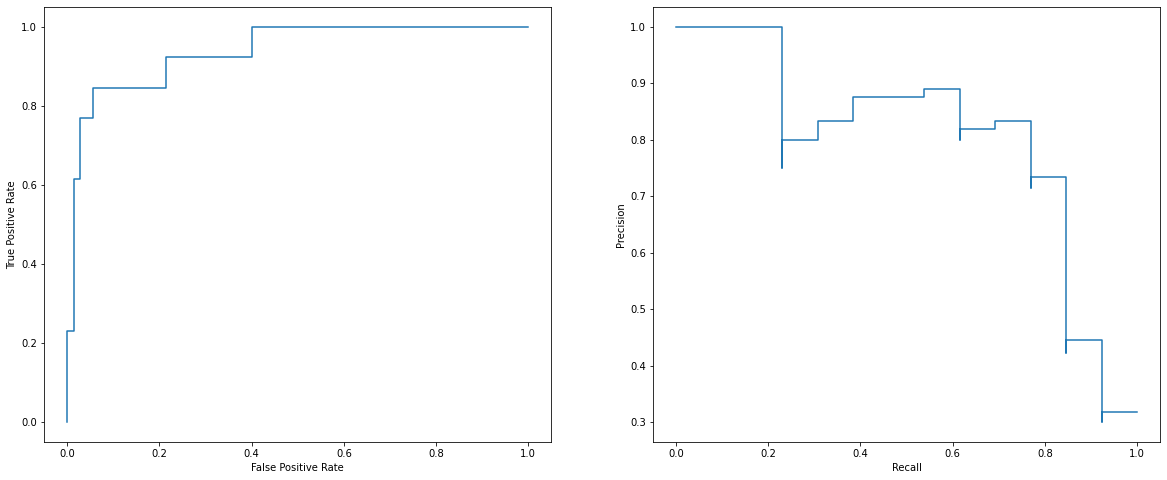

In [288]:
y_prob = clf_xgb.predict_proba(X_test_p)
probabilities = y_prob[:,1]

fpr_wcgan_p, tpr_wcgan_p, _ = roc_curve(y_test_p, probabilities)
roc_display_wcgan_p = RocCurveDisplay(fpr=fpr_wcgan_p, tpr=tpr_wcgan_p)
roc_auc_wcgan_p = auc(fpr_wcgan_p, tpr_wcgan_p)

prec_wcgan_p, recall_wcgan_p, _ = precision_recall_curve(y_test_p, probabilities)
pr_display_wcgan_p = PrecisionRecallDisplay(precision=prec_wcgan_p, recall=recall_wcgan_p)
pr_auc_wcgan_p = auc(recall_wcgan_p, prec_wcgan_p)

print('ROC AUC:', roc_auc_wcgan_p)
print('Precision-Recall AUC:', pr_auc_wcgan_p)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_wcgan_p.plot(ax=ax1)
pr_display_wcgan_p.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


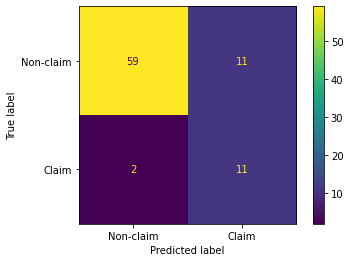

In [289]:
plot_confusion_matrix(clf_xgb, X_test_p, y_test_p, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:09:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'BrokerFeePct': 1, 'StatsMinorClassCode_FY': 1, 'LeaderStatus_LEAD': 1, 'Limit_100Pct_USD': 1, 'SubClass_PROPERTY_/_REAL_ESTATE': 1, 'BrokerUltimateName_R_K_HARRISON': 1, 'Ded_100Pct_USD': 1, 'Territory_ITALY': 1, 'Full_GGTP': 1, 'Territory_NEVADA': 1, 'SubClass_COMPUTER_SERVICES_/_SUPPORT': 1, 'BrokerUltimateName_NAUSCH_HOGAN_AND_MURRAY,_INC': 1, 'PLR': 2, 'SubClass_TRANSPORT': 1}
gain:  {'BrokerFeePct': 245.194031, 'StatsMinorClassCode_FY': 23.9038391, 'LeaderStatus_LEAD': 18.5012207, 'Limit_100Pct_USD': 5.94252539, 'SubClass_PROPERTY_/_REAL_ESTATE': 12.4942017, 'BrokerUltimateName_R_K_HARRISON': 1.92608643, 'Ded_100Pct_USD': 2.47063732, 'Territory_ITALY': 87.885025, 'Full_GGTP': 39.072113, 'Territory_NEVADA': 12.7256165, 'Sub

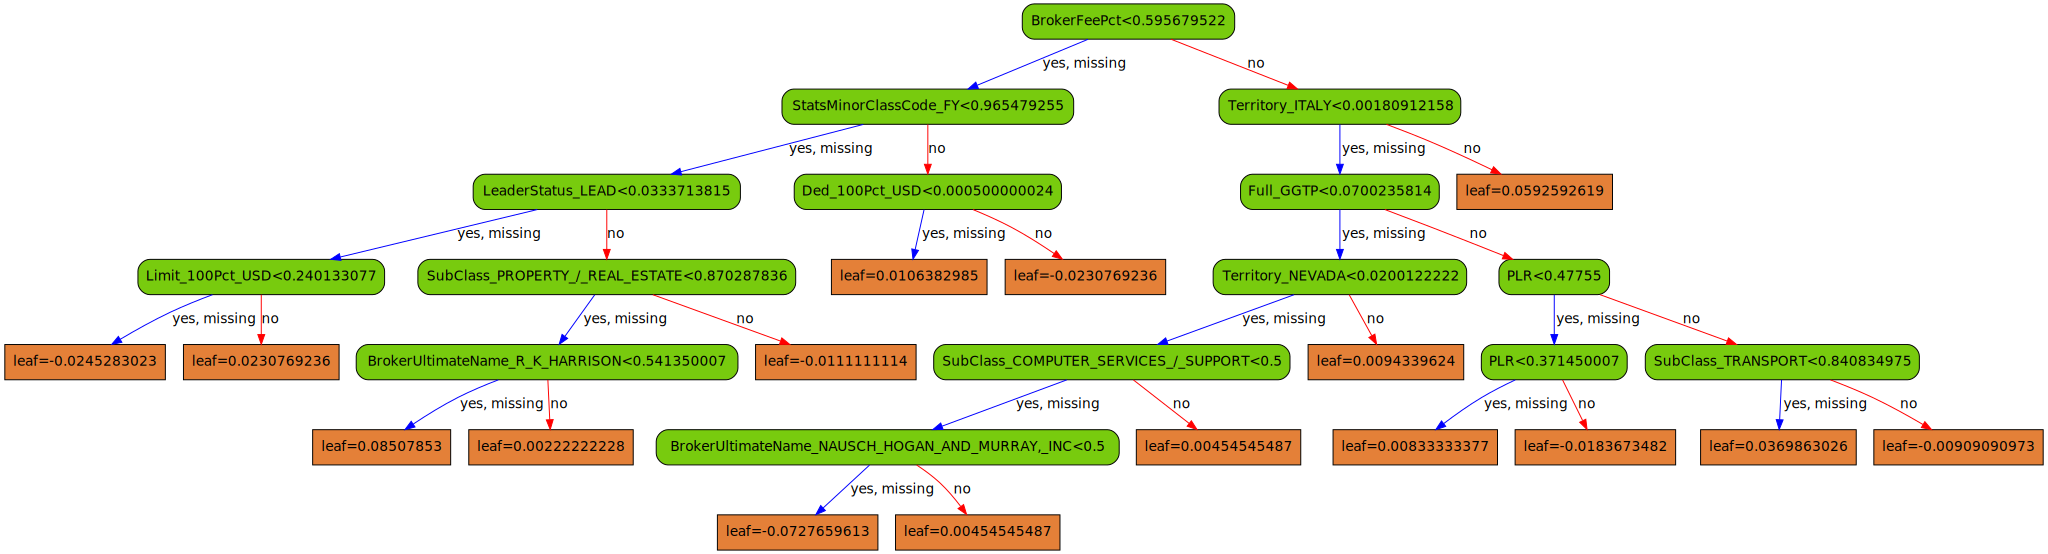

In [290]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                         gamma=1,
                          learning_rate=0.05,
                          max_depth=6,
                          reg_lambda=10,
                          scale_pos_weight=3,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_wcgan_p, y_wcgan_p)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


#### Excess Business

In [291]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_wcgan_e, y_wcgan_e, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

In [292]:
# print(optimal_params.best_params_)

In [293]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=1,
                          learning_rate=0.1,
                          max_depth=6,
                          reg_lambda=10,
                          scale_pos_weight=1,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5)
clf_xgb.fit(X_wcgan_e, y_wcgan_e, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

[0]	validation_0-aucpr:0.49106
[1]	validation_0-aucpr:0.49308


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-aucpr:0.54773
[3]	validation_0-aucpr:0.57298
[4]	validation_0-aucpr:0.56407
[5]	validation_0-aucpr:0.55132
[6]	validation_0-aucpr:0.54995
[7]	validation_0-aucpr:0.54774
[8]	validation_0-aucpr:0.54873
[9]	validation_0-aucpr:0.54475
[10]	validation_0-aucpr:0.55508
[11]	validation_0-aucpr:0.55910
[12]	validation_0-aucpr:0.56213
[13]	validation_0-aucpr:0.56509


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=1, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [294]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.572985
Best iteration: 3


In [295]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_e)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_e, predictions)
report = classification_report(y_test_e, predictions)
roc_auc = roc_auc_score(y_test_e, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 75.53%
ROC AUC: 0.6069023569023568
              precision    recall  f1-score   support

         0.0       0.76      0.96      0.85       270
         1.0       0.72      0.25      0.38       110

    accuracy                           0.76       380
   macro avg       0.74      0.61      0.61       380
weighted avg       0.75      0.76      0.71       380



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.7306060606060605
Precision-Recall AUC: 0.5734964991628532


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


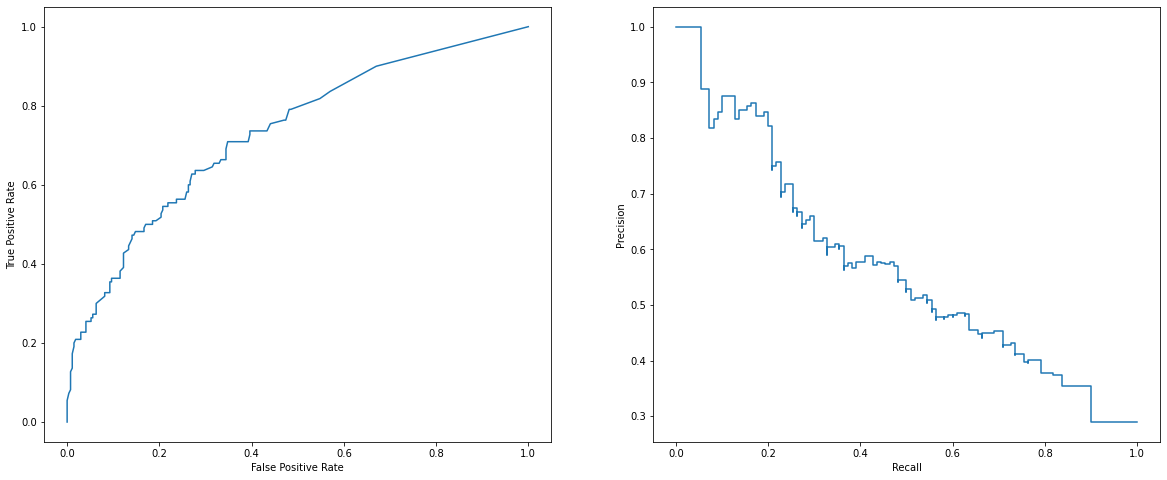

In [296]:
y_prob = clf_xgb.predict_proba(X_test_e)
probabilities = y_prob[:,1]

fpr_wcgan_e, tpr_wcgan_e, _ = roc_curve(y_test_e, probabilities)
roc_display_wcgan_e = RocCurveDisplay(fpr=fpr_wcgan_e, tpr=tpr_wcgan_e)
roc_auc_wcgan_e = auc(fpr_wcgan_e, tpr_wcgan_e)

prec_wcgan_e, recall_wcgan_e, _ = precision_recall_curve(y_test_e, probabilities)
pr_display_wcgan_e = PrecisionRecallDisplay(precision=prec_wcgan_e, recall=recall_wcgan_e)
pr_auc_wcgan_e = auc(recall_wcgan_e, prec_wcgan_e)

print('ROC AUC:', roc_auc_wcgan_e)
print('Precision-Recall AUC:', pr_auc_wcgan_e)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_wcgan_e.plot(ax=ax1)
pr_display_wcgan_e.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


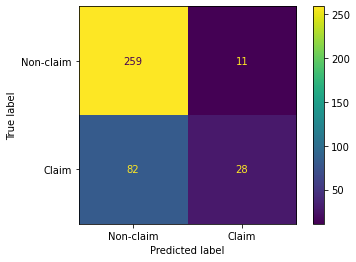

In [297]:
plot_confusion_matrix(clf_xgb, X_test_e, y_test_e, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

[03:09:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'SubClass_CHEMICALS': 3, 'Full_GGTP': 1, 'RARC': 1, 'Ded_100Pct_USD': 1, 'Territory_CALIFORNIA': 1, 'XS_100Pct_USD': 1, 'BrokerFeePct': 1, 'ModelToActualRto': 2, 'Territory_BRAZIL': 1, 'Full_GrossGrossModelPrice': 1, 'BrokerUltimateName_WILLIS': 1}
gain:  {'SubClass_CHEMICALS': 277.3993126, 'Full_GGTP': 51.5683899, 'RARC': 8.78735352, 'Ded_100Pct_USD': 7.00888062, 'Territory_CALIFORNIA': 5.2019043, 'XS_100Pct_USD': 30.949789, 'BrokerFeePct': 13.2417717, 'ModelToActualRto': 6.918180465000001, 'Territory_BRAZIL': 6.67527008, 'Full_GrossGrossModelPrice': 5.60305691, 'BrokerUltimateName_WILLIS': 5.58043861}
cover:  {'SubClass_CHEMICALS': 340.8333333333333, 'Full_GGTP': 374.5, 'RARC': 194.75, 'Ded_100Pct_USD': 193.0, 'Territory_CALIF

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


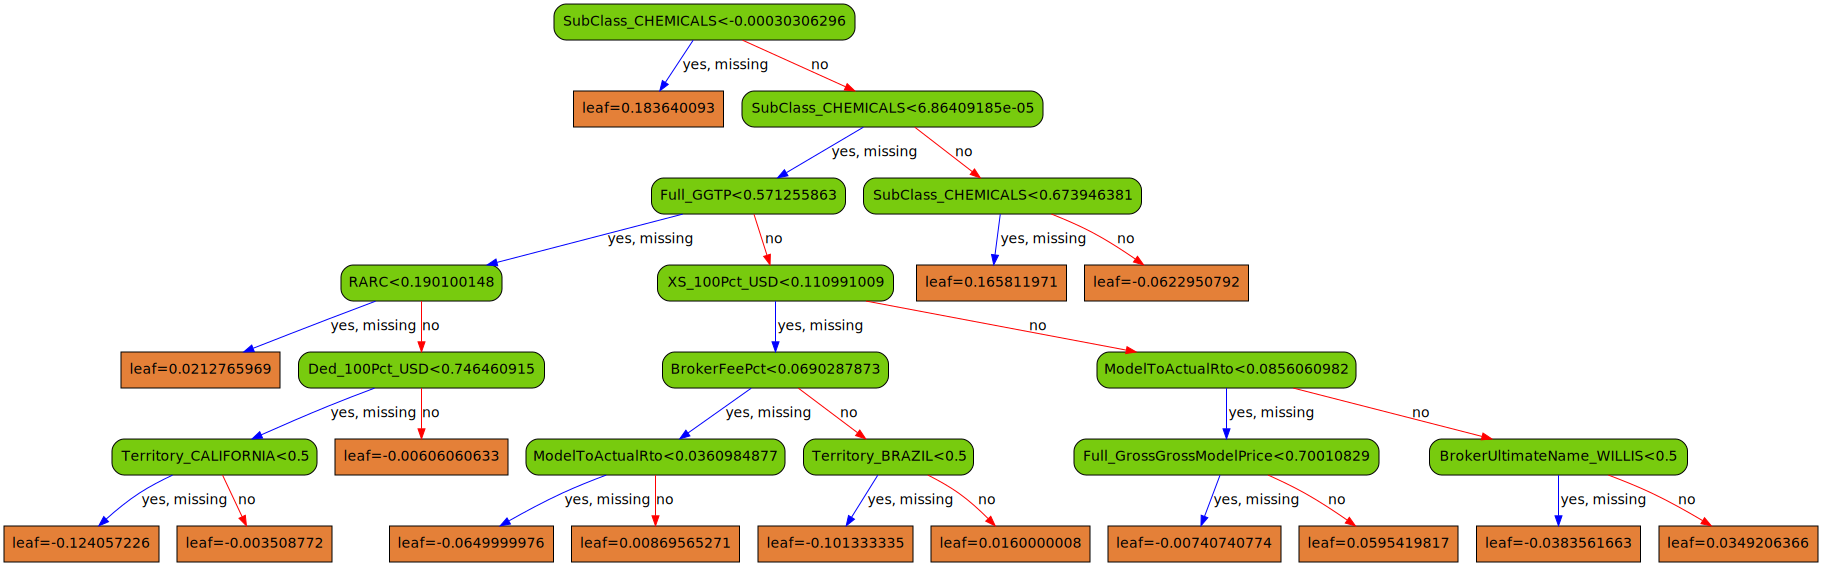

In [298]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                         gamma=1,
                          learning_rate=0.1,
                          max_depth=6,
                          reg_lambda=10,
                          scale_pos_weight=1,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_wcgan_e, y_wcgan_e)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


## Comparison Plots

In [299]:
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
fpr, tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

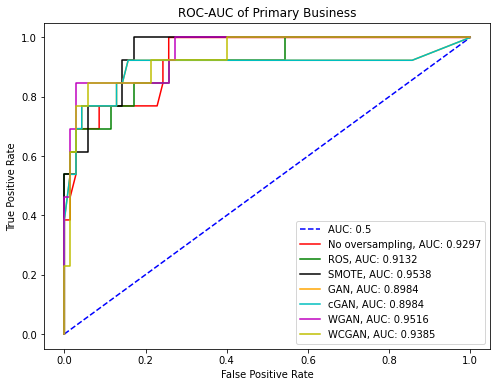

In [300]:
plt.figure(figsize=(8,6))

plt.plot(fpr, tpr, color='b', linestyle='--', label='AUC: 0.5')
plt.plot(fpr_p, tpr_p, color='r', label='No oversampling, AUC: %.4f' % roc_auc_p)
plt.plot(fpr_ros_p, tpr_ros_p, color='g', label='ROS, AUC: %.4f' % roc_auc_ros_p)
plt.plot(fpr_sm_p, tpr_sm_p, color='k', label='SMOTE, AUC: %.4f' % roc_auc_sm_p)
plt.plot(fpr_gan_p, tpr_gan_p, color='orange', label='GAN, AUC: %.4f' % roc_auc_gan_p)
plt.plot(fpr_cgan_p, tpr_cgan_p, color='c', label='cGAN, AUC: %.4f' % roc_auc_cgan_p)
plt.plot(fpr_wgan_p, tpr_wgan_p, color='m', label='WGAN, AUC: %.4f' % roc_auc_wgan_p)
plt.plot(fpr_wcgan_p, tpr_wcgan_p, color='y', label='WCGAN, AUC: %.4f' % roc_auc_wcgan_p)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC of Primary Business')
plt.legend(loc='lower right')

plt.show()

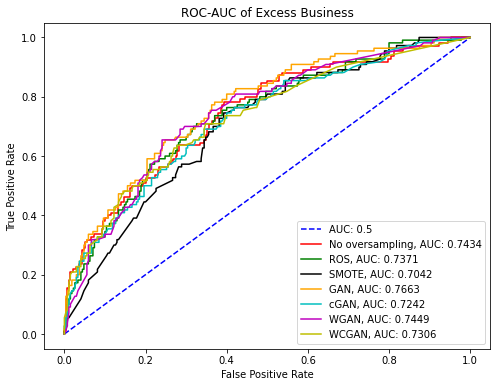

In [301]:
plt.figure(figsize=(8,6))

plt.plot(fpr, tpr, color='b', linestyle='--', label='AUC: 0.5')
plt.plot(fpr_e, tpr_e, color='r', label='No oversampling, AUC: %.4f' % roc_auc_e)
plt.plot(fpr_ros_e, tpr_ros_e, color='g', label='ROS, AUC: %.4f' % roc_auc_ros_e)
plt.plot(fpr_sm_e, tpr_sm_e, color='k', label='SMOTE, AUC: %.4f' % roc_auc_sm_e)
plt.plot(fpr_gan_e, tpr_gan_e, color='orange', label='GAN, AUC: %.4f' % roc_auc_gan_e)
plt.plot(fpr_cgan_e, tpr_cgan_e, color='c', label='cGAN, AUC: %.4f' % roc_auc_cgan_e)
plt.plot(fpr_wgan_e, tpr_wgan_e, color='m', label='WGAN, AUC: %.4f' % roc_auc_wgan_e)
plt.plot(fpr_wcgan_e, tpr_wcgan_e, color='y', label='WCGAN, AUC: %.4f' % roc_auc_wcgan_e)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC of Excess Business')
plt.legend(loc='lower right')

plt.show()

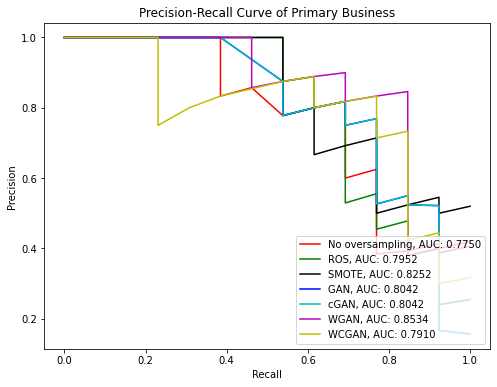

In [302]:
plt.figure(figsize=(8,6))

plt.plot(recall_p, prec_p, color='r', label='No oversampling, AUC: %.4f' % pr_auc_p)
plt.plot(recall_ros_p, prec_ros_p, color='g', label='ROS, AUC: %.4f' % pr_auc_ros_p)
plt.plot(recall_sm_p, prec_sm_p, color='k', label='SMOTE, AUC: %.4f' % pr_auc_sm_p)
plt.plot(recall_gan_p, prec_gan_p, color='b', label='GAN, AUC: %.4f' % pr_auc_gan_p)
plt.plot(recall_cgan_p, prec_cgan_p, color='c', label='cGAN, AUC: %.4f' % pr_auc_cgan_p)
plt.plot(recall_wgan_p, prec_wgan_p, color='m', label='WGAN, AUC: %.4f' % pr_auc_wgan_p)
plt.plot(recall_wcgan_p, prec_wcgan_p, color='y', label='WCGAN, AUC: %.4f' % pr_auc_wcgan_p)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve of Primary Business')
plt.legend(loc='lower right')

plt.show()

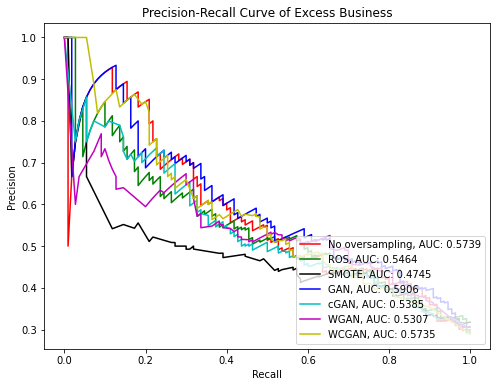

In [303]:
plt.figure(figsize=(8,6))

plt.plot(recall_e, prec_e, color='r', label='No oversampling, AUC: %.4f' % pr_auc_e)
plt.plot(recall_ros_e, prec_ros_e, color='g', label='ROS, AUC: %.4f' % pr_auc_ros_e)
plt.plot(recall_sm_e, prec_sm_e, color='k', label='SMOTE, AUC: %.4f' % pr_auc_sm_e)
plt.plot(recall_gan_e, prec_gan_e, color='b', label='GAN, AUC: %.4f' % pr_auc_gan_e)
plt.plot(recall_cgan_e, prec_cgan_e, color='c', label='cGAN, AUC: %.4f' % pr_auc_cgan_e)
plt.plot(recall_wgan_e, prec_wgan_e, color='m', label='WGAN, AUC: %.4f' % pr_auc_wgan_e)
plt.plot(recall_wcgan_e, prec_wcgan_e, color='y', label='WCGAN, AUC: %.4f' % pr_auc_wcgan_e)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve of Excess Business')
plt.legend(loc='lower right')

plt.show()

In [304]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

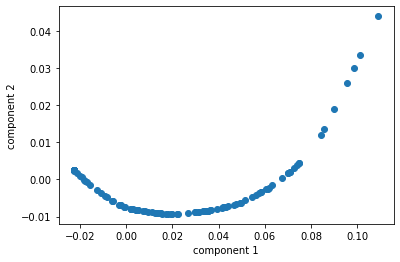

In [305]:
projected = pca.fit_transform(gan_samples_p)
plt.scatter(projected[:, 0], projected[:, 1])
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

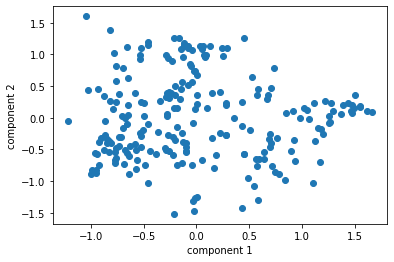

In [306]:
projected = pca.fit_transform(wgan_samples_p)
plt.scatter(projected[:, 0], projected[:, 1])
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.plot